# Scrap My Prop

### Laboratórios de Engenharia Informática

**"Development of an IT solution for the extraction and automatic analysis of data and relevant information for the calculation of land and properties."**

## Importar Bibliotecas Python

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from IPython.core.debugger import set_trace
import geopy.distance
import os.path
from sklearn import metrics

# 'Imovirtual'

## Ler Dados do CSV

**Junção dos datasets através do 'id'**

In [2]:
k = True

for mes in range(4,7):
    if mes > 0 and mes < 10:
        mes = str(mes).zfill(2)
    print("------ Mês:", mes)
    for dia in range(1,31):
        if dia > 0 and dia < 10:
            dia = str(dia).zfill(2)
        print("--- Dia:", dia)
        if os.path.isfile(f'../dados/dados_imovirtual_{dia}_{mes}.csv'):
            if k:
                data_imo = pd.read_csv(f'../dados/dados_imovirtual_{dia}_{mes}.csv', engine='python', encoding='utf8')
                print(data_imo.shape)
                k = False
            else:
                csv = pd.read_csv(f'../dados/dados_imovirtual_{dia}_{mes}.csv', engine='python', encoding='utf8')
                data_imo = data_imo.append(csv,sort=False)
                data_imo = data_imo.drop_duplicates(subset='Id', keep="last")
                data_imo.index = np.arange(1, len(data_imo) + 1)
                print(data_imo.shape)

------ Mês: 04
--- Dia: 01
--- Dia: 02
--- Dia: 03
--- Dia: 04
--- Dia: 05
--- Dia: 06
--- Dia: 07
--- Dia: 08
--- Dia: 09
--- Dia: 10
--- Dia: 11
--- Dia: 12
--- Dia: 13
--- Dia: 14
--- Dia: 15
(5618, 132)
--- Dia: 16
(5684, 132)
--- Dia: 17
(5712, 132)
--- Dia: 18
(5740, 132)
--- Dia: 19
(5742, 132)
--- Dia: 20
(5755, 132)
--- Dia: 21
(5758, 132)
--- Dia: 22
(5796, 132)
--- Dia: 23
(5803, 132)
--- Dia: 24
(5827, 132)
--- Dia: 25
(5874, 132)
--- Dia: 26
(5877, 132)
--- Dia: 27
(5880, 132)
--- Dia: 28
--- Dia: 29
--- Dia: 30
------ Mês: 05
--- Dia: 01
--- Dia: 02
--- Dia: 03
--- Dia: 04
--- Dia: 05
--- Dia: 06
--- Dia: 07
--- Dia: 08
--- Dia: 09
(6160, 132)
--- Dia: 10
(6160, 132)
--- Dia: 11
(6162, 132)
--- Dia: 12
(6195, 132)
--- Dia: 13
(6222, 132)
--- Dia: 14
(6252, 132)
--- Dia: 15
(6289, 132)
--- Dia: 16
(6372, 132)
--- Dia: 17
(6373, 132)
--- Dia: 18
(6383, 132)
--- Dia: 19
(6437, 132)
--- Dia: 20
(6453, 132)
--- Dia: 21
--- Dia: 22
(6513, 132)
--- Dia: 23
(6532, 132)
--- Dia: 2

In [3]:
#data_imo = pd.read_csv('../dados/dados_imovirtual_08_05.csv', engine='python', encoding='utf8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
data_imo.head()

,Nome,Id,Tipo de imóvel,Preço,Preço m/2,Distrito,Concelho,Freguesia,Rua,Latitude,Longitude,Tipologia,Nº Casas de Banho,Área útil m/2,Área bruta m/2,Ano construção,Certificado energético,Armário,Cozinha equipada,Garagem box,Gás canalizado,Lareira,Marquise,Suite,Varanda,Vista de cidade,Condição,Despensa,Arrecadação,Porta blindada,Video Porteiro,Empreendimento,Ar condicionado,Elevador,Estores elétricos,Fibra ótica,Pré-instalação de ar condicionado,Terraço,Área de terreno m/2,Churrasco,Árvores de fruto,Sotão,Cave,Jardim,Aquecimento central,Caldeira,Acessibilidade a pessoas com mobilidade condicionada,Box 2 carros,Detetor de gás,Painéis solares,Recuperação de calor,Vista de campo/serra,Box 1 carro,Portaria,Estacionamento,Piso radiante,Som ambiente,Aspiração central,Finalidade,Tipo de terreno,Acesso pavimentado,Asfaltado,Iluminação pública,Zona arborizada,Declive,Ruína,Alarme,Furo de água,Domótica,Casa das máquinas,Condomínio Fechado,Parque infantil,Piscina,Piscina Privada,Termoacumulador,Garagem exterior,Mobilado,Hidromassagem/jacuzzi,Quintal/horta,Ginásio,Kitchenette,Vigilância/segurança,Campo de ténis,Segurança 24 horas,Vedação,Parqueamento (1 carro),Ligação a rede de água,Ligação a rede de saneamento,Ligação a rede elétrica,Animais permitidos,Parqueamento (2 carros),Cofre,Vista de rio,Nº divisões,Tipo,Pisos,Com WC,Montra,Anexo habitacional,Detetor de incêndio,Detetor de Inundução,Vista de cidade.1,Área (m/2),Vista de mar,Jacuzzi,Património classificado,Adaptada a mobilidade reduzida,Com cozinha,Imóvel de banca,Vista de lago,Fossa séptica,Licensa de construção,Acesso a veículos pesados,Área administrativa,Copa,Recepção,Refeitório,Sala de reuniões,Área florestal,Hidromassagem,Percurso de água,Armazém,Vista de Serra,Adaptado a mobilidade reduzida,Terra batida,Video vigilância,Espaço frigorífico,Espaço para arrumação,Casa de banho partilhada,Poço,Sótão,Paisagem protegida
1,Loja comercial Junto ao Centro da Cidade de Br...,14804552.0,Loja,19 900,622,Braga (distrito),Braga,Sequeira,Rua Inácio José Peixoto,41.554660,-8.432971,NaN,NaN,32 m²,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Usado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Loja,1.0,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Excelente Terreno em Fradelos, Braga",14976693.0,Terreno,97 000,60,Braga (distrito),Braga,Vilaça e Fradelos,NaN,41.507746,-8.477455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rústico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Moradia Terrea em Lomar,15377577.0,Moradia,NaN,NaN,Braga (distrito),Braga,Lomar e Arcos,Rua Quinta das Mouras - Lomar,41.527420,-8.423300,T4,4 ou mais,537 m²,2 448 m²,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,não,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Moradia p/ Restauro - Maximinos,14698254.0,Moradia,149 500,1 495,Braga (distrito),Braga,"Braga (Maximinos, Sé e Cividade)",NaN,41.549550,-8.437720,T0,NaN,100 m²,131 m²,1980.0,NaN,NaN,NaN,NaN,Na

## Pré-processamento comum a todo o Dataset

**Funções auxiliares**

In [4]:
def toNumeric(string):
    res = str(string)
    res = res.replace(" ", "")
    res = res.replace(",", ".")
    res = float(pd.to_numeric(res, errors='ignore')) # tem que ser float porque esse tipo consegue interpretar o np.nan
    return res

**Colunas 'Distrito' e 'Concelho': Retirar colunas de forma total porque já era uma pré-condição do projeto, mas primeiro verificar se, de facto, todos os campos estão preenchidos com 'Braga';**

In [5]:
print("Distritos existentes:", data_imo['Distrito'].unique())
print("Concelhos existentes:", data_imo['Concelho'].unique())

Distritos existentes: ['Braga (distrito)' nan]
Concelhos existentes: ['Braga' nan]


In [6]:
if 'Distrito' in data_imo.columns:
    data_imo = data_imo.drop(['Distrito'], axis = 1) 
if 'Concelho' in data_imo.columns:
    data_imo = data_imo.drop(['Concelho'], axis = 1) 

**Coluna 'Nome': Não é característica dos imóveis mas sim identificador, portanto não deve entrar nos cálculos (Drop);**

In [7]:
if 'Nome' in data_imo.columns:
    data_imo = data_imo.drop(['Nome'], axis = 1) 

**Coluna 'Id': Drop linhas sem 'Id'; float -> int;**

In [8]:
data_imo = data_imo.dropna(subset=['Id'])
data_imo.index = np.arange(1, len(data_imo) + 1)

In [9]:
data_imo['Id'] = data_imo['Id'].astype(int)

**Dar join a colunas que, apesar de aparentarem ter nomes diferentes, representam o mesmo**

**Exemplo: Valores de 'Box 1 carro' e 'Box 2 carros' -> 'Garagem box'; Valores de 'Parqueamento (1 carro)' e 'Parqueamento (2 carros)' -> 'Estacionamento'; Valores de 'Hidromassagem' e 'Jacuzzi' -> 'Hidromassagem/jacuzzi'; ...**

**Fazer o mesmo com piscina e piscina privada???**

In [10]:
#pd.set_option('display.max_columns', None)
#data_imo.columns.to_numpy()

In [11]:
for index,val in data_imo['Vista de cidade.1'].items():
    if (val==True):
        data_imo['Vista de cidade'].iloc[index] = True
for index,val in data_imo['Sótão'].items():
    if (val==True):
        data_imo['Sotão'].iloc[index] = True
for index,val in data_imo['Vista de Serra'].items():
    if (val==True):
        data_imo['Vista de campo/serra'].iloc[index] = True
for index,val in data_imo['Adaptada a mobilidade reduzida'].items():
    if (val==True):
        data_imo['Adaptado a mobilidade reduzida'].iloc[index] = True
for index,val in data_imo['Box 1 carro'].items():
    if (val==True):
        data_imo['Garagem box'].iloc[index] = True
for index,val in data_imo['Box 2 carros'].items():
    if (val==True):
        data_imo['Garagem box'].iloc[index] = True
for index,val in data_imo['Parqueamento (1 carro)'].items():
    if (val==True):
        data_imo['Estacionamento'].iloc[index] = True
for index,val in data_imo['Parqueamento (2 carros)'].items():
    if (val==True):
        data_imo['Estacionamento'].iloc[index] = True
for index,val in data_imo['Hidromassagem'].items():
    if (val==True):
        data_imo['Hidromassagem/jacuzzi'].iloc[index] = True
for index,val in data_imo['Jacuzzi'].items():
    if (val==True):
        data_imo['Hidromassagem/jacuzzi'].iloc[index] = True
        
data_imo=data_imo.drop(['Vista de cidade.1', 'Sótão', 'Vista de Serra', 'Hidromassagem', 'Jacuzzi', 'Adaptada a mobilidade reduzida'], axis=1)

/Users/diogobraga/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
#data_imo.info(verbose=True, null_counts=True)

**Normalizar os valores de todas as áreas; Transformar em dado numérico;**

In [13]:
for column in data_imo.columns:
    if "Área" in column and "Área administrativa" not in column and "Área florestal" not in column:
        for i in range(len(data_imo[column])):
            if not pd.isnull(data_imo[column].iloc[i]):
                #print(data_imo[column].iloc[i])
                data_imo[column].iloc[i]=toNumeric(str(data_imo[column].iloc[i])[0:-3])
                #print(data_imo[column].iloc[i])
                #print(type(data_imo[column].iloc[i]))

**Coluna 'Preço' e 'Preço m/2': Drop dos imóveis com valor 'nan'; Transformar em dado numérico;**

In [14]:
data_imo['Preço'] = data_imo['Preço'].apply(toNumeric)

nan_prices = data_imo['Preço'].index[data_imo['Preço'].apply(np.isnan)]
data_imo = data_imo.drop(nan_prices)
data_imo.index = np.arange(1, len(data_imo) + 1)

data_imo['Preço'] = data_imo['Preço'].apply(int)

# ------

data_imo['Preço m/2'] = data_imo['Preço m/2'].apply(toNumeric)

nan_prices = data_imo['Preço m/2'].index[data_imo['Preço m/2'].apply(np.isnan)]
data_imo = data_imo.drop(nan_prices)
data_imo.index = np.arange(1, len(data_imo) + 1)

data_imo['Preço m/2'] = data_imo['Preço m/2'].apply(int)

In [15]:
data_imo.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7380 entries, 1 to 7380
Data columns (total 123 columns):
Id                                                      int64
Tipo de imóvel                                          object
Preço                                                   int64
Preço m/2                                               int64
Freguesia                                               object
Rua                                                     object
Latitude                                                float64
Longitude                                               float64
Tipologia                                               object
Nº Casas de Banho                                       object
Área útil m/2                                           object
Área bruta m/2                                          object
Ano construção                                          float64
Certificado energético                                  object
Armário   

# Dados - Moradias

**Ver os valores únicos de cada coluna para proceder ao processamento**

In [16]:
for col in data_imo.columns:
    uniques=data_imo[col].unique()
    print("Valores únicos para a coluna ", col, ": ", uniques)

Valores únicos para a coluna  Id :  [14804552 14976693 14698254 ... 12380131  6701616  6701610]
Valores únicos para a coluna  Tipo de imóvel :  ['Loja' 'Terreno' 'Moradia' 'Apartamento' 'Escritório' 'Prédio' 'Quintas'
 'Armazém' 'Garagem' 'Trespasses']
Valores únicos para a coluna  Preço :  [   19900    97000   149500   288000   116000   315000   148000   180000
   298000    40000    50000   350000    99700    12500   140000   177000
    90000   270000   117500   250000   290000   320000  2000000    68000
   199000   500000   230000   125000   281000   210000   330000   225000
   295000   215000   425000   115000   220000   397500   300000   150000
    70000   285000   245000    63000    77500   188000    95000   112500
    57000   580000    60000    94000     7000   335000   123000    85000
    99000     9500     8000   340000   128250   165000   325000    82000
   275000    55000   360000   185000  9900000   680000   649000   249900
   310000   157000   365000    77000   155000   259

Valores únicos para a coluna  Área florestal :  [nan True]
Valores únicos para a coluna  Percurso de água :  [nan True]
Valores únicos para a coluna  Armazém :  [nan True]
Valores únicos para a coluna  Adaptado a mobilidade reduzida :  [nan True]
Valores únicos para a coluna  Terra batida :  [nan True]
Valores únicos para a coluna  Video vigilância :  [nan True]
Valores únicos para a coluna  Espaço frigorífico :  [nan]
Valores únicos para a coluna  Espaço para arrumação :  [nan 'Sim']
Valores únicos para a coluna  Casa de banho partilhada :  [nan True]
Valores únicos para a coluna  Poço :  [nan True]
Valores únicos para a coluna  Paisagem protegida :  [nan True]


**Dividir os dados por tipo de imóvel**

In [17]:
data_imo_moradias = data_imo.loc[(data_imo['Tipo de imóvel'] == 'Moradia')]
data_imo_moradias.index = np.arange(1, len(data_imo_moradias) + 1)

In [18]:
data_imo_moradias.head()

,Id,Tipo de imóvel,Preço,Preço m/2,Freguesia,Rua,Latitude,Longitude,Tipologia,Nº Casas de Banho,Área útil m/2,Área bruta m/2,Ano construção,Certificado energético,Armário,Cozinha equipada,Garagem box,Gás canalizado,Lareira,Marquise,Suite,Varanda,Vista de cidade,Condição,Despensa,Arrecadação,Porta blindada,Video Porteiro,Empreendimento,Ar condicionado,Elevador,Estores elétricos,Fibra ótica,Pré-instalação de ar condicionado,Terraço,Área de terreno m/2,Churrasco,Árvores de fruto,Sotão,Cave,Jardim,Aquecimento central,Caldeira,Acessibilidade a pessoas com mobilidade condicionada,Box 2 carros,Detetor de gás,Painéis solares,Recuperação de calor,Vista de campo/serra,Box 1 carro,Portaria,Estacionamento,Piso radiante,Som ambiente,Aspiração central,Finalidade,Tipo de terreno,Acesso pavimentado,Asfaltado,Iluminação pública,Zona arborizada,Declive,Ruína,Alarme,Furo de água,Domótica,Casa das máquinas,Condomínio Fechado,Parque infantil,Piscina,Piscina Privada,Termoacumulador,Garagem exterior,Mobilado,Hidromassagem/jacuzzi,Quintal/horta,Ginásio,Kitchenette,Vigilância/segurança,Campo de ténis,Segurança 24 horas,Vedação,Parqueamento (1 carro),Ligação a rede de água,Ligação a rede de saneamento,Ligação a rede elétrica,Animais permitidos,Parqueamento (2 carros),Cofre,Vista de rio,Nº divisões,Tipo,Pisos,Com WC,Montra,Anexo habitacional,Detetor de incêndio,Detetor de Inundução,Área (m/2),Vista de mar,Património classificado,Com cozinha,Imóvel de banca,Vista de lago,Fossa séptica,Licensa de construção,Acesso a veículos pesados,Área administrativa,Copa,Recepção,Refeitório,Sala de reuniões,Área florestal,Percurso de água,Armazém,Adaptado a mobilidade reduzida,Terra batida,Video vigilância,Espaço frigorífico,Espaço para arrumação,Casa de banho partilhada,Poço,Paisagem protegida
1,14698254,Moradia,149500,1495,"Braga (Maximinos, Sé e Cividade)",NaN,41.549550,-8.437720,T0,NaN,100,131,1980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ruína,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14979186,Moradia,288000,1200,"Nogueira, Fraião e Lamaçães",NaN,41.548575,-8.390454,T4,2,240,362,NaN,B,NaN,NaN,True,NaN,NaN,NaN,NaN,True,NaN,Novo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14765501,Moradia,315000,1406,"Nogueira, Fraião e Lamaçães",Rua Quinta da Barra,41.526840,-8.411760,T3,3,224,263,2019.0,Isento,NaN,NaN,True,True,True,NaN,NaN,NaN,True,Em construção,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14967643,Moradia,298000,1769,"Nogueira, Fraião e Lamaçães",NaN,41.526840,-8.411760,T3,NaN,168.5,262.5,2019.0,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Em construção,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [19]:
#data_imo_moradias.info(verbose=True, null_counts=True)

## Análise exploratória de dados

*Distribuição da feature 'Preço'*

Text(0.5, 0, 'Preço')

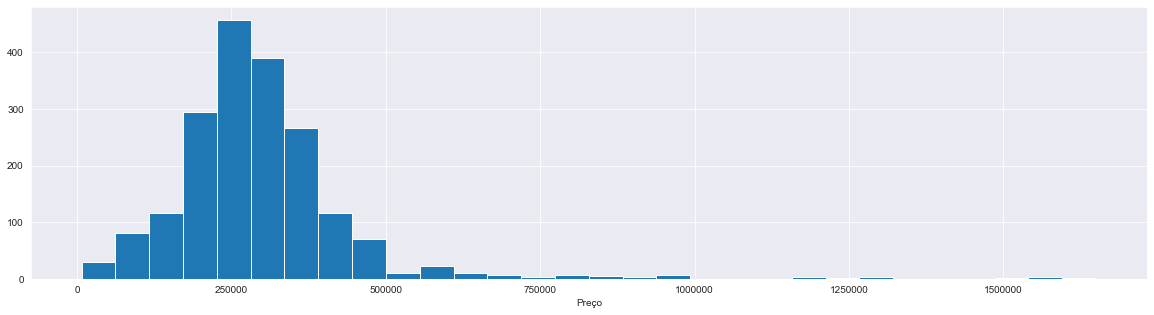

In [20]:
fig = plt.figure(figsize = (20,5))
sns.set_style('darkgrid')
data_imo_moradias['Preço'].hist(bins=30)
plt.xlabel('Preço')

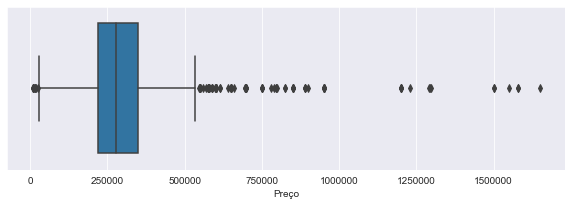

In [21]:
fig = plt.figure(figsize = (10,3))
sns.boxplot(x=data_imo_moradias['Preço'])

*Distribuição da feature 'Preço' - Outliers visuais*

In [22]:
a_excluir = data_imo_moradias[(data_imo_moradias['Preço'] >= 1000000)]
#a_excluir = data_imo_moradias[(data_imo_moradias['Preço'] >= 400000) | (data_imo_moradias['Preço'] <= 150000)]
data_imo_moradias = data_imo_moradias.drop(a_excluir.index)
data_imo_moradias.index = np.arange(1, len(data_imo_moradias) + 1)
a_excluir

,Id,Tipo de imóvel,Preço,Preço m/2,Freguesia,Rua,Latitude,Longitude,Tipologia,Nº Casas de Banho,Área útil m/2,Área bruta m/2,Ano construção,Certificado energético,Armário,Cozinha equipada,Garagem box,Gás canalizado,Lareira,Marquise,Suite,Varanda,Vista de cidade,Condição,Despensa,Arrecadação,Porta blindada,Video Porteiro,Empreendimento,Ar condicionado,Elevador,Estores elétricos,Fibra ótica,Pré-instalação de ar condicionado,Terraço,Área de terreno m/2,Churrasco,Árvores de fruto,Sotão,Cave,Jardim,Aquecimento central,Caldeira,Acessibilidade a pessoas com mobilidade condicionada,Box 2 carros,Detetor de gás,Painéis solares,Recuperação de calor,Vista de campo/serra,Box 1 carro,Portaria,Estacionamento,Piso radiante,Som ambiente,Aspiração central,Finalidade,Tipo de terreno,Acesso pavimentado,Asfaltado,Iluminação pública,Zona arborizada,Declive,Ruína,Alarme,Furo de água,Domótica,Casa das máquinas,Condomínio Fechado,Parque infantil,Piscina,Piscina Privada,Termoacumulador,Garagem exterior,Mobilado,Hidromassagem/jacuzzi,Quintal/horta,Ginásio,Kitchenette,Vigilância/segurança,Campo de ténis,Segurança 24 horas,Vedação,Parqueamento (1 carro),Ligação a rede de água,Ligação a rede de saneamento,Ligação a rede elétrica,Animais permitidos,Parqueamento (2 carros),Cofre,Vista de rio,Nº divisões,Tipo,Pisos,Com WC,Montra,Anexo habitacional,Detetor de incêndio,Detetor de Inundução,Área (m/2),Vista de mar,Património classificado,Com cozinha,Imóvel de banca,Vista de lago,Fossa séptica,Licensa de construção,Acesso a veículos pesados,Área administrativa,Copa,Recepção,Refeitório,Sala de reuniões,Área florestal,Percurso de água,Armazém,Adaptado a mobilidade reduzida,Terra batida,Video vigilância,Espaço frigorífico,Espaço para arrumação,Casa de banho partilhada,Poço,Paisagem protegida
200,14968897,Moradia,1500000,1015,Nogueiró e Tenões,NaN,41.551395,-8.386406,T5,NaN,1478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Em construção,NaN,NaN,NaN,NaN,não,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
471,15541545,Moradia,1650000,2523,Este (São Pedro e São Mamede),Rua Campo 25 de Abril - São Pedro ( Este),41.569822,-8.365681,T4,4 ou mais,654,766,2014.0,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,não,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
705,15260845,Moradia,1290000,921,Ferreiros e Gondizalves,NaN,41.536835,-8.439914,T6,4 ou mais,1400,1700,NaN,NaN,NaN,NaN,True,NaN,True,True,True,True,NaN,Usado,True,True,True,True,não,NaN,NaN,NaN,NaN,NaN,True,NaN,True,True,NaN,True,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True,True,True,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805,14857594,Moradia,1500000,2500,São Victor,NaN,41.549941,-8.416010,T4,4 ou mais,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,Usado,NaN,NaN,NaN,NaN,não,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

*Relação entre o Preço e Área útil*

Text(0, 0.5, 'Preço')

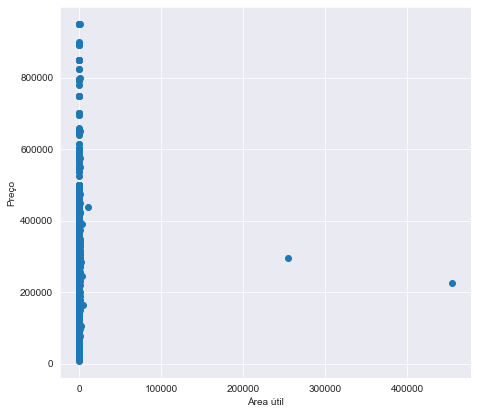

In [23]:
fig = plt.figure(figsize = (25,15))

ax1 = fig.add_subplot(2,3,1)
ax1.scatter(data_imo_moradias['Área útil m/2'], data_imo_moradias['Preço'])
ax1.set_xlabel('Área útil')
ax1.set_ylabel('Preço')

*Relação entre o Preço e Área útil - Outliers visuais*

In [24]:
a_excluir = data_imo_moradias[(data_imo_moradias['Área útil m/2'] >= 10000)]
data_imo_moradias = data_imo_moradias.drop(a_excluir.index)
data_imo_moradias.index = np.arange(1, len(data_imo_moradias) + 1)
a_excluir

,Id,Tipo de imóvel,Preço,Preço m/2,Freguesia,Rua,Latitude,Longitude,Tipologia,Nº Casas de Banho,Área útil m/2,Área bruta m/2,Ano construção,Certificado energético,Armário,Cozinha equipada,Garagem box,Gás canalizado,Lareira,Marquise,Suite,Varanda,Vista de cidade,Condição,Despensa,Arrecadação,Porta blindada,Video Porteiro,Empreendimento,Ar condicionado,Elevador,Estores elétricos,Fibra ótica,Pré-instalação de ar condicionado,Terraço,Área de terreno m/2,Churrasco,Árvores de fruto,Sotão,Cave,Jardim,Aquecimento central,Caldeira,Acessibilidade a pessoas com mobilidade condicionada,Box 2 carros,Detetor de gás,Painéis solares,Recuperação de calor,Vista de campo/serra,Box 1 carro,Portaria,Estacionamento,Piso radiante,Som ambiente,Aspiração central,Finalidade,Tipo de terreno,Acesso pavimentado,Asfaltado,Iluminação pública,Zona arborizada,Declive,Ruína,Alarme,Furo de água,Domótica,Casa das máquinas,Condomínio Fechado,Parque infantil,Piscina,Piscina Privada,Termoacumulador,Garagem exterior,Mobilado,Hidromassagem/jacuzzi,Quintal/horta,Ginásio,Kitchenette,Vigilância/segurança,Campo de ténis,Segurança 24 horas,Vedação,Parqueamento (1 carro),Ligação a rede de água,Ligação a rede de saneamento,Ligação a rede elétrica,Animais permitidos,Parqueamento (2 carros),Cofre,Vista de rio,Nº divisões,Tipo,Pisos,Com WC,Montra,Anexo habitacional,Detetor de incêndio,Detetor de Inundução,Área (m/2),Vista de mar,Património classificado,Com cozinha,Imóvel de banca,Vista de lago,Fossa séptica,Licensa de construção,Acesso a veículos pesados,Área administrativa,Copa,Recepção,Refeitório,Sala de reuniões,Área florestal,Percurso de água,Armazém,Adaptado a mobilidade reduzida,Terra batida,Video vigilância,Espaço frigorífico,Espaço para arrumação,Casa de banho partilhada,Poço,Paisagem protegida
1111,15182972,Moradia,225000,0,Sequeira,Travessa do Rio,41.528882,-8.472425,T3,4 ou mais,454500,1142,2005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,não,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1135,14842136,Moradia,439000,40,Priscos,NaN,41.498184,-8.478036,T5,NaN,11000,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,Usado,NaN,NaN,NaN,NaN,não,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1613,15494825,Moradia,295000,1,Arentim e Cunha,NaN,41.484700,-8.512800,T3,NaN,255275,275,2020.0,A+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Em construção,NaN,NaN,NaN,NaN,não,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*Relação entre o Preço e Freguesia*

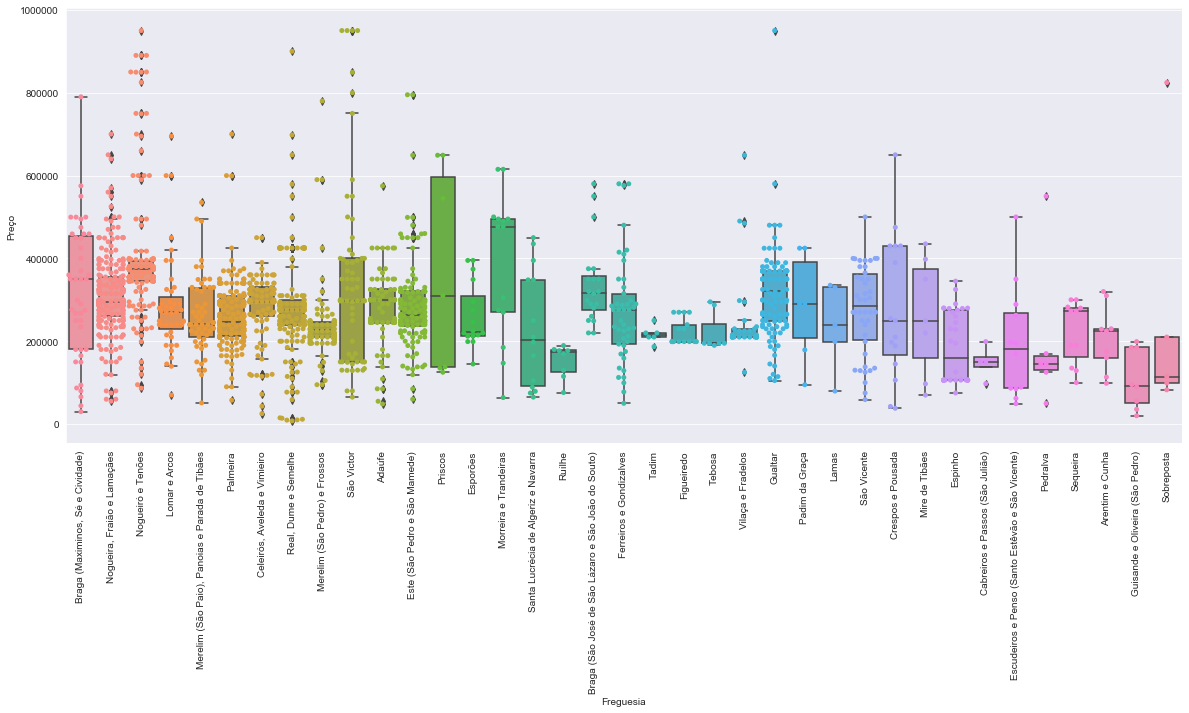

In [25]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)
sns.boxplot(data_imo_moradias['Freguesia'], data_imo_moradias['Preço'])
sns.swarmplot(data_imo_moradias['Freguesia'], data_imo_moradias['Preço'])
plt.show()

*Relação entre o Preço e Tipologia*

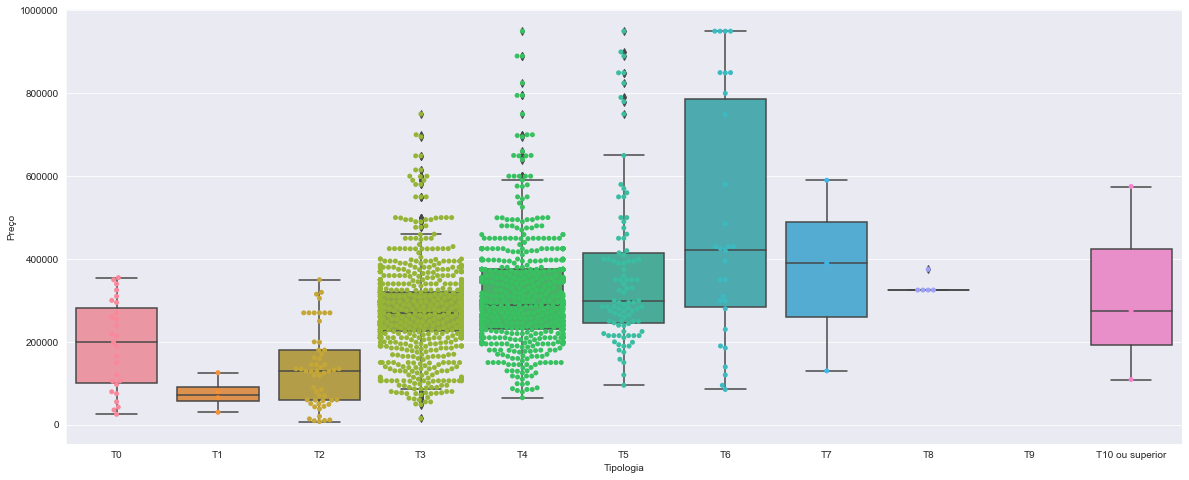

In [26]:
plt.figure(figsize=(20, 8))
sns.boxplot(data_imo_moradias['Tipologia'], data_imo_moradias['Preço'], order=['T0','T1','T2','T3','T4','T5','T6','T7','T8','T9','T10 ou superior'])
sns.swarmplot(data_imo_moradias['Tipologia'], data_imo_moradias['Preço'], order=['T0','T1','T2','T3','T4','T5','T6','T7','T8','T9','T10 ou superior'])
plt.show()

**Dados em falta por coluna**

In [27]:
pd.set_option('display.max_rows', None)
percent_missing = data_imo_moradias.isnull().sum() * 100 / len(data_imo_moradias)
missing_value_data_imo_moradias_columns = pd.DataFrame({'percent_missing (%)': percent_missing})
sort_data = missing_value_data_imo_moradias_columns.copy()
sort_data.sort_values('percent_missing (%)', inplace=True, ascending=False)
sort_data

,percent_missing (%)
Declive,100.000000
Ligação a rede de água,100.000000
Montra,100.000000
Com WC,100.000000
Pisos,100.000000
Tipo,100.000000
Nº divisões,100.000000
Parqueamento (2 carros),100.000000
Estores elétricos,100.000000
Ligação a rede elétrica,100.000000


In [28]:
pd.set_option('display.max_rows', 10)

**Remover colunas que tenham mais de 20% (?) de missing values**

In [29]:
a_manter = list(missing_value_data_imo_moradias_columns.index[missing_value_data_imo_moradias_columns['percent_missing (%)'] < 20])
data_imo_moradias = data_imo_moradias[a_manter]
data_imo_moradias

,Id,Tipo de imóvel,Preço,Preço m/2,Freguesia,Latitude,Longitude,Tipologia,Área útil m/2
1,14698254,Moradia,149500,1495,"Braga (Maximinos, Sé e Cividade)",41.549550,-8.437720,T0,100
2,14979186,Moradia,288000,1200,"Nogueira, Fraião e Lamaçães",41.548575,-8.390454,T4,240
3,14765501,Moradia,315000,1406,"Nogueira, Fraião e Lamaçães",41.526840,-8.411760,T3,224
4,14967643,Moradia,298000,1769,"Nogueira, Fraião e Lamaçães",41.526840,-8.411760,T3,168.5
5,13675795,Moradia,350000,1167,Nogueiró e Tenões,41.550098,-8.388531,T4,300
...,...,...,...,...,...,...,...,...,...
1887,15352138,Moradia,195000,670,Escudeiros e Penso (Santo Estêvão e São Vicente),41.481139,-8.424812,T4,291
1888,13184134,Moradia,320000,1123,Palmeira,41.595200,-8.434870,T3,285
1889,14580112,Moradia,240000,727,Palmeira,41.595200,-8.434870,T4,330
1890,15521254,Moradia,275000,1667,Nogueiró e Tenões,41.550025,-8.383364,T3,165


**Dados em falta por linha**

In [30]:
percent_missing = (1 - data_imo_moradias.apply(lambda x: x.count(), axis=1) / len(data_imo_moradias.columns)) * 100
missing_value_data_imo_moradias_rows = pd.DataFrame({'percent_missing (%)': percent_missing})
sort_data = missing_value_data_imo_moradias_rows.copy()
sort_data.sort_values('percent_missing (%)', inplace=True, ascending=False)
sort_data

,percent_missing (%)
1,0.0
1257,0.0
1269,0.0
1268,0.0
1267,0.0
...,...
627,0.0
626,0.0
625,0.0
624,0.0


**Remover linhas com percentagem de dados em falta superior a 50%**

In [31]:
a_excluir = missing_value_data_imo_moradias_rows[(missing_value_data_imo_moradias_rows['percent_missing (%)'] >= 50)]
data_imo_moradias = data_imo_moradias.drop(a_excluir.index)
data_imo_moradias.index = np.arange(1, len(data_imo_moradias) + 1)

**Inserir dados em falta**

In [32]:
for x in data_imo_moradias.select_dtypes(include=['float64']).columns.tolist():
    median_value=data_imo_moradias[x].median()
    data_imo_moradias[x]=data_imo_moradias[x].fillna(median_value)

for y in data_imo_moradias.select_dtypes(include=['object']).columns.tolist():
    mode_value=data_imo_moradias[y].mode()
    data_imo_moradias[y]=data_imo_moradias[y].fillna(mode_value[0])    
    
data_imo_moradias

,Id,Tipo de imóvel,Preço,Preço m/2,Freguesia,Latitude,Longitude,Tipologia,Área útil m/2
1,14698254,Moradia,149500,1495,"Braga (Maximinos, Sé e Cividade)",41.549550,-8.437720,T0,100.0
2,14979186,Moradia,288000,1200,"Nogueira, Fraião e Lamaçães",41.548575,-8.390454,T4,240.0
3,14765501,Moradia,315000,1406,"Nogueira, Fraião e Lamaçães",41.526840,-8.411760,T3,224.0
4,14967643,Moradia,298000,1769,"Nogueira, Fraião e Lamaçães",41.526840,-8.411760,T3,168.5
5,13675795,Moradia,350000,1167,Nogueiró e Tenões,41.550098,-8.388531,T4,300.0
...,...,...,...,...,...,...,...,...,...
1887,15352138,Moradia,195000,670,Escudeiros e Penso (Santo Estêvão e São Vicente),41.481139,-8.424812,T4,291.0
1888,13184134,Moradia,320000,1123,Palmeira,41.595200,-8.434870,T3,285.0
1889,14580112,Moradia,240000,727,Palmeira,41.595200,-8.434870,T4,330.0
1890,15521254,Moradia,275000,1667,Nogueiró e Tenões,41.550025,-8.383364,T3,165.0


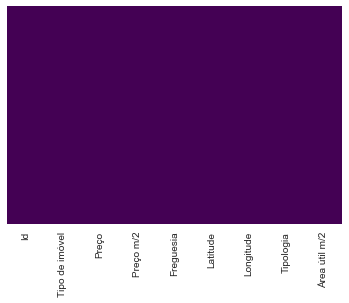

In [33]:
sns.heatmap(data_imo_moradias.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Inserção de dados acerca da localização do imóvel

*www.google.com/maps/*

**Funções auxiliares**

In [34]:
def distance_coordinates(lat1,lon1,lat2,lon2):
    
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    
    res = geopy.distance.geodesic(coords_1, coords_2).km

    return round(res,3)

def minDist(data_imo, values):
    distancias = []
    for index, row in data_imo.iterrows():
        min_dist = 99999999.9
        for value in values.values():
            dist = distance_coordinates(data_imo_moradias.iloc[index-1]['Latitude'],data_imo_moradias.iloc[index-1]['Longitude'],value[0],value[1])
            if dist < min_dist:
                min_dist = dist    
        ratio = round(1/min_dist,2)
        distancias.append(ratio) # 1/min_dist para quanto mais próximo, maior valor possuir
    return distancias

**Centro da Cidade**

In [35]:
centro_cidade = {}
centro_cidade['Centro'] = 41.5514083,-8.4230248

In [36]:
data_imo_moradias['Centro Cidade (km)'] = minDist(data_imo_moradias, centro_cidade)

**Hospitais**

In [37]:
hospitais = {}
hospitais['Hospital de Braga'] = 41.5679738,-8.3990116
hospitais['Trofa Saúde - Braga Sul'] = 41.5246625,-8.4141593
hospitais['Trofa Saúde - Braga Centro'] = 41.5498965,-8.4187538
hospitais['Lusíadas Braga'] = 41.5476764,-8.4224197

In [38]:
data_imo_moradias['Hospitais (km)'] = minDist(data_imo_moradias, hospitais)

**Centros de Saúde**

In [39]:
centros_saude = {}
centros_saude['Braga Centro'] = 41.5471857,-8.4279198
centros_saude['Infias'] = 41.5602432,-8.4228005
centros_saude['USF do Minho'] = 41.5465815,-8.4147386
centros_saude['Clinica de Sao Marcos'] = 41.5454486,-8.426507
centros_saude['O Poverello'] = 41.5703584,-8.4114745
centros_saude['Clinica Cubana Braga'] = 41.5492599,-8.4262347
centros_saude['Clinica Médico - Cirurgica De Santa Tecla'] = 41.5489178,-8.4117642
centros_saude['Hemoatlantico - Braga'] = 41.5459355,-8.4314237
centros_saude['Centro de Vacinação Internacional'] = 41.5586578,-8.3999608
centros_saude['Clinica Enguardas'] = 41.5571581,-8.4127898
centros_saude['USF Braga Norte'] = 41.5603489,-8.4227264
centros_saude['USF Carandá'] = 41.5525337,-8.4123
centros_saude['USF Bracara Augusta'] = 41.5422297,-8.4105532
centros_saude['USF Maxisaúde'] = 41.5473324,-8.4279983
centros_saude['USF São Lourenço'] = 41.5142651,-8.4559502
centros_saude['USF São João de Braga'] = 41.5463782,-8.4145564
centros_saude['USF Manuel Rocha Peixoto'] = 41.5473003,-8.4279339
centros_saude['USF Gualtar'] = 41.5682764,-8.3871645
centros_saude['USF Saúde Oeste'] = 41.5325817,-8.4733681
centros_saude['USF Tadim'] = 41.5079792,-8.4879975
centros_saude['Gualtar'] = 41.5683003,-8.3872187
centros_saude['USF Esporões'] = 41.5120606,-8.4201814
centros_saude['USF Salutis'] = 41.5465247,-8.4147014
centros_saude['USP de Braga'] = 41.5588888,-8.3998833

In [40]:
data_imo_moradias['Centros Saúde (km)'] = minDist(data_imo_moradias, centros_saude)

**Centros Comerciais**

In [41]:
centroscomerciais = {}
centroscomerciais['Braga Parque'] = 41.5577669,-8.4060603
centroscomerciais['Minho Center'] = 41.540935,-8.400464
centroscomerciais['Nova Arcada'] = 41.579068,-8.429654

In [42]:
data_imo_moradias['Centro Comerciais (km)'] = minDist(data_imo_moradias, centroscomerciais)

**Escolas**

In [43]:
escolas = {}
escolas['Secundária Sá de Miranda'] = 41.5568137,-8.4182525
escolas['Básica Francisco Sanches'] = 41.5548131,-8.4118978
escolas['Básica de Gualtar'] = 41.5669867,-8.38796
escolas['Básica de Lamaçães'] = 41.5471216,-8.4016327
escolas['Secundária Carlos Amarante'] = 41.5509961,-8.413909
escolas['Básica de Palmeira'] = 41.5771831,-8.4245399
escolas['Secundária de Maximinos'] = 41.5424538,-8.4415713
escolas['Básica André Soares'] = 41.5470115,-8.415924
escolas['Básica do 1º Ciclo de São Vitor'] = 41.55186,-8.4129202
escolas['Básica de Real'] = 41.5577824,-8.4395854
escolas['Jardim Escola João de Deus'] = 41.5447436,-8.407904
escolas['Colégio Luso Internacional de Braga'] = 41.56979,-8.3885487
escolas['EB1 Quinta da Veiga'] = 41.5590263,-8.4239226
escolas['Secundária D. Maria II'] = 41.5487484,-8.4177364
escolas['Básica Bairro da Misericórdia'] = 41.5578043,-8.4262862
escolas['EB1 Carandá'] = 41.5452545,-8.4156397
escolas['Colégio Dom Diogo de Sousa'] = 41.5575,-8.415931
escolas['Centro Escolar Ponte Pedrinha'] = 41.5403601,-8.4294783
escolas['EB1/J1 Bairro da Alegria'] = 41.5638599,-8.402921

In [44]:
data_imo_moradias['Escolas (km)'] = minDist(data_imo_moradias, escolas)

**Universidades**

In [45]:
universidades = {}
universidades['Universidade do Minho - Campus de Gualtar'] = 41.5607319,-8.3962368
universidades['IPCA - Pólo de Braga'] = 41.5421121,-8.4210972
universidades['Universidade Católica Portuguesa'] = 41.554852,-8.4209143

In [46]:
data_imo_moradias['Universidades (km)'] = minDist(data_imo_moradias, universidades)

**Estação de Comboios**

In [47]:
estacao = {}
estacao['Estacao'] = 41.548143,-8.4344431

In [48]:
data_imo_moradias['Estação de Comboios (km)'] = minDist(data_imo_moradias, estacao)

**Parques Industriais**

*www.igogo.pt/parques-industriais-braga/*

In [49]:
parques_industriais = {}
parques_industriais['Frossos'] = 41.5595545,-8.447319
parques_industriais['Quinta do Carreiro'] = 41.5653531,-8.4454561
parques_industriais['Adaúfe'] = 41.5974779,-8.4135554
parques_industriais['Celeirós'] = 41.5109663,-8.454419
parques_industriais['Marvilha'] = 41.5318363,-8.4735374
parques_industriais['Mire de Tibães'] = 41.5819656,-8.4767172
parques_industriais['Padim da Graça'] = 41.5692605,-8.4890601
parques_industriais['Pitancinhos'] = 41.5840245,-8.4219733
parques_industriais['Vilça'] = 41.5154222,-8.4937553

In [50]:
data_imo_moradias['Parques Industriais (km)'] = minDist(data_imo_moradias, parques_industriais)

**Central de Autocarros**

In [51]:
central_autocarros = {}
central_autocarros['Central'] = 41.555324,-8.425410

In [52]:
data_imo_moradias['Central Autocarros (km)'] = minDist(data_imo_moradias, central_autocarros)

**Bancos**

In [53]:
bancos = {}
bancos['BPI Frossos'] = 41.561298,-8.447379
bancos['BPI Gualtar'] = 41.5647823,-8.3876109
bancos['Crédito Agrícola Braga'] = 41.5514726,-8.4278259
bancos['Activo Bank'] = 41.5521836,-8.4267081
bancos['Banif Centro'] = 41.5524396,-8.4236611
bancos['Banco de Portugal'] = 41.5518264,-8.4234077
bancos['Montepio Centro'] = 41.5517009,-8.4180607
bancos['Montepio Centro 2'] = 41.5507289,-8.4250391
bancos['Novo Banco Centro'] = 41.5507776,-8.4238804
bancos['Banco de Investimento Global'] = 41.5495727,-8.4251216
bancos['Novo Banco Centro 2'] = 41.5492902,-8.4121129
bancos['Banco Millenium BCP São Lázaro'] = 41.5475307,-8.4210104
bancos['BBVA São Lázaro'] = 41.5464477,-8.4199778
bancos['Santander Totta Lamaçães'] = 41.5479773,-8.4033012
bancos['Caixa Geral de Depósito Lamaçães'] = 41.5480627,-8.4035902
bancos['BPI Dume'] = 41.5450355,-8.4019862
bancos['Novo Banco Maximinos'] = 41.5448869,-8.4337664
bancos['Caixa Geral de Depósitos Maximinos'] = 41.547196,-8.4338421
bancos['BPI N14'] = 41.53774,-8.434457

In [54]:
data_imo_moradias['Bancos (km)'] = minDist(data_imo_moradias, bancos)

**Correios**

In [55]:
correios = {}
correios['CTT Maximinos'] = 41.5444322,-8.4340695
correios['CTT São Lázaro'] = 41.544917,-8.420586
correios['CTT Fonte Seca'] = 41.535935,-8.4016483
correios['CTT 25 de Abril'] = 41.5474966,-8.4204056
correios['Estação de Correios de Santa Tecla'] = 41.5484275,-8.4118152
correios['CTT Nogueira, Fraiões e Lamaçães'] = 41.5480095,-8.4040274
correios['Posto de Correios de Braga (São José de Lázaro)'] = 41.5497985,-8.4193059
correios['CTT Largo de São Francisco'] = 41.5518429,-8.423987
correios['CTT Braga Parque'] = 41.556725,-8.4056481
correios['CTT Largo de Infias'] = 41.5579778,-8.4165392

In [56]:
data_imo_moradias['Correios (km)'] = minDist(data_imo_moradias, correios)

**Parques e zonas verdes**

In [57]:
parques_lazer = {}
parques_lazer['Parque de Lazer de Gerizes'] = 41.5835983,-8.449529
parques_lazer['Parque da Rodovia'] = 41.552828,-8.4031463
parques_lazer['Jardim da Avenida Central'] = 41.551519,-8.421523
parques_lazer['Parque São João da Ponte'] = 41.5454706,-8.4265083
parques_lazer['Parque da Ponte'] = 41.541304, -8.419441
parques_lazer['Parque de Lazer da Rampa da Falperra'] = 41.5309717,-8.3944834
parques_lazer['Parque de Lazer do Ribeiro dos Prados'] = 41.5052344,-8.4422877 

In [58]:
data_imo_moradias['Parques e Zonas Verdes (km)'] = minDist(data_imo_moradias, parques_lazer)

**Serviços Públicos**

*https://eportugal.gov.pt/locais-de-atendimento-de-servicos-publicos/-/pesquisa/search_stores*

In [59]:
servicos_publicos = {}
servicos_publicos['Finanças 1'] = 41.5498747,-8.4194008
servicos_publicos['Finanças 2'] = 41.5440114,-8.4358346
servicos_publicos['Segurança Social'] = 41.5477731,-8.4129363
servicos_publicos['Serviços de RSI'] = 41.5424794,-8.4360436
servicos_publicos['Gabinete de Atendimento ao Cidadão'] = 41.5561192,-8.4121799
servicos_publicos['Conservatória do Registo Civil'] = 41.5518773,-8.4222603
servicos_publicos['IEFP - Centro de Emprego'] = 41.5423426,-8.4339527
servicos_publicos['SEF - Loja do Cidadão de Braga'] = 41.5474961,-8.421969
servicos_publicos['Espaço Cidadão Sobreposta'] = 41.547783,-8.3619992
servicos_publicos['Espaço Cidadão Adaúfe'] = 41.5861605,-8.3926854
servicos_publicos['Espaço Cidadão Figueiredo'] = 41.5048946,-8.4349509
servicos_publicos['Espaço Cidadão Real'] = 41.5575145,-8.4440584
servicos_publicos['Espaço Cidadão S. Vicente'] = 41.5565553,-8.4241112
servicos_publicos['Espaço Cidadão Sequeira'] = 41.5323623,-8.4732977
servicos_publicos['Espaço Cidadão Tadim'] = 41.5057871,-8.4916939

In [60]:
data_imo_moradias['Serviços Públicos (km)'] = minDist(data_imo_moradias, servicos_publicos)

**Policia Municipal**

In [61]:
policia = {}
policia['Policia'] = 41.5495054,-8.4267993

In [62]:
data_imo_moradias['Policia Municipal (km)'] = minDist(data_imo_moradias, policia)

**Farmácias**

*https://portalnacional.com.pt/braga/braga/farmacias/*

In [63]:
farmacias = {}
farmacias['Adaúfe'] = 41.5858796,-8.4020402
farmacias['Alvim - Merelim (São Pedro) e Frossos'] = 41.5595977,8.4479227
farmacias['Araújo Rodrigues - Celeirós'] = 41.5129219,-8.4503908
farmacias['Beatriz - São Vitor'] = 41.5492671,-8.4133199
farmacias['Braga - São Vitor'] = 41.5511534,-8.4064856
farmacias['Brito - São José de São Lázaro e São João do Souto'] = 41.5505688,-8.4228146
farmacias['Carmo - Merelim (São Pedro) e Frossos'] = 41.5716977,-8.45249
farmacias['Central - São José de São Lázaro e São João do Souto'] = 41.551847,-8.4250035
farmacias['Coelho - Maximinos, Sé e Cividade'] = 41.5514527,-8.4280069
farmacias['Cristal - São José de São Lázaro'] = 41.5486228,-8.4216631
farmacias['Santa Casa da Misericórdia - São José de São Lázaro e São João do Souto'] = 41.5490779,-8.4232058
farmacias['Esporões'] = 41.5119635,-8.4203129
farmacias['Gualtar'] = 41.565306,-8.3872187
farmacias['Lamaçães'] = 41.547976,-8.4012761
farmacias['Lomar'] = 41.5307238,-8.427394
farmacias['Henriquina - São Vitor'] = 41.5524657,-8.4139864
farmacias['Lima - São José de São Lázaro e São João do Souto'] = 41.5536114,-8.4235402
farmacias['Loureiro Basto - Palmeira'] = 41.5905331,-8.4295469
farmacias['Marques - São José de São Lázaro e São João do Souto'] = 41.550423,-8.423677
farmacias['Martins - São José de São Lázaro e São João do Souto'] = 41.5510726,-8.4223516
farmacias['Narcisa C. Dias - Veiga do Penso, Escudeiros e Penso'] = 41.4868491,-8.4292978
farmacias['Nova de Nogueira - Nogueira'] = 41.5304337,-8.4102638
farmacias['Nuno Barros - Real'] = 41.554171,-8.438716
farmacias['Oliveira - Ferreiros'] = 41.5345909,-8.4400511
farmacias['Osório - Ruães'] = 41.5808657,-8.4758667
farmacias['Pimenta - Cabreiros'] = 41.5334211,-8.4965154
farmacias['Farmácia Pimentel - Sao Vitor'] = 41.557452,-8.408761
farmacias['Farmácia Pinheiro - Maximinos, Sé e Cividadee'] = 41.5456516,-8.4334375
farmacias['Farmácia Pipa - Nogueira, Fraião e Lamaçães'] = 41.5435379,-8.3995875
farmacias['Farmácia Rodrigues - Maximinos, Sé e Cividade'] = 41.5503813,-8.4287748
farmacias['Farmácia Roma - São José de São Lázaro e São João do Souto'] = 41.5532189,-8.4237785
farmacias['Farmácia Santos - São Vicente'] = 41.5566642,-8.4197066
farmacias['Farmácia Santos da Cunha - Maximinos, Sé e Cividade'] = 41.5417512,-8.4298574
farmacias['Farmácia São João - São José de São Lázaro e São João do Souto'] = 41.5450471,-8.4196004
farmacias['Farmácia Silva - São Vítor'] = 41.551804,-8.4174405
farmacias['Farmácia Sousa Gomes - Maximinos, Sé e Cividade'] = 41.5512345,-8.4288927
farmacias['Farmácia Tebosa - Laião-Tebosa'] = 41.4863814,-8.4758655
farmacias['Farmácia Vidal - Tadim'] = 41.5078378,-8.4869193

In [64]:
data_imo_moradias['Farmácias (km)'] = minDist(data_imo_moradias, farmacias)

**Outliers (Localização do imóvel errada)**

In [65]:
#data_imo_moradias.describe()

In [66]:
a_excluir = data_imo_moradias[(data_imo_moradias['Centro Cidade (km)'] < 0.10)]
data_imo_moradias = data_imo_moradias.drop(a_excluir.index)
data_imo_moradias.index = np.arange(1, len(data_imo_moradias) + 1)
a_excluir

,Id,Tipo de imóvel,Preço,Preço m/2,Freguesia,Latitude,Longitude,Tipologia,Área útil m/2,Centro Cidade (km),Hospitais (km),Centros Saúde (km),Centro Comerciais (km),Escolas (km),Universidades (km),Estação de Comboios (km),Parques Industriais (km),Central Autocarros (km),Bancos (km),Correios (km),Parques e Zonas Verdes (km),Serviços Públicos (km),Policia Municipal (km),Farmácias (km)
358,6417828,Moradia,154000,558,"Merelim (São Paio), Panoias e Parada de Tibães",39.496674,-9.151881,T4,276.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
449,15334397,Moradia,490000,2882,Morreira e Trandeiras,48.135125,11.581980,T3,170.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
538,15387414,Moradia,495000,3538,Morreira e Trandeiras,39.482195,2.755133,T3,139.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
539,15387413,Moradia,495000,3538,Morreira e Trandeiras,39.482195,2.755133,T3,139.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
540,15387412,Moradia,615000,4396,Morreira e Trandeiras,39.482195,2.755133,T3,139.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,15211946,Moradia,305000,1037,Morreira e Trandeiras,41.560055,8.442327,T3,294.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.13
1176,15350430,Moradia,225000,833,Arentim e Cunha,41.484700,-8.512800,T3,270.00,0.09,0.11,0.30,0.09,0.11,0.10,0.10,0.27,0.09,0.11,0.11,0.16,0.34,0.10,0.32
1399,15261850,Moradia,310000,1033,Arentim e Cunha,41.484700,-8.512800,T4,300.00,0.09,0.11,0.30,0.09,0.11,0.10,0.10,0.27,0.09,0.11,0.11,0.16,0.34,0.10,0.32
1584,4315964,Moradia,114500,633,Gualtar,41.655900,-8.759560,T3,181.00,0.03,0.03,0.04,0.03,0.03,0.03,0.03,0.04,0.03,0.04,0.03,0.04,0.04,0.03,0.04


**Retirar identificadores**

In [67]:
data_imo_moradias = data_imo_moradias.drop(columns=['Preço m/2','Tipo de imóvel','Longitude','Latitude'])

### Outliers Visuais

In [68]:
data_imo_moradias["Área útil m/2"] = data_imo_moradias["Área útil m/2"].astype(float)

*Preço*

Text(0.5, 0, 'Preço')

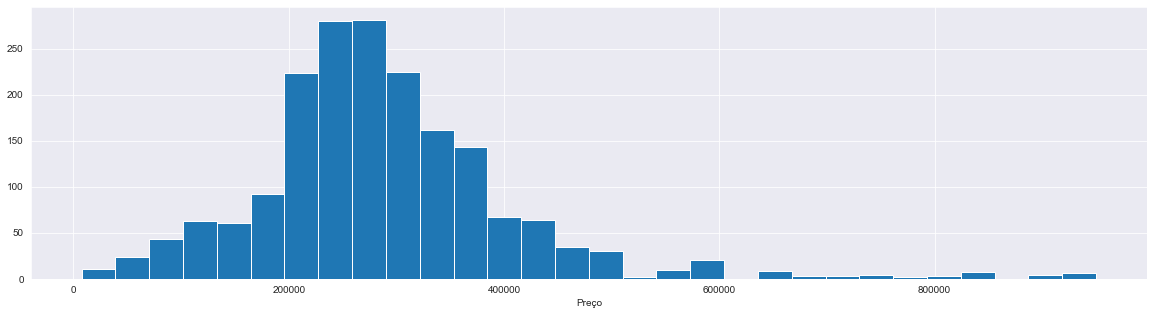

In [69]:
fig = plt.figure(figsize = (20,5))
sns.set_style('darkgrid')
data_imo_moradias['Preço'].hist(bins=30)
plt.xlabel('Preço')

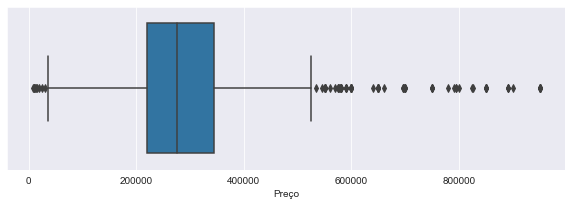

In [70]:
fig = plt.figure(figsize = (10,3))
sns.boxplot(x=data_imo_moradias['Preço'])

In [71]:
a_excluir = data_imo_moradias[(data_imo_moradias['Preço'] >= 500000)]
data_imo_moradias = data_imo_moradias.drop(a_excluir.index)
data_imo_moradias.index = np.arange(1, len(data_imo_moradias) + 1)
a_excluir.shape

(79, 20)

*Área útil*

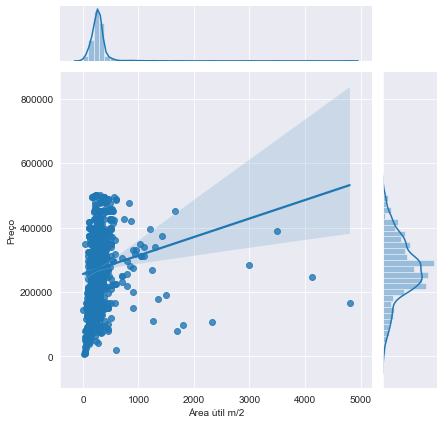

In [72]:
sns.jointplot(data_imo_moradias['Área útil m/2'], data_imo_moradias['Preço'], kind='reg')

In [73]:
a_excluir = data_imo_moradias[(data_imo_moradias['Área útil m/2'] >= 800)]
data_imo_moradias = data_imo_moradias.drop(a_excluir.index)
data_imo_moradias.index = np.arange(1, len(data_imo_moradias) + 1)
a_excluir.shape

(32, 20)

In [74]:
data_imo_moradias = data_imo_moradias.drop(data_imo_moradias[(data_imo_moradias['Área útil m/2']>500) & (data_imo_moradias['Preço']<100000)].index).reset_index(drop=True)

*Freguesia*

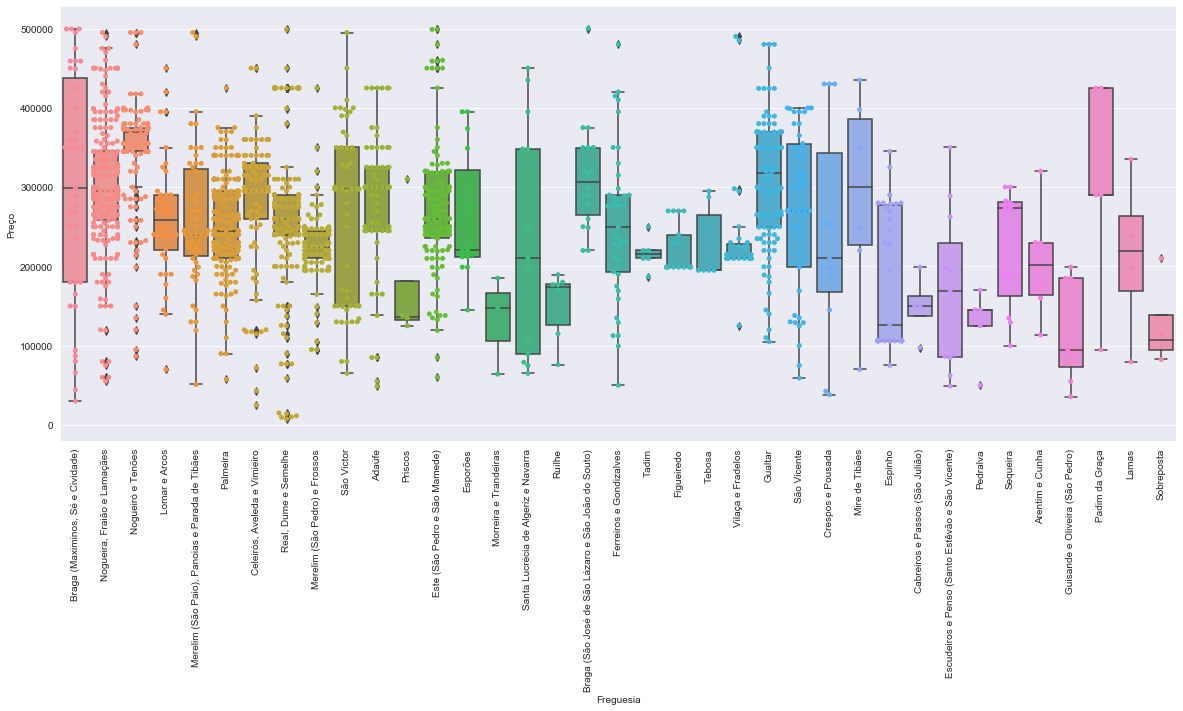

In [75]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)
sns.boxplot(data_imo_moradias['Freguesia'], data_imo_moradias['Preço'])
sns.swarmplot(data_imo_moradias['Freguesia'], data_imo_moradias['Preço'])
plt.show()

*Tipologia*

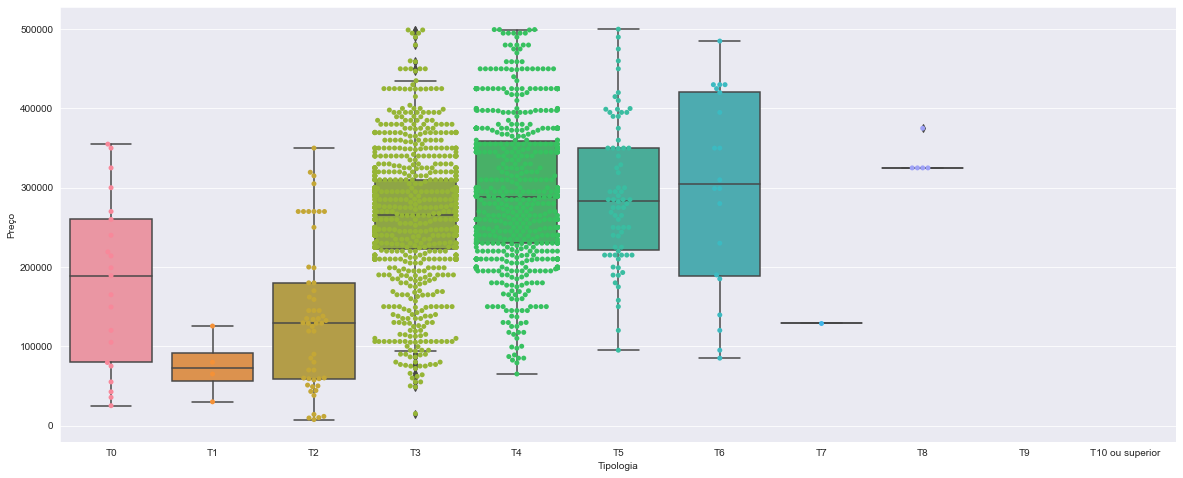

In [76]:
plt.figure(figsize=(20, 8))
sns.boxplot(data_imo_moradias['Tipologia'], data_imo_moradias['Preço'], order=['T0','T1','T2','T3','T4','T5','T6','T7','T8','T9','T10 ou superior'])
sns.swarmplot(data_imo_moradias['Tipologia'], data_imo_moradias['Preço'], order=['T0','T1','T2','T3','T4','T5','T6','T7','T8','T9','T10 ou superior'])
plt.show()

In [77]:
a_excluir = data_imo_moradias[(data_imo_moradias['Tipologia'] == 'T0') | (data_imo_moradias['Tipologia'] == 'T7') | (data_imo_moradias['Tipologia'] == 'T8') | (data_imo_moradias['Tipologia'] == 'T9') | (data_imo_moradias['Tipologia'] == 'T10 ou superior')]
data_imo_moradias = data_imo_moradias.drop(a_excluir.index)
data_imo_moradias.index = np.arange(1, len(data_imo_moradias) + 1)
a_excluir

,Id,Preço,Freguesia,Tipologia,Área útil m/2,Centro Cidade (km),Hospitais (km),Centros Saúde (km),Centro Comerciais (km),Escolas (km),Universidades (km),Estação de Comboios (km),Parques Industriais (km),Central Autocarros (km),Bancos (km),Correios (km),Parques e Zonas Verdes (km),Serviços Públicos (km),Policia Municipal (km),Farmácias (km)
0,14698254,149500,"Braga (Maximinos, Sé e Cividade)",T0,100.0,0.80,0.77,1.51,0.36,1.18,0.66,3.17,0.73,0.83,2.40,1.55,0.96,1.57,1.10,1.92
45,14421247,165000,Palmeira,T0,48.0,0.20,0.27,0.32,0.47,0.45,0.22,0.18,1.51,0.22,0.22,0.23,0.36,0.37,0.19,1.01
145,14927162,105000,Merelim (São Pedro) e Frossos,T0,282.0,0.24,0.22,0.29,0.50,0.41,0.25,0.25,0.54,0.27,0.45,0.25,2.19,0.37,0.24,0.98
148,15350558,129900,"Merelim (São Paio), Panoias e Parada de Tibães",T7,319.0,0.28,0.26,0.30,0.31,0.49,0.28,0.34,0.74,0.31,0.77,0.31,0.41,0.59,0.30,0.85
184,14968843,325000,"Real, Dume e Semelhe",T8,160.3,0.51,0.45,0.57,0.38,2.29,0.49,0.71,3.85,0.61,2.44,0.57,0.48,10.53,0.56,1.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,15255680,42500,Crespos e Pousada,T0,279.0,0.13,0.19,0.22,0.16,0.22,0.18,0.11,0.23,0.13,0.20,0.15,0.15,0.30,0.12,0.25
1557,10219711,35500,Guisande e Oliveira (São Pedro),T0,48.0,0.12,0.16,0.27,0.12,0.14,0.13,0.13,0.29,0.11,0.15,0.13,0.31,0.28,0.12,0.77
1597,15359419,214000,Nogueiró e Tenões,T0,232.0,0.33,0.47,0.72,0.61,0.74,0.76,0.25,0.21,0.30,0.68,0.66,0.71,0.48,0.30,0.77
1598,15359398,199000,Este (São Pedro e São Mamede),T0,212.0,0.22,0.39,0.62,0.32,0.62,0.45,0.18,0.20,0.21,0.65,0.32,0.33,0.56,0.20,0.66


### Encoding Str -> Int

In [78]:
data_imo_moradias_mlp = data_imo_moradias.copy()
data_imo_moradias = data_imo_moradias.drop(columns=['Id'])

In [79]:
#freguesia = pd.get_dummies(data_imo_moradias['Freguesia'])
#tipologia = pd.get_dummies(data_imo_moradias['Tipologia'])
#condicao = pd.get_dummies(data_imo_moradias['Condição'])

#data_imo_moradias.drop(['Freguesia','Tipologia','Condição'],axis=1,inplace=True)
#data_imo_moradias = pd.concat([data_imo_moradias,freguesia,tipologia,condicao],axis=1)
#data_imo_moradias

from sklearn.preprocessing import LabelEncoder
cat_features = data_imo_moradias.dtypes[data_imo_moradias.dtypes == "object"].index 
for c in cat_features.to_list():
    lbl = LabelEncoder() 
    lbl.fit(list(data_imo_moradias[c].values)) 
    data_imo_moradias[c] = lbl.transform(list(data_imo_moradias[c].values))

### Outliers Z-Score

In [80]:
z = np.abs(stats.zscore(data_imo_moradias))
threshold = 3
print(np.where(z > threshold))
# The first array contains the list of row numbers and second array respective column numbers

(array([   1,    2,    4,   12,   22,   23,   24,   27,   27,   27,   27,
         27,   38,   52,   62,   73,   73,   77,   78,   90,   91,   91,
        103,  106,  112,  118,  121,  126,  127,  128,  128,  129,  135,
        138,  138,  138,  143,  144,  147,  149,  150,  150,  151,  152,
        153,  154,  159,  160,  160,  160,  163,  169,  175,  176,  176,
        177,  178,  179,  180,  180,  180,  180,  185,  188,  191,  193,
        204,  206,  207,  208,  211,  214,  215,  218,  221,  221,  224,
        226,  233,  241,  241,  242,  242,  243,  243,  244,  244,  246,
        246,  253,  253,  259,  269,  271,  272,  272,  272,  287,  290,
        293,  293,  294,  294,  295,  295,  304,  310,  318,  320,  321,
        322,  324,  325,  346,  346,  352,  364,  364,  364,  364,  364,
        365,  365,  365,  365,  365,  367,  369,  371,  373,  378,  388,
        390,  395,  403,  404,  408,  408,  411,  411,  411,  415,  415,
        431,  431,  431,  431,  431,  436,  436,  

In [81]:
# Só fazer 1 vez
data_imo_moradias = data_imo_moradias[(np.abs(stats.zscore(data_imo_moradias)) < 3).all(axis=1)]
data_imo_moradias.index = np.arange(1, len(data_imo_moradias) + 1)
data_imo_moradias

#data_imo_moradias = data_imo_moradias[(np.abs(stats.zscore(data_imo_moradias['Preço'])) < 1)]
#data_imo_moradias.index = np.arange(1, len(data_imo_moradias) + 1)
#data_imo_moradias

,Preço,Freguesia,Tipologia,Área útil m/2,Centro Cidade (km),Hospitais (km),Centros Saúde (km),Centro Comerciais (km),Escolas (km),Universidades (km),Estação de Comboios (km),Parques Industriais (km),Central Autocarros (km),Bancos (km),Correios (km),Parques e Zonas Verdes (km),Serviços Públicos (km),Policia Municipal (km),Farmácias (km)
1,288000,21,3,240.0,0.37,0.44,0.73,0.84,1.06,0.70,0.27,0.21,0.33,0.96,0.88,0.86,0.53,0.33,1.10
2,350000,22,3,300.0,0.35,0.46,0.74,0.70,0.88,0.74,0.26,0.21,0.32,0.80,0.76,0.80,0.49,0.31,0.92
3,177000,16,3,198.0,0.28,0.58,0.67,0.28,0.45,0.38,0.33,0.50,0.26,0.53,0.38,0.54,0.57,0.31,0.80
4,270000,17,3,270.0,0.23,0.21,0.25,0.33,0.35,0.23,0.25,0.82,0.25,0.47,0.23,0.61,0.38,0.23,0.92
5,250000,21,3,300.0,0.34,0.71,0.67,0.95,0.62,0.47,0.29,0.20,0.29,0.66,1.93,2.19,0.47,0.33,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,225000,18,2,288.0,0.35,0.32,0.41,0.44,0.74,0.35,0.41,2.11,0.41,1.56,0.36,0.52,0.87,0.36,1.67
1423,195000,7,3,291.0,0.13,0.20,0.29,0.14,0.15,0.15,0.13,0.24,0.12,0.16,0.16,0.33,0.36,0.13,1.36
1424,320000,24,2,285.0,0.20,0.24,0.30,0.54,0.46,0.22,0.19,0.61,0.22,0.26,0.23,0.56,0.27,0.20,1.47
1425,240000,24,3,330.0,0.20,0.24,0.30,0.54,0.46,0.22,0.19,0.61,0.22,0.26,0.23,0.56,0.27,0.20,1.47


**Análise exploratória dos dados sem outliers**

----

## Skewness

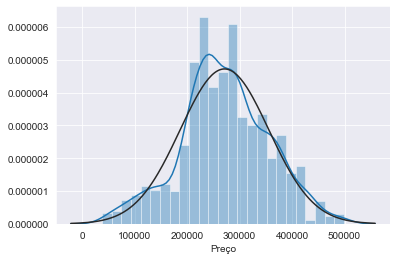

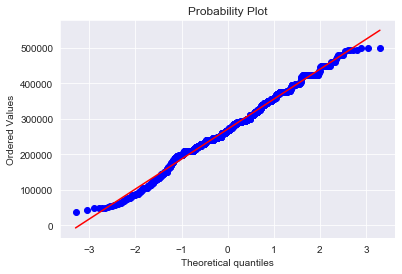

In [82]:
sns.distplot(data_imo_moradias['Preço'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(data_imo_moradias['Preço'], plot=plt)

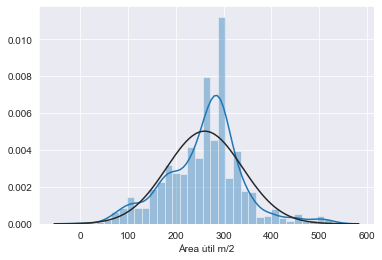

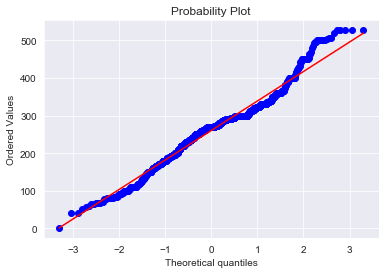

In [83]:
sns.distplot(data_imo_moradias['Área útil m/2'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(data_imo_moradias['Área útil m/2'], plot=plt)

## Dataset estruturado

In [84]:
data_imo_moradias

,Preço,Freguesia,Tipologia,Área útil m/2,Centro Cidade (km),Hospitais (km),Centros Saúde (km),Centro Comerciais (km),Escolas (km),Universidades (km),Estação de Comboios (km),Parques Industriais (km),Central Autocarros (km),Bancos (km),Correios (km),Parques e Zonas Verdes (km),Serviços Públicos (km),Policia Municipal (km),Farmácias (km)
1,288000,21,3,240.0,0.37,0.44,0.73,0.84,1.06,0.70,0.27,0.21,0.33,0.96,0.88,0.86,0.53,0.33,1.10
2,350000,22,3,300.0,0.35,0.46,0.74,0.70,0.88,0.74,0.26,0.21,0.32,0.80,0.76,0.80,0.49,0.31,0.92
3,177000,16,3,198.0,0.28,0.58,0.67,0.28,0.45,0.38,0.33,0.50,0.26,0.53,0.38,0.54,0.57,0.31,0.80
4,270000,17,3,270.0,0.23,0.21,0.25,0.33,0.35,0.23,0.25,0.82,0.25,0.47,0.23,0.61,0.38,0.23,0.92
5,250000,21,3,300.0,0.34,0.71,0.67,0.95,0.62,0.47,0.29,0.20,0.29,0.66,1.93,2.19,0.47,0.33,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,225000,18,2,288.0,0.35,0.32,0.41,0.44,0.74,0.35,0.41,2.11,0.41,1.56,0.36,0.52,0.87,0.36,1.67
1423,195000,7,3,291.0,0.13,0.20,0.29,0.14,0.15,0.15,0.13,0.24,0.12,0.16,0.16,0.33,0.36,0.13,1.36
1424,320000,24,2,285.0,0.20,0.24,0.30,0.54,0.46,0.22,0.19,0.61,0.22,0.26,0.23,0.56,0.27,0.20,1.47
1425,240000,24,3,330.0,0.20,0.24,0.30,0.54,0.46,0.22,0.19,0.61,0.22,0.26,0.23,0.56,0.27,0.20,1.47


## Modelos de regressão


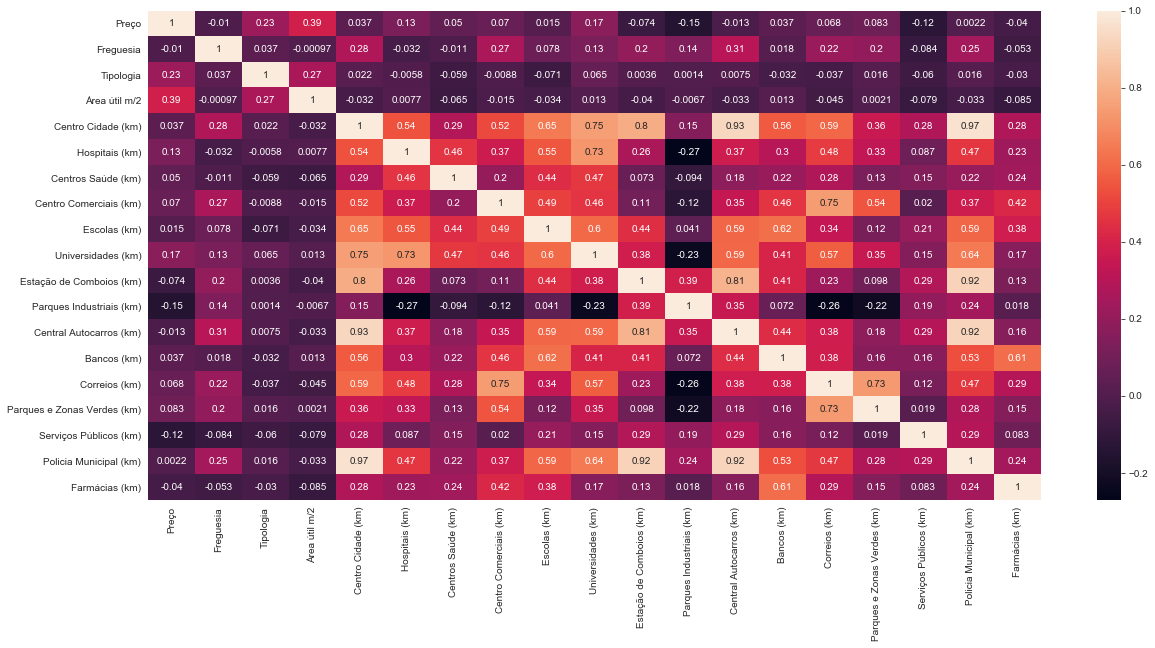

In [85]:
corr = data_imo_moradias.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr, annot=True)

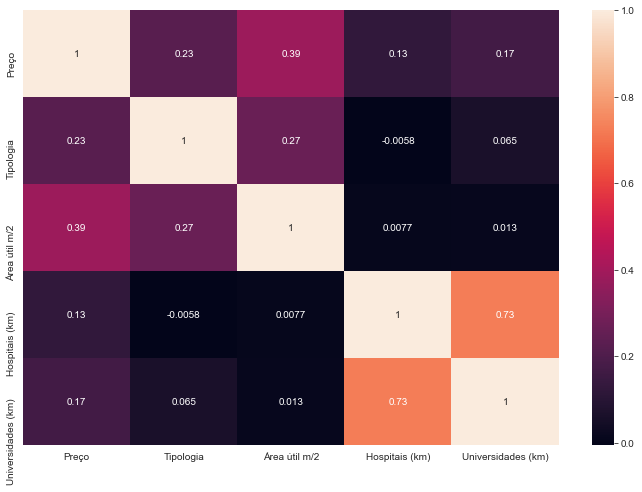

In [86]:
top_feature = corr.index[abs(corr['Preço']>0.1)]
plt.subplots(figsize=(12, 8))
top_corr = data_imo_moradias[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

**Features mais importantes relativamente ao target**

In [87]:
corr = data_imo_moradias.corr()
corr.sort_values(['Preço'], ascending=False, inplace=True)
corr.Preço

Preço                       1.000000
Área útil m/2               0.386214
Tipologia                   0.225361
Universidades (km)          0.168065
Hospitais (km)              0.127001
                              ...   
Central Autocarros (km)    -0.012844
Farmácias (km)             -0.039524
Estação de Comboios (km)   -0.073965
Serviços Públicos (km)     -0.121067
Parques Industriais (km)   -0.149914
Name: Preço, Length: 19, dtype: float64

## Train Test Split

In [88]:
y = data_imo_moradias['Preço']

In [89]:
X = data_imo_moradias.drop('Preço',axis=1)

In [90]:
X = X.values
y = y.values

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train.shape

(1140, 18)

### Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

**Funções auxiliares**

In [92]:
def printMetrics(y_test, predictions):
    print('MAE:', metrics.mean_absolute_error(y_test, predictions))
    print('MSE:', metrics.mean_squared_error(y_test, predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    
def drawPlots(y_test, predictions, model):
    plt.plot(predictions, color= 'red')
    plt.plot(y_test, color= 'green')
    plt.title("Valores dos preços previstos e reais")
    plt.xlabel("Row")
    plt.ylabel("Preço")
    plt.legend(['previsto', 'real'], loc='upper right')
    plt.show()

    plt.plot(y_test, color= 'green')
    plt.plot(predictions, color= 'red')
    plt.title("Valores dos preços previstos e reais")
    plt.xlabel("Row")
    plt.ylabel("Preço")
    plt.legend(['real', 'previsto'], loc='upper right')
    plt.show()

    plt.scatter(predictions, y_test, alpha=.25,color='b') #alpha helps to show overlapping data
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title(model)
    plt.show()
    
    sns.jointplot(predictions, y_test, kind='reg')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.show()

### Linear Regression

In [93]:
from sklearn import linear_model

# Compile the model
model = linear_model.LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)

# Metrics
printMetrics(y_test, predictions)

MAE: 58803.73859643091
MSE: 5656685284.164266
RMSE: 75210.93859382601


In [94]:
print("Predict value " + str(predictions[50]))
print("Real value " + str(y_test[50]))

Predict value 250878.10122610728
Real value 210000


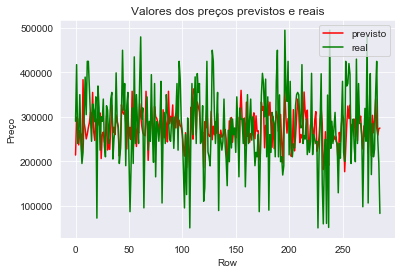

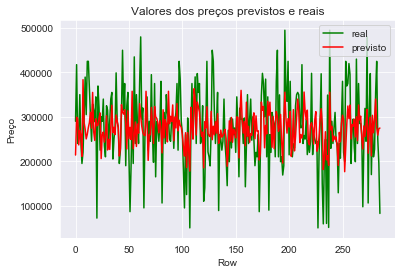

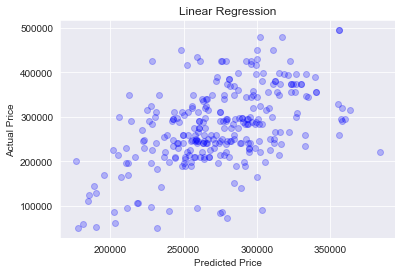

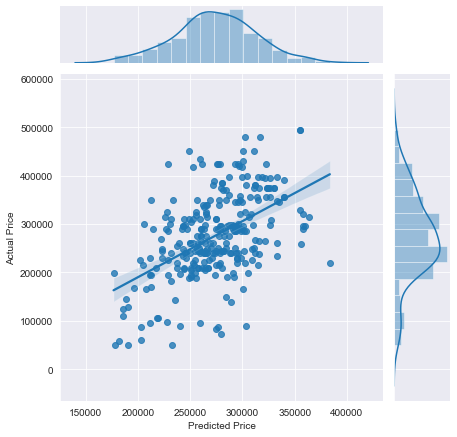

In [95]:
drawPlots(y_test, predictions, 'Linear Regression')

### RandomForestRegression

In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Compile the model
rf = RandomForestRegressor(random_state = 42)


#Hyperparamater tuning using RanodomSearchCV
param_grid = { 
    'n_estimators': [int(x) for x in np.linspace(start = 600, stop = 1300, num = 10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [12,14,16],
    'min_samples_split' : [2, 4, 6],
    'min_samples_leaf' : [1, 2]
}
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)


# Fit the model
#rf.fit(X_train,y_train)

# Predict
#predictions = rf.predict(X_test)
predictions = grid_search.predict(X_test)

# Metrics
printMetrics(y_test, predictions)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 63.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 78.5min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 80.9min finished


{'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 1300}
0.3822323925277313
MAE: 46231.678187626494
MSE: 4127766959.8813953
RMSE: 64247.700035731985


In [97]:
print("Predict value " + str(predictions[50]))
print("Real value " + str(y_test[50]))

Predict value 119392.79410994989
Real value 210000


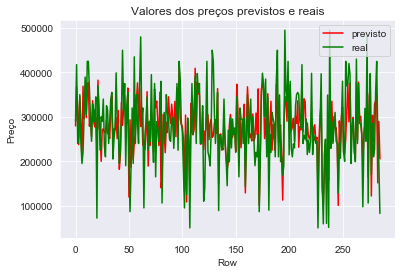

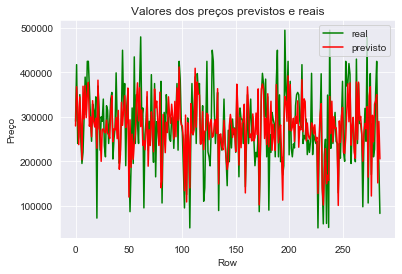

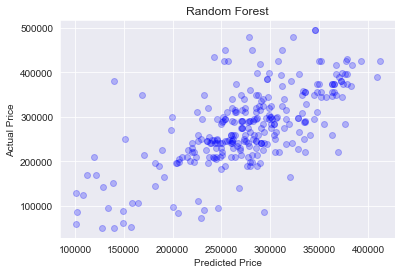

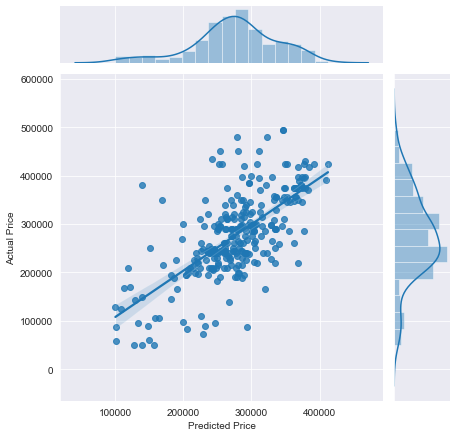

In [98]:
drawPlots(y_test, predictions, 'Random Forest')

### Standard Machine Learning Models (TEMPORÁRIO)

In [99]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

In [100]:
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [101]:
results = evaluate(X_train, X_test, y_train, y_test)

In [102]:
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

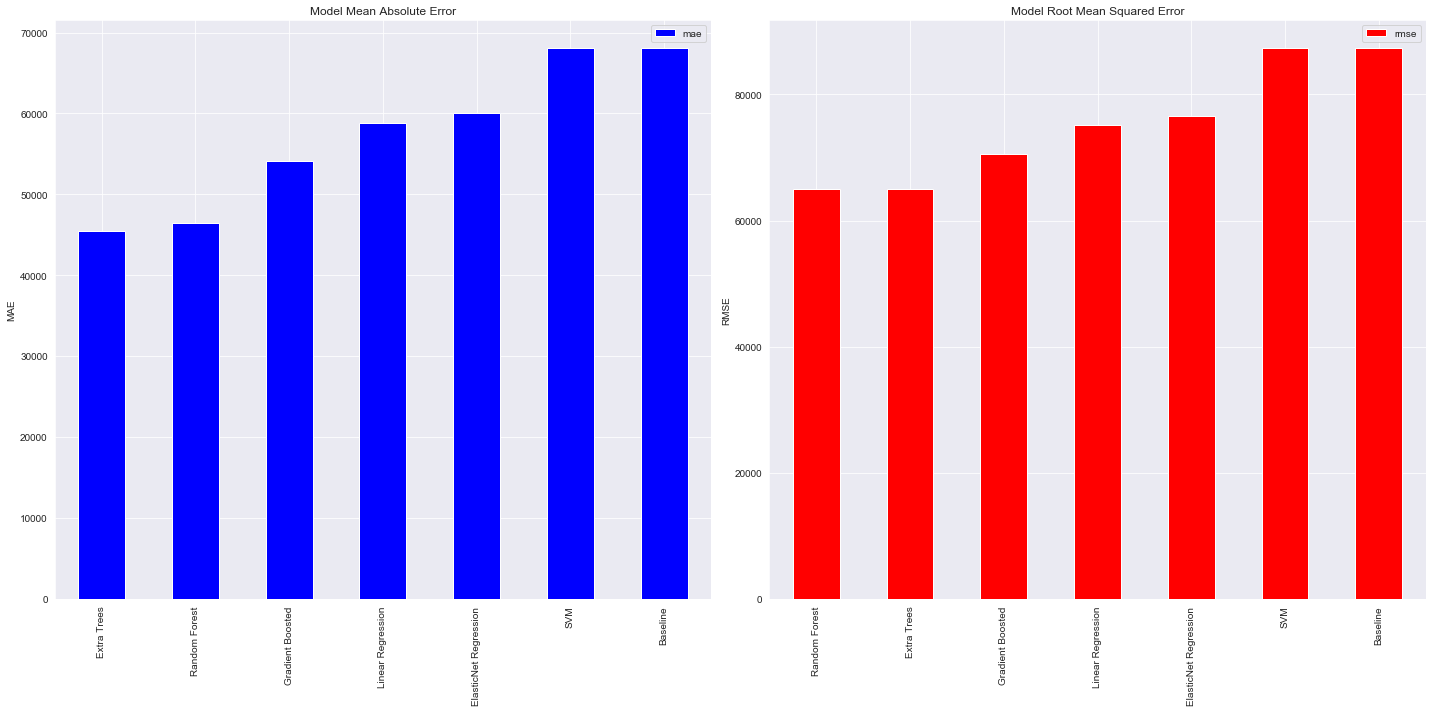

In [103]:
fig = plt.figure(figsize = (20,10))
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE');

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE');

plt.tight_layout()

### Ridge Regression

**GridSearchCV**

In [104]:
from sklearn.linear_model import Ridge

# Parameters
params_ridge ={
        'alpha':[0.5,0.75,1,1.25,1.5],
        'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        'max_iter':[500,750,1000,1250,1500]
        }

# Compile the model
ridge = Ridge()
ridge_grid = GridSearchCV(estimator = ridge, param_grid = params_ridge, cv = 5, n_jobs = -1, verbose = 2)

# Fit the model
ridge_grid.fit(X_train, y_train)
print(ridge_grid.best_params_)
print(ridge_grid.best_score_)

# Predict
predictions = ridge_grid.predict(X_test)

# Metrics
printMetrics(y_test, predictions)

Fitting 5 folds for each of 175 candidates, totalling 875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   10.1s


{'alpha': 0.5, 'max_iter': 500, 'solver': 'auto'}
0.17257810513076402
MAE: 58668.449317199316
MSE: 5643428609.07072
RMSE: 75122.75693204236


[Parallel(n_jobs=-1)]: Done 875 out of 875 | elapsed:   15.9s finished


In [105]:
print("Predict value " + str(predictions[50]))
print("Real value " + str(y_test[50]))

Predict value 252865.22644703425
Real value 210000


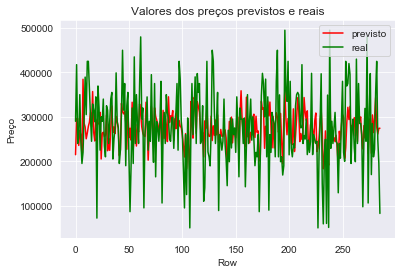

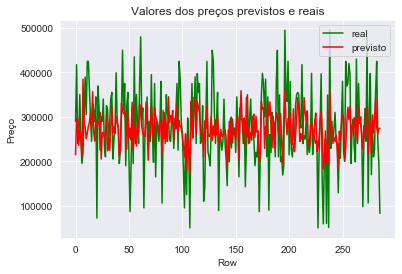

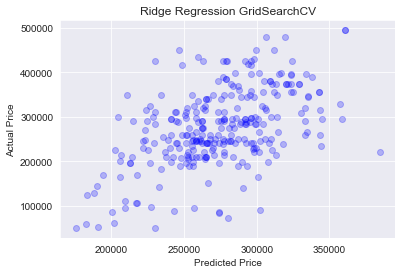

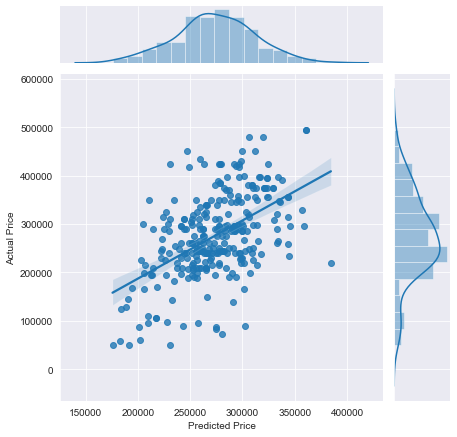

In [106]:
drawPlots(y_test, predictions, 'Ridge Regression GridSearchCV')

### GradientBoostingRegressor

**GridSearchCV**

In [107]:
from sklearn.ensemble import GradientBoostingRegressor

# Parameters
params_gbr={
    'loss':['ls', 'lad', 'huber', 'quantile'],
    'n_estimators':[15,25,50,100],
    'min_samples_split':[1,2,3],
    'max_depth':[4,6,8,10],
    'max_features':['auto', 'sqrt', 'log2']
}

# Compile the model
gbr = GradientBoostingRegressor()
gbr_grid = GridSearchCV(estimator=gbr, param_grid=params_gbr, cv=5, n_jobs=-1, verbose=2)

# Fit the model
gbr_grid.fit(X_train, y_train)
print(gbr_grid.best_params_)
print(gbr_grid.best_score_)

# Predict
predictions = gbr_grid.predict(X_test)

# Metrics
printMetrics(y_test, predictions)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 1022 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 1380 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1913 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2462 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  8.0min finished


{'loss': 'huber', 'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
0.3687854101042416
MAE: 47955.07809253861
MSE: 4388121705.855677
RMSE: 66242.89928630597


In [108]:
print("Predict value " + str(predictions[50]))
print("Real value " + str(y_test[50]))

Predict value 223200.78450435455
Real value 210000


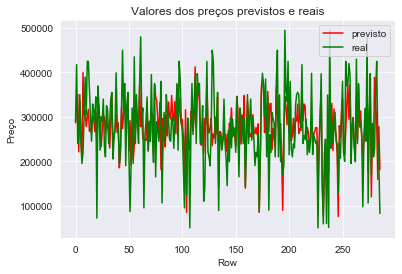

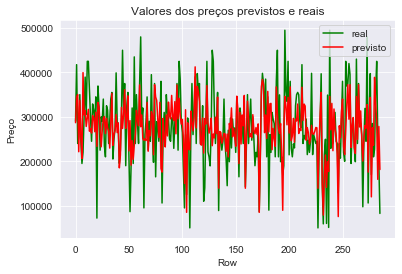

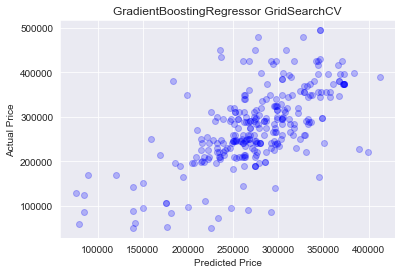

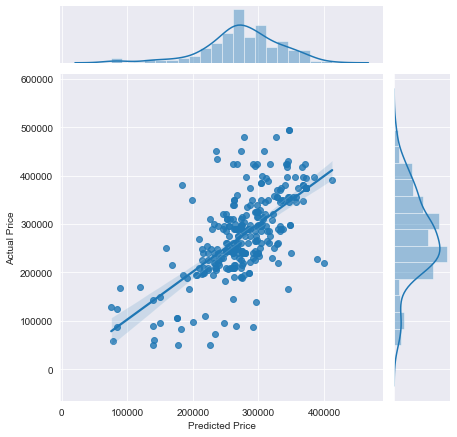

In [109]:
drawPlots(y_test, predictions, 'GradientBoostingRegressor GridSearchCV')

### Decision Tree Regression with AdaBoost

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

rng = np.random.RandomState(1)

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

# Metrics
printMetrics(y_2, y)

MAE: 54708.0326707167
MSE: 4385318090.940463
RMSE: 66221.73427916595


In [111]:
print("Predict value " + str(y_1[60]))
print("Real value " + str(y[60]))

Predict value 298087.68846153846
Real value 215000


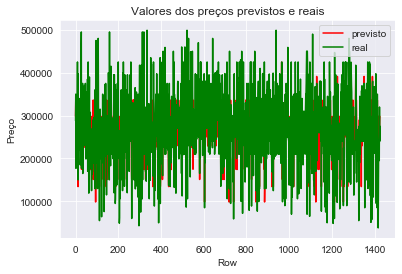

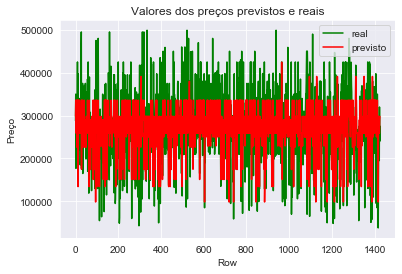

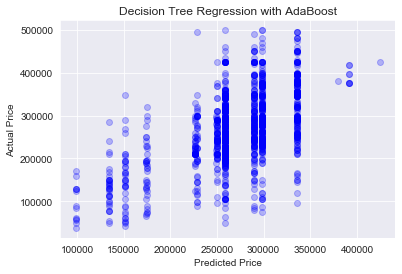

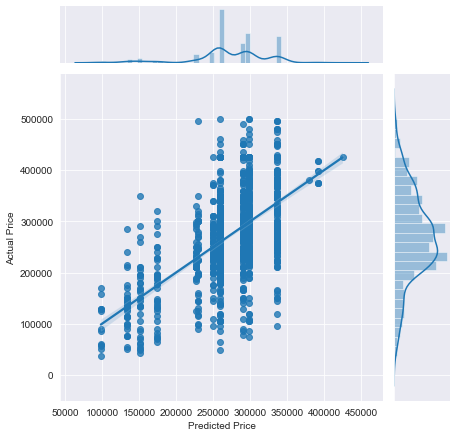

In [112]:
drawPlots(y, y_1, 'Decision Tree Regression with AdaBoost')

### LGBM & ANN - Data Preparation

In [113]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [114]:
data_imo_moradias_mlp

,Id,Preço,Freguesia,Tipologia,Área útil m/2,Centro Cidade (km),Hospitais (km),Centros Saúde (km),Centro Comerciais (km),Escolas (km),Universidades (km),Estação de Comboios (km),Parques Industriais (km),Central Autocarros (km),Bancos (km),Correios (km),Parques e Zonas Verdes (km),Serviços Públicos (km),Policia Municipal (km),Farmácias (km)
1,14979186,288000,"Nogueira, Fraião e Lamaçães",T4,240.0,0.37,0.44,0.73,0.84,1.06,0.70,0.27,0.21,0.33,0.96,0.88,0.86,0.53,0.33,1.10
2,14765501,315000,"Nogueira, Fraião e Lamaçães",T3,224.0,0.35,3.18,0.58,0.55,0.50,0.54,0.33,0.25,0.30,0.46,0.76,0.66,0.43,0.36,2.39
3,14967643,298000,"Nogueira, Fraião e Lamaçães",T3,168.5,0.35,3.18,0.58,0.55,0.50,0.54,0.33,0.25,0.30,0.46,0.76,0.66,0.43,0.36,2.39
4,13675795,350000,Nogueiró e Tenões,T4,300.0,0.35,0.46,0.74,0.70,0.88,0.74,0.26,0.21,0.32,0.80,0.76,0.80,0.49,0.31,0.92
5,15222034,180000,"Nogueira, Fraião e Lamaçães",T4,292.0,0.40,0.58,0.94,1.99,0.89,0.54,0.32,0.21,0.34,1.03,8.55,1.28,0.61,0.38,1.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,15352138,195000,Escudeiros e Penso (Santo Estêvão e São Vicente),T4,291.0,0.13,0.20,0.29,0.14,0.15,0.15,0.13,0.24,0.12,0.16,0.16,0.33,0.36,0.13,1.36
1734,13184134,320000,Palmeira,T3,285.0,0.20,0.24,0.30,0.54,0.46,0.22,0.19,0.61,0.22,0.26,0.23,0.56,0.27,0.20,1.47
1735,14580112,240000,Palmeira,T4,330.0,0.20,0.24,0.30,0.54,0.46,0.22,0.19,0.61,0.22,0.26,0.23,0.56,0.27,0.20,1.47
1736,15521254,275000,Nogueiró e Tenões,T3,165.0,0.30,0.42,0.59,0.57,0.64,0.62,0.23,0.20,0.28,0.61,0.58,0.60,0.56,0.28,0.66


In [115]:
data_imo_moradias_mlp = pd.get_dummies(data_imo_moradias_mlp)

In [116]:
data_imo_moradias_mlp.shape

(1737, 61)

In [117]:
y_mlp = data_imo_moradias_mlp['Preço']
X_mlp = data_imo_moradias_mlp.drop('Preço',axis=1)

from sklearn.model_selection import train_test_split
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X, y, test_size=0.2, random_state=7)
X_train_mlp.shape

(1140, 18)

In [118]:
y_train_mlp = pd.DataFrame({'Preço':y_train}) 

In [119]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_y = StandardScaler()
sc_X = StandardScaler()
y_train_mlp = sc_y.fit_transform(y_train_mlp)
X_train_mlp = sc_X.fit_transform(X_train_mlp)
X_test_mlp = sc_X.transform(X_test_mlp)

In [120]:
y_train_mlp.shape

(1140, 1)

In [121]:
flat_y_mlp = y_train_mlp.flatten()
flat_y_mlp.shape

(1140,)

### LGBM

In [122]:
import lightgbm as lgb

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train_mlp, flat_y_mlp)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')

# train
gbm = lgb.train(params, lgb_train, num_boost_round=250)

# predict
lgbm_prediction_tr = gbm.predict(X_train_mlp, num_iteration=gbm.best_iteration)
lgbm_prediction_te = gbm.predict(X_test_mlp, num_iteration=gbm.best_iteration)

Starting training...


In [123]:
train = lgbm_prediction_tr
test = lgbm_prediction_te

In [124]:
y_pred_mlp = sc_y.inverse_transform(lgbm_prediction_te)

In [125]:
y_pred_mlp

array([288553.52070455, 372319.62149001, 329870.92237479, 243927.15146369,
       342702.73480592, 296167.92513072, 182459.0822754 , 372323.09234165,
       290945.67828177, 386282.40895048, 315317.62037331, 375411.10501056,
       389255.52116184, 260803.64294976, 250035.02874271, 246563.43787056,
       383121.77701459, 272148.16902106, 290163.36501762, 288827.67472745,
       219654.37988365, 368940.20018833, 302093.39562273, 266949.59048552,
       191787.30204461, 272717.60226225, 257401.0585011 , 259728.42130546,
       253514.56229807, 288922.67531445, 267881.52160893, 243741.39957098,
       267421.86084386, 311935.96342234, 347202.83233464, 246136.56011671,
       282405.4847716 , 272717.60226225, 277893.60852264, 255214.23719755,
       311935.96342234, 196720.26742318, 203816.43304382, 332128.74836789,
       268665.24518415, 319738.49778808, 364812.28183303, 265617.67871475,
       293499.40221321, 362182.49385776, 153760.99558201, 234894.19861972,
       173292.37085329, 2

In [126]:
# Metrics
printMetrics(y_test, y_pred_mlp)

MAE: 48017.98566188882
MSE: 4432913602.926266
RMSE: 66580.12918976852


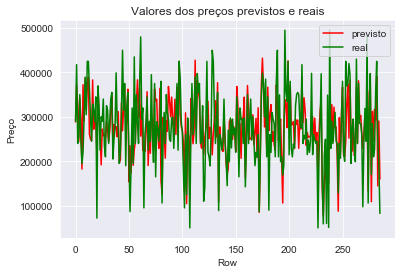

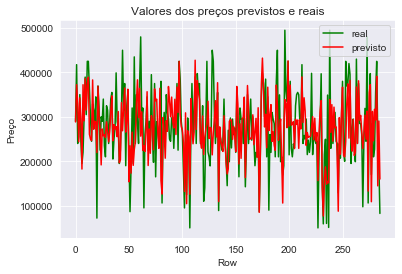

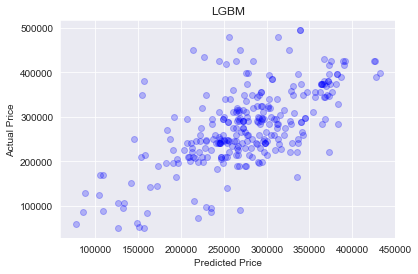

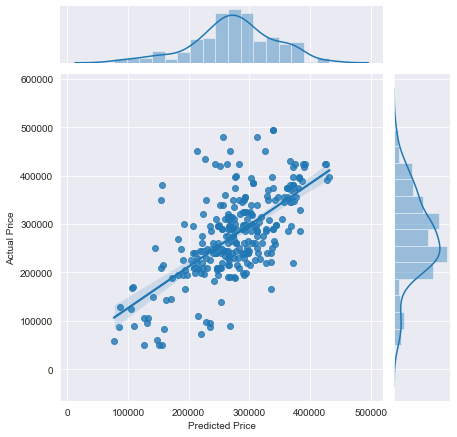

In [127]:
drawPlots(y_test, y_pred_mlp, 'LGBM')

### ANN

In [128]:
def print_history_mae(history):
    print(history.history.keys())
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def print_history_loss(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [129]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [130]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(18, activation='relu', input_shape=[X_train.shape[1]]))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

In [131]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                608       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)               

In [132]:
model_filepath = 'min_vl_model.h5'
checkpoint = ModelCheckpoint(model_filepath, monitor = 'val_mae', verbose=1, save_best_only = True, mode='min')

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=3000, callbacks=[checkpoint])

model.load_weights(model_filepath)


Train on 912 samples, validate on 228 samples
Epoch 1/3000
912/912 [==============================] - 1s 1ms/step - loss: 269947.6552 - mae: 269947.6250 - val_loss: 271558.2516 - val_mae: 271558.2188

Epoch 00001: val_mae improved from inf to 271558.21875, saving model to min_vl_model.h5
Epoch 2/3000
912/912 [==============================] - 0s 141us/step - loss: 269946.7961 - mae: 269946.7812 - val_loss: 271557.2928 - val_mae: 271557.2812

Epoch 00002: val_mae improved from 271558.21875 to 271557.28125, saving model to min_vl_model.h5
Epoch 3/3000
912/912 [==============================] - 0s 129us/step - loss: 269945.7259 - mae: 269945.7500 - val_loss: 271556.0696 - val_mae: 271556.0625

Epoch 00003: val_mae improved from 271557.28125 to 271556.06250, saving model to min_vl_model.h5
Epoch 4/3000
912/912 [==============================] - 0s 131us/step - loss: 269944.4339 - mae: 269944.4375 - val_loss: 271554.6294 - val_mae: 271554.6250

Epoch 00004: val_mae improved from 271556.062

912/912 [==============================] - 0s 124us/step - loss: 269818.3827 - mae: 269818.3438 - val_loss: 271424.8838 - val_mae: 271424.9062

Epoch 00032: val_mae improved from 271432.56250 to 271424.90625, saving model to min_vl_model.h5
Epoch 33/3000
912/912 [==============================] - 0s 119us/step - loss: 269810.7185 - mae: 269810.7188 - val_loss: 271417.6096 - val_mae: 271417.5938

Epoch 00033: val_mae improved from 271424.90625 to 271417.59375, saving model to min_vl_model.h5
Epoch 34/3000
912/912 [==============================] - 0s 120us/step - loss: 269802.8361 - mae: 269802.8125 - val_loss: 271409.8514 - val_mae: 271409.8750

Epoch 00034: val_mae improved from 271417.59375 to 271409.87500, saving model to min_vl_model.h5
Epoch 35/3000
912/912 [==============================] - 0s 125us/step - loss: 269794.7357 - mae: 269794.7188 - val_loss: 271401.1653 - val_mae: 271401.1562

Epoch 00035: val_mae improved from 271409.87500 to 271401.15625, saving model to min_vl_mod

912/912 [==============================] - 0s 118us/step - loss: 269465.5417 - mae: 269465.5625 - val_loss: 271069.3492 - val_mae: 271069.3750

Epoch 00064: val_mae improved from 271084.37500 to 271069.37500, saving model to min_vl_model.h5
Epoch 65/3000
912/912 [==============================] - 0s 118us/step - loss: 269450.9370 - mae: 269450.9688 - val_loss: 271055.3783 - val_mae: 271055.3750

Epoch 00065: val_mae improved from 271069.37500 to 271055.37500, saving model to min_vl_model.h5
Epoch 66/3000
912/912 [==============================] - 0s 129us/step - loss: 269436.1212 - mae: 269436.0938 - val_loss: 271039.7763 - val_mae: 271039.7812

Epoch 00066: val_mae improved from 271055.37500 to 271039.78125, saving model to min_vl_model.h5
Epoch 67/3000
912/912 [==============================] - 0s 120us/step - loss: 269421.0916 - mae: 269421.1250 - val_loss: 271025.1513 - val_mae: 271025.1562

Epoch 00067: val_mae improved from 271039.78125 to 271025.15625, saving model to min_vl_mod

912/912 [==============================] - 0s 123us/step - loss: 268891.1606 - mae: 268891.1875 - val_loss: 270488.3925 - val_mae: 270488.3750

Epoch 00096: val_mae improved from 270508.37500 to 270488.37500, saving model to min_vl_model.h5
Epoch 97/3000
912/912 [==============================] - 0s 121us/step - loss: 268869.6404 - mae: 268869.6562 - val_loss: 270466.9559 - val_mae: 270466.9375

Epoch 00097: val_mae improved from 270488.37500 to 270466.93750, saving model to min_vl_model.h5
Epoch 98/3000
912/912 [==============================] - 0s 116us/step - loss: 268847.9090 - mae: 268847.9062 - val_loss: 270446.3407 - val_mae: 270446.3438

Epoch 00098: val_mae improved from 270466.93750 to 270446.34375, saving model to min_vl_model.h5
Epoch 99/3000
912/912 [==============================] - 0s 124us/step - loss: 268825.9660 - mae: 268826.0000 - val_loss: 270423.9523 - val_mae: 270423.9375

Epoch 00099: val_mae improved from 270446.34375 to 270423.93750, saving model to min_vl_mod

912/912 [==============================] - 0s 122us/step - loss: 268095.6075 - mae: 268095.6562 - val_loss: 269689.0170 - val_mae: 269689.0312

Epoch 00128: val_mae improved from 269719.71875 to 269689.03125, saving model to min_vl_model.h5
Epoch 129/3000
912/912 [==============================] - 0s 119us/step - loss: 268067.1870 - mae: 268067.1875 - val_loss: 269660.5047 - val_mae: 269660.5000

Epoch 00129: val_mae improved from 269689.03125 to 269660.50000, saving model to min_vl_model.h5
Epoch 130/3000
912/912 [==============================] - 0s 119us/step - loss: 268038.5471 - mae: 268038.5625 - val_loss: 269629.8328 - val_mae: 269629.8125

Epoch 00130: val_mae improved from 269660.50000 to 269629.81250, saving model to min_vl_model.h5
Epoch 131/3000
912/912 [==============================] - 0s 120us/step - loss: 268009.6941 - mae: 268009.6875 - val_loss: 269604.0641 - val_mae: 269604.0625

Epoch 00131: val_mae improved from 269629.81250 to 269604.06250, saving model to min_vl_

912/912 [==============================] - 0s 120us/step - loss: 267079.0828 - mae: 267079.0625 - val_loss: 268664.2897 - val_mae: 268664.2812

Epoch 00160: val_mae improved from 268699.90625 to 268664.28125, saving model to min_vl_model.h5
Epoch 161/3000
912/912 [==============================] - 0s 116us/step - loss: 267043.7549 - mae: 267043.7812 - val_loss: 268629.7111 - val_mae: 268629.7500

Epoch 00161: val_mae improved from 268664.28125 to 268629.75000, saving model to min_vl_model.h5
Epoch 162/3000
912/912 [==============================] - 0s 115us/step - loss: 267008.2215 - mae: 267008.2500 - val_loss: 268592.4726 - val_mae: 268592.4688

Epoch 00162: val_mae improved from 268629.75000 to 268592.46875, saving model to min_vl_model.h5
Epoch 163/3000
912/912 [==============================] - 0s 126us/step - loss: 266972.4627 - mae: 266972.4688 - val_loss: 268556.3887 - val_mae: 268556.3750

Epoch 00163: val_mae improved from 268592.46875 to 268556.37500, saving model to min_vl_

912/912 [==============================] - 0s 126us/step - loss: 265841.5584 - mae: 265841.5625 - val_loss: 267427.8372 - val_mae: 267427.8438

Epoch 00192: val_mae improved from 267468.09375 to 267427.84375, saving model to min_vl_model.h5
Epoch 193/3000
912/912 [==============================] - 0s 121us/step - loss: 265799.3273 - mae: 265799.3438 - val_loss: 267385.6968 - val_mae: 267385.6562

Epoch 00193: val_mae improved from 267427.84375 to 267385.65625, saving model to min_vl_model.h5
Epoch 194/3000
912/912 [==============================] - 0s 124us/step - loss: 265756.8887 - mae: 265756.9062 - val_loss: 267341.3618 - val_mae: 267341.3438

Epoch 00194: val_mae improved from 267385.65625 to 267341.34375, saving model to min_vl_model.h5
Epoch 195/3000
912/912 [==============================] - 0s 128us/step - loss: 265714.2371 - mae: 265714.2500 - val_loss: 267300.4093 - val_mae: 267300.4062

Epoch 00195: val_mae improved from 267341.34375 to 267300.40625, saving model to min_vl_

912/912 [==============================] - 0s 116us/step - loss: 264383.4693 - mae: 264383.4688 - val_loss: 265985.3898 - val_mae: 265985.3750

Epoch 00224: val_mae improved from 266026.12500 to 265985.37500, saving model to min_vl_model.h5
Epoch 225/3000
912/912 [==============================] - 0s 120us/step - loss: 264334.3399 - mae: 264334.3438 - val_loss: 265933.0258 - val_mae: 265933.0312

Epoch 00225: val_mae improved from 265985.37500 to 265933.03125, saving model to min_vl_model.h5
Epoch 226/3000
912/912 [==============================] - 0s 116us/step - loss: 264285.0025 - mae: 264285.0000 - val_loss: 265882.7341 - val_mae: 265882.7500

Epoch 00226: val_mae improved from 265933.03125 to 265882.75000, saving model to min_vl_model.h5
Epoch 227/3000
912/912 [==============================] - 0s 118us/step - loss: 264235.4386 - mae: 264235.4688 - val_loss: 265825.7166 - val_mae: 265825.7500

Epoch 00227: val_mae improved from 265882.75000 to 265825.75000, saving model to min_vl_

912/912 [==============================] - 0s 117us/step - loss: 262704.3298 - mae: 262704.3438 - val_loss: 264292.2508 - val_mae: 264292.2188

Epoch 00256: val_mae improved from 264361.50000 to 264292.21875, saving model to min_vl_model.h5
Epoch 257/3000
912/912 [==============================] - 0s 120us/step - loss: 262648.2977 - mae: 262648.2812 - val_loss: 264241.9367 - val_mae: 264241.9375

Epoch 00257: val_mae improved from 264292.21875 to 264241.93750, saving model to min_vl_model.h5
Epoch 258/3000
912/912 [==============================] - 0s 117us/step - loss: 262592.0510 - mae: 262592.0625 - val_loss: 264179.8906 - val_mae: 264179.9062

Epoch 00258: val_mae improved from 264241.93750 to 264179.90625, saving model to min_vl_model.h5
Epoch 259/3000
912/912 [==============================] - 0s 119us/step - loss: 262535.5833 - mae: 262535.5625 - val_loss: 264124.8602 - val_mae: 264124.8750

Epoch 00259: val_mae improved from 264179.90625 to 264124.87500, saving model to min_vl_

912/912 [==============================] - 0s 121us/step - loss: 260804.1754 - mae: 260804.1719 - val_loss: 262401.6691 - val_mae: 262401.6875

Epoch 00288: val_mae improved from 262453.81250 to 262401.68750, saving model to min_vl_model.h5
Epoch 289/3000
912/912 [==============================] - 0s 118us/step - loss: 260741.2346 - mae: 260741.2656 - val_loss: 262328.8424 - val_mae: 262328.8750

Epoch 00289: val_mae improved from 262401.68750 to 262328.87500, saving model to min_vl_model.h5
Epoch 290/3000
912/912 [==============================] - 0s 118us/step - loss: 260678.0811 - mae: 260678.0938 - val_loss: 262261.6672 - val_mae: 262261.6562

Epoch 00290: val_mae improved from 262328.87500 to 262261.65625, saving model to min_vl_model.h5
Epoch 291/3000
912/912 [==============================] - 0s 134us/step - loss: 260614.7078 - mae: 260614.7188 - val_loss: 262184.8558 - val_mae: 262184.8750

Epoch 00291: val_mae improved from 262261.65625 to 262184.87500, saving model to min_vl_

912/912 [==============================] - 0s 120us/step - loss: 258682.9216 - mae: 258682.9062 - val_loss: 260260.5285 - val_mae: 260260.5312

Epoch 00320: val_mae improved from 260318.03125 to 260260.53125, saving model to min_vl_model.h5
Epoch 321/3000
912/912 [==============================] - 0s 115us/step - loss: 258613.0718 - mae: 258613.0312 - val_loss: 260188.7788 - val_mae: 260188.7969

Epoch 00321: val_mae improved from 260260.53125 to 260188.79688, saving model to min_vl_model.h5
Epoch 322/3000
912/912 [==============================] - 0s 116us/step - loss: 258543.0030 - mae: 258543.0156 - val_loss: 260107.8706 - val_mae: 260107.8750

Epoch 00322: val_mae improved from 260188.79688 to 260107.87500, saving model to min_vl_model.h5
Epoch 323/3000
912/912 [==============================] - 0s 122us/step - loss: 258472.7215 - mae: 258472.7344 - val_loss: 260026.2421 - val_mae: 260026.2344

Epoch 00323: val_mae improved from 260107.87500 to 260026.23438, saving model to min_vl_

912/912 [==============================] - 0s 122us/step - loss: 256340.8021 - mae: 256340.7969 - val_loss: 257923.6708 - val_mae: 257923.6875

Epoch 00352: val_mae improved from 258009.59375 to 257923.68750, saving model to min_vl_model.h5
Epoch 353/3000
912/912 [==============================] - 0s 120us/step - loss: 256264.1195 - mae: 256264.0938 - val_loss: 257857.0329 - val_mae: 257857.0312

Epoch 00353: val_mae improved from 257923.68750 to 257857.03125, saving model to min_vl_model.h5
Epoch 354/3000
912/912 [==============================] - 0s 121us/step - loss: 256187.2155 - mae: 256187.2031 - val_loss: 257739.3462 - val_mae: 257739.3281

Epoch 00354: val_mae improved from 257857.03125 to 257739.32812, saving model to min_vl_model.h5
Epoch 355/3000
912/912 [==============================] - 0s 127us/step - loss: 256110.0987 - mae: 256110.0938 - val_loss: 257688.2048 - val_mae: 257688.2031

Epoch 00355: val_mae improved from 257739.32812 to 257688.20312, saving model to min_vl_

912/912 [==============================] - 0s 119us/step - loss: 253779.9868 - mae: 253779.9688 - val_loss: 255366.6623 - val_mae: 255366.6719

Epoch 00384: val_mae improved from 255454.00000 to 255366.67188, saving model to min_vl_model.h5
Epoch 385/3000
912/912 [==============================] - 0s 115us/step - loss: 253696.4073 - mae: 253696.3906 - val_loss: 255279.6867 - val_mae: 255279.6875

Epoch 00385: val_mae improved from 255366.67188 to 255279.68750, saving model to min_vl_model.h5
Epoch 386/3000
912/912 [==============================] - 0s 116us/step - loss: 253612.6102 - mae: 253612.5938 - val_loss: 255185.3750 - val_mae: 255185.3750

Epoch 00386: val_mae improved from 255279.68750 to 255185.37500, saving model to min_vl_model.h5
Epoch 387/3000
912/912 [==============================] - 0s 118us/step - loss: 253528.5962 - mae: 253528.5938 - val_loss: 255089.1014 - val_mae: 255089.1094

Epoch 00387: val_mae improved from 255185.37500 to 255089.10938, saving model to min_vl_

912/912 [==============================] - 0s 117us/step - loss: 250998.5285 - mae: 250998.5312 - val_loss: 252551.9271 - val_mae: 252551.9375

Epoch 00416: val_mae improved from 252664.26562 to 252551.93750, saving model to min_vl_model.h5
Epoch 417/3000
912/912 [==============================] - 0s 122us/step - loss: 250908.0598 - mae: 250908.0625 - val_loss: 252468.5803 - val_mae: 252468.5938

Epoch 00417: val_mae improved from 252551.93750 to 252468.59375, saving model to min_vl_model.h5
Epoch 418/3000
912/912 [==============================] - 0s 116us/step - loss: 250817.3624 - mae: 250817.4062 - val_loss: 252397.8470 - val_mae: 252397.8438

Epoch 00418: val_mae improved from 252468.59375 to 252397.84375, saving model to min_vl_model.h5
Epoch 419/3000
912/912 [==============================] - 0s 125us/step - loss: 250726.4531 - mae: 250726.4375 - val_loss: 252302.0134 - val_mae: 252302.0156

Epoch 00419: val_mae improved from 252397.84375 to 252302.01562, saving model to min_vl_

912/912 [==============================] - 0s 121us/step - loss: 247996.4268 - mae: 247996.4375 - val_loss: 249577.6658 - val_mae: 249577.6719

Epoch 00448: val_mae improved from 249699.00000 to 249577.67188, saving model to min_vl_model.h5
Epoch 449/3000
912/912 [==============================] - 0s 116us/step - loss: 247899.0581 - mae: 247899.0938 - val_loss: 249493.2346 - val_mae: 249493.2344

Epoch 00449: val_mae improved from 249577.67188 to 249493.23438, saving model to min_vl_model.h5
Epoch 450/3000
912/912 [==============================] - 0s 123us/step - loss: 247801.4704 - mae: 247801.4844 - val_loss: 249401.1220 - val_mae: 249401.1250

Epoch 00450: val_mae improved from 249493.23438 to 249401.12500, saving model to min_vl_model.h5
Epoch 451/3000
912/912 [==============================] - 0s 122us/step - loss: 247703.6683 - mae: 247703.6875 - val_loss: 249295.5633 - val_mae: 249295.5625

Epoch 00451: val_mae improved from 249401.12500 to 249295.56250, saving model to min_vl_

912/912 [==============================] - 0s 122us/step - loss: 244773.6878 - mae: 244773.6719 - val_loss: 246331.1478 - val_mae: 246331.1562

Epoch 00480: val_mae improved from 246439.32812 to 246331.15625, saving model to min_vl_model.h5
Epoch 481/3000
912/912 [==============================] - 0s 116us/step - loss: 244669.4211 - mae: 244669.4375 - val_loss: 246237.3251 - val_mae: 246237.3281

Epoch 00481: val_mae improved from 246331.15625 to 246237.32812, saving model to min_vl_model.h5
Epoch 482/3000
912/912 [==============================] - 0s 116us/step - loss: 244564.9394 - mae: 244564.9375 - val_loss: 246135.8470 - val_mae: 246135.8438

Epoch 00482: val_mae improved from 246237.32812 to 246135.84375, saving model to min_vl_model.h5
Epoch 483/3000
912/912 [==============================] - 0s 122us/step - loss: 244460.2451 - mae: 244460.2344 - val_loss: 246032.7001 - val_mae: 246032.7188

Epoch 00483: val_mae improved from 246135.84375 to 246032.71875, saving model to min_vl_

912/912 [==============================] - 0s 123us/step - loss: 241330.3070 - mae: 241330.2812 - val_loss: 242896.7834 - val_mae: 242896.7969

Epoch 00512: val_mae improved from 242992.85938 to 242896.79688, saving model to min_vl_model.h5
Epoch 513/3000
912/912 [==============================] - 0s 123us/step - loss: 241219.1442 - mae: 241219.1562 - val_loss: 242773.2579 - val_mae: 242773.2656

Epoch 00513: val_mae improved from 242896.79688 to 242773.26562, saving model to min_vl_model.h5
Epoch 514/3000
912/912 [==============================] - 0s 119us/step - loss: 241107.7697 - mae: 241107.7500 - val_loss: 242656.2862 - val_mae: 242656.2969

Epoch 00514: val_mae improved from 242773.26562 to 242656.29688, saving model to min_vl_model.h5
Epoch 515/3000
912/912 [==============================] - 0s 126us/step - loss: 240996.1760 - mae: 240996.1719 - val_loss: 242528.0748 - val_mae: 242528.0625

Epoch 00515: val_mae improved from 242656.29688 to 242528.06250, saving model to min_vl_

912/912 [==============================] - 0s 117us/step - loss: 237666.2648 - mae: 237666.2812 - val_loss: 239240.8029 - val_mae: 239240.8125

Epoch 00544: val_mae improved from 239365.25000 to 239240.81250, saving model to min_vl_model.h5
Epoch 545/3000
912/912 [==============================] - 0s 127us/step - loss: 237548.1974 - mae: 237548.2031 - val_loss: 239135.4616 - val_mae: 239135.4531

Epoch 00545: val_mae improved from 239240.81250 to 239135.45312, saving model to min_vl_model.h5
Epoch 546/3000
912/912 [==============================] - 0s 128us/step - loss: 237429.9035 - mae: 237429.9062 - val_loss: 239010.3810 - val_mae: 239010.4062

Epoch 00546: val_mae improved from 239135.45312 to 239010.40625, saving model to min_vl_model.h5
Epoch 547/3000
912/912 [==============================] - 0s 121us/step - loss: 237311.3840 - mae: 237311.3906 - val_loss: 238893.8764 - val_mae: 238893.8750

Epoch 00547: val_mae improved from 239010.40625 to 238893.87500, saving model to min_vl_

912/912 [==============================] - 0s 118us/step - loss: 233778.3147 - mae: 233778.2969 - val_loss: 235355.5274 - val_mae: 235355.5312

Epoch 00576: val_mae improved from 235469.87500 to 235355.53125, saving model to min_vl_model.h5
Epoch 577/3000
912/912 [==============================] - 0s 122us/step - loss: 233653.2366 - mae: 233653.2500 - val_loss: 235224.9825 - val_mae: 235224.9844

Epoch 00577: val_mae improved from 235355.53125 to 235224.98438, saving model to min_vl_model.h5
Epoch 578/3000
912/912 [==============================] - 0s 119us/step - loss: 233527.9454 - mae: 233527.9688 - val_loss: 235102.4386 - val_mae: 235102.4531

Epoch 00578: val_mae improved from 235224.98438 to 235102.45312, saving model to min_vl_model.h5
Epoch 579/3000
912/912 [==============================] - 0s 129us/step - loss: 233402.4378 - mae: 233402.4688 - val_loss: 234978.7719 - val_mae: 234978.7500

Epoch 00579: val_mae improved from 235102.45312 to 234978.75000, saving model to min_vl_

912/912 [==============================] - 0s 121us/step - loss: 229674.0543 - mae: 229674.0312 - val_loss: 231172.8268 - val_mae: 231172.8125

Epoch 00608: val_mae improved from 231318.39062 to 231172.81250, saving model to min_vl_model.h5
Epoch 609/3000
912/912 [==============================] - 0s 121us/step - loss: 229541.7097 - mae: 229541.7188 - val_loss: 231020.2281 - val_mae: 231020.2031

Epoch 00609: val_mae improved from 231172.81250 to 231020.20312, saving model to min_vl_model.h5
Epoch 610/3000
912/912 [==============================] - 0s 114us/step - loss: 229411.2791 - mae: 229411.2969 - val_loss: 230918.8945 - val_mae: 230918.8750

Epoch 00610: val_mae improved from 231020.20312 to 230918.87500, saving model to min_vl_model.h5
Epoch 611/3000
912/912 [==============================] - 0s 126us/step - loss: 229278.2958 - mae: 229278.2969 - val_loss: 230804.2796 - val_mae: 230804.2812

Epoch 00611: val_mae improved from 230918.87500 to 230804.28125, saving model to min_vl_

912/912 [==============================] - 0s 115us/step - loss: 225359.7135 - mae: 225359.7188 - val_loss: 226846.1223 - val_mae: 226846.1094

Epoch 00640: val_mae improved from 226985.34375 to 226846.10938, saving model to min_vl_model.h5
Epoch 641/3000
912/912 [==============================] - 0s 113us/step - loss: 225219.7648 - mae: 225219.7656 - val_loss: 226738.8237 - val_mae: 226738.8281

Epoch 00641: val_mae improved from 226846.10938 to 226738.82812, saving model to min_vl_model.h5
Epoch 642/3000
912/912 [==============================] - 0s 119us/step - loss: 225081.2149 - mae: 225081.2031 - val_loss: 226649.0085 - val_mae: 226649.0000

Epoch 00642: val_mae improved from 226738.82812 to 226649.00000, saving model to min_vl_model.h5
Epoch 643/3000
912/912 [==============================] - 0s 119us/step - loss: 224940.7697 - mae: 224940.7500 - val_loss: 226508.0979 - val_mae: 226508.0938

Epoch 00643: val_mae improved from 226649.00000 to 226508.09375, saving model to min_vl_

912/912 [==============================] - 0s 119us/step - loss: 220821.0976 - mae: 220821.0938 - val_loss: 222249.9057 - val_mae: 222249.9062

Epoch 00672: val_mae improved from 222431.26562 to 222249.90625, saving model to min_vl_model.h5
Epoch 673/3000
912/912 [==============================] - 0s 114us/step - loss: 220673.8317 - mae: 220673.8281 - val_loss: 222139.1919 - val_mae: 222139.1719

Epoch 00673: val_mae improved from 222249.90625 to 222139.17188, saving model to min_vl_model.h5
Epoch 674/3000
912/912 [==============================] - 0s 120us/step - loss: 220529.3481 - mae: 220529.3438 - val_loss: 222016.1804 - val_mae: 222016.2031

Epoch 00674: val_mae improved from 222139.17188 to 222016.20312, saving model to min_vl_model.h5
Epoch 675/3000
912/912 [==============================] - 0s 124us/step - loss: 220385.3577 - mae: 220385.3750 - val_loss: 221828.3586 - val_mae: 221828.3438

Epoch 00675: val_mae improved from 222016.20312 to 221828.34375, saving model to min_vl_

912/912 [==============================] - 0s 115us/step - loss: 216070.3871 - mae: 216070.3750 - val_loss: 217095.1834 - val_mae: 217095.1875

Epoch 00704: val_mae improved from 217126.95312 to 217095.18750, saving model to min_vl_model.h5
Epoch 705/3000
912/912 [==============================] - 0s 123us/step - loss: 215914.7714 - mae: 215914.8125 - val_loss: 216787.7097 - val_mae: 216787.7031

Epoch 00705: val_mae improved from 217095.18750 to 216787.70312, saving model to min_vl_model.h5
Epoch 706/3000
912/912 [==============================] - 0s 151us/step - loss: 215762.6944 - mae: 215762.6875 - val_loss: 216408.7928 - val_mae: 216408.7969

Epoch 00706: val_mae improved from 216787.70312 to 216408.79688, saving model to min_vl_model.h5
Epoch 707/3000
912/912 [==============================] - 0s 173us/step - loss: 215615.0896 - mae: 215615.1094 - val_loss: 216343.9041 - val_mae: 216343.9062

Epoch 00707: val_mae improved from 216408.79688 to 216343.90625, saving model to min_vl_


Epoch 00736: val_mae improved from 212135.65625 to 211900.79688, saving model to min_vl_model.h5
Epoch 737/3000
912/912 [==============================] - 0s 123us/step - loss: 210948.9052 - mae: 210948.8906 - val_loss: 211794.6061 - val_mae: 211794.5938

Epoch 00737: val_mae improved from 211900.79688 to 211794.59375, saving model to min_vl_model.h5
Epoch 738/3000
912/912 [==============================] - 0s 122us/step - loss: 210792.6628 - mae: 210792.6719 - val_loss: 211790.4978 - val_mae: 211790.4844

Epoch 00738: val_mae improved from 211794.59375 to 211790.48438, saving model to min_vl_model.h5
Epoch 739/3000
912/912 [==============================] - 0s 134us/step - loss: 210608.2966 - mae: 210608.2969 - val_loss: 211634.3764 - val_mae: 211634.3906

Epoch 00739: val_mae improved from 211790.48438 to 211634.39062, saving model to min_vl_model.h5
Epoch 740/3000
912/912 [==============================] - 0s 125us/step - loss: 210463.5951 - mae: 210463.5938 - val_loss: 211298.6299

Epoch 769/3000
912/912 [==============================] - 0s 114us/step - loss: 205728.4734 - mae: 205728.4688 - val_loss: 206385.3470 - val_mae: 206385.3438

Epoch 00769: val_mae improved from 206730.56250 to 206385.34375, saving model to min_vl_model.h5
Epoch 770/3000
912/912 [==============================] - 0s 116us/step - loss: 205597.0548 - mae: 205597.0312 - val_loss: 206113.8745 - val_mae: 206113.8594

Epoch 00770: val_mae improved from 206385.34375 to 206113.85938, saving model to min_vl_model.h5
Epoch 771/3000
912/912 [==============================] - 0s 121us/step - loss: 205430.8755 - mae: 205430.8906 - val_loss: 206081.4825 - val_mae: 206081.4844

Epoch 00771: val_mae improved from 206113.85938 to 206081.48438, saving model to min_vl_model.h5
Epoch 772/3000
912/912 [==============================] - 0s 123us/step - loss: 205253.7396 - mae: 205253.7188 - val_loss: 205892.6464 - val_mae: 205892.6562

Epoch 00772: val_mae improved from 206081.48438 to 205892.65625, saving m

Epoch 802/3000
912/912 [==============================] - 0s 116us/step - loss: 200200.1965 - mae: 200200.2344 - val_loss: 201309.2215 - val_mae: 201309.2031

Epoch 00802: val_mae did not improve from 201042.82812
Epoch 803/3000
912/912 [==============================] - 0s 122us/step - loss: 199990.0433 - mae: 199990.0312 - val_loss: 200964.6806 - val_mae: 200964.6719

Epoch 00803: val_mae improved from 201042.82812 to 200964.67188, saving model to min_vl_model.h5
Epoch 804/3000
912/912 [==============================] - 0s 118us/step - loss: 199861.2390 - mae: 199861.2500 - val_loss: 200744.1412 - val_mae: 200744.1406

Epoch 00804: val_mae improved from 200964.67188 to 200744.14062, saving model to min_vl_model.h5
Epoch 805/3000
912/912 [==============================] - 0s 121us/step - loss: 199691.4973 - mae: 199691.4844 - val_loss: 200546.5332 - val_mae: 200546.5469

Epoch 00805: val_mae improved from 200744.14062 to 200546.54688, saving model to min_vl_model.h5
Epoch 806/3000
912

912/912 [==============================] - 0s 122us/step - loss: 194220.6623 - mae: 194220.6719 - val_loss: 195161.7884 - val_mae: 195161.7969

Epoch 00836: val_mae improved from 195184.06250 to 195161.79688, saving model to min_vl_model.h5
Epoch 837/3000
912/912 [==============================] - 0s 121us/step - loss: 194095.9934 - mae: 194096.0000 - val_loss: 195423.8909 - val_mae: 195423.8906

Epoch 00837: val_mae did not improve from 195161.79688
Epoch 838/3000
912/912 [==============================] - 0s 123us/step - loss: 193907.5307 - mae: 193907.5312 - val_loss: 195000.3714 - val_mae: 195000.3750

Epoch 00838: val_mae improved from 195161.79688 to 195000.37500, saving model to min_vl_model.h5
Epoch 839/3000
912/912 [==============================] - 0s 120us/step - loss: 193732.5992 - mae: 193732.5938 - val_loss: 194451.9142 - val_mae: 194451.9062

Epoch 00839: val_mae improved from 195000.37500 to 194451.90625, saving model to min_vl_model.h5
Epoch 840/3000
912/912 [=========

Epoch 870/3000
912/912 [==============================] - 0s 117us/step - loss: 188034.9507 - mae: 188034.9531 - val_loss: 188534.3739 - val_mae: 188534.3438

Epoch 00870: val_mae improved from 188953.10938 to 188534.34375, saving model to min_vl_model.h5
Epoch 871/3000
912/912 [==============================] - 0s 119us/step - loss: 188071.0387 - mae: 188071.0156 - val_loss: 189205.1497 - val_mae: 189205.1250

Epoch 00871: val_mae did not improve from 188534.34375
Epoch 872/3000
912/912 [==============================] - 0s 122us/step - loss: 187685.8240 - mae: 187685.7969 - val_loss: 188659.7229 - val_mae: 188659.7188

Epoch 00872: val_mae did not improve from 188534.34375
Epoch 873/3000
912/912 [==============================] - 0s 122us/step - loss: 187515.0436 - mae: 187515.0469 - val_loss: 187931.1261 - val_mae: 187931.1250

Epoch 00873: val_mae improved from 188534.34375 to 187931.12500, saving model to min_vl_model.h5
Epoch 874/3000
912/912 [==============================] - 0s

912/912 [==============================] - 0s 122us/step - loss: 181447.2667 - mae: 181447.2656 - val_loss: 181467.4929 - val_mae: 181467.4688

Epoch 00905: val_mae improved from 181522.57812 to 181467.46875, saving model to min_vl_model.h5
Epoch 906/3000
912/912 [==============================] - 0s 119us/step - loss: 181341.7867 - mae: 181341.7969 - val_loss: 181481.9583 - val_mae: 181481.9531

Epoch 00906: val_mae did not improve from 181467.46875
Epoch 907/3000
912/912 [==============================] - 0s 127us/step - loss: 181093.5033 - mae: 181093.4844 - val_loss: 181637.9915 - val_mae: 181637.9844

Epoch 00907: val_mae did not improve from 181467.46875
Epoch 908/3000
912/912 [==============================] - 0s 121us/step - loss: 180864.6513 - mae: 180864.6562 - val_loss: 180462.8753 - val_mae: 180462.8750

Epoch 00908: val_mae improved from 181467.46875 to 180462.87500, saving model to min_vl_model.h5
Epoch 909/3000
912/912 [==============================] - 0s 132us/step - l

Epoch 941/3000
912/912 [==============================] - 0s 120us/step - loss: 174575.9737 - mae: 174575.9688 - val_loss: 175252.1700 - val_mae: 175252.1719

Epoch 00941: val_mae did not improve from 173530.54688
Epoch 942/3000
912/912 [==============================] - 0s 117us/step - loss: 174500.8196 - mae: 174500.8281 - val_loss: 174434.5058 - val_mae: 174434.5156

Epoch 00942: val_mae did not improve from 173530.54688
Epoch 943/3000
912/912 [==============================] - 0s 117us/step - loss: 174105.5592 - mae: 174105.5625 - val_loss: 172353.2314 - val_mae: 172353.2344

Epoch 00943: val_mae improved from 173530.54688 to 172353.23438, saving model to min_vl_model.h5
Epoch 944/3000
912/912 [==============================] - 0s 121us/step - loss: 174029.4216 - mae: 174029.4531 - val_loss: 172192.2264 - val_mae: 172192.2344

Epoch 00944: val_mae improved from 172353.23438 to 172192.23438, saving model to min_vl_model.h5
Epoch 945/3000
912/912 [==============================] - 0s


Epoch 00976: val_mae improved from 164411.04688 to 164286.12500, saving model to min_vl_model.h5
Epoch 977/3000
912/912 [==============================] - 0s 117us/step - loss: 167040.3912 - mae: 167040.3906 - val_loss: 165520.3235 - val_mae: 165520.3125

Epoch 00977: val_mae did not improve from 164286.12500
Epoch 978/3000
912/912 [==============================] - 0s 117us/step - loss: 166945.9271 - mae: 166945.9375 - val_loss: 165062.0397 - val_mae: 165062.0469

Epoch 00978: val_mae did not improve from 164286.12500
Epoch 979/3000
912/912 [==============================] - 0s 119us/step - loss: 166640.3399 - mae: 166640.3125 - val_loss: 164643.4589 - val_mae: 164643.4688

Epoch 00979: val_mae did not improve from 164286.12500
Epoch 980/3000
912/912 [==============================] - 0s 127us/step - loss: 166711.5274 - mae: 166711.5469 - val_loss: 165820.8865 - val_mae: 165820.8906

Epoch 00980: val_mae did not improve from 164286.12500
Epoch 981/3000
912/912 [======================


Epoch 01012: val_mae improved from 157594.51562 to 157166.79688, saving model to min_vl_model.h5
Epoch 1013/3000
912/912 [==============================] - 0s 125us/step - loss: 159628.8904 - mae: 159628.8750 - val_loss: 156751.6398 - val_mae: 156751.6250

Epoch 01013: val_mae improved from 157166.79688 to 156751.62500, saving model to min_vl_model.h5
Epoch 1014/3000
912/912 [==============================] - 0s 120us/step - loss: 159317.0685 - mae: 159317.0938 - val_loss: 156613.2023 - val_mae: 156613.1875

Epoch 01014: val_mae improved from 156751.62500 to 156613.18750, saving model to min_vl_model.h5
Epoch 1015/3000
912/912 [==============================] - 0s 119us/step - loss: 159199.3194 - mae: 159199.3281 - val_loss: 157630.1944 - val_mae: 157630.1875

Epoch 01015: val_mae did not improve from 156613.18750
Epoch 1016/3000
912/912 [==============================] - 0s 128us/step - loss: 159100.5269 - mae: 159100.5156 - val_loss: 158499.6565 - val_mae: 158499.6719

Epoch 01016: 

912/912 [==============================] - 0s 124us/step - loss: 151895.1020 - mae: 151895.1094 - val_loss: 149152.0014 - val_mae: 149152.0000

Epoch 01048: val_mae did not improve from 148326.43750
Epoch 1049/3000
912/912 [==============================] - 0s 121us/step - loss: 151874.0891 - mae: 151874.0938 - val_loss: 149128.8235 - val_mae: 149128.8281

Epoch 01049: val_mae did not improve from 148326.43750
Epoch 1050/3000
912/912 [==============================] - 0s 116us/step - loss: 151854.6560 - mae: 151854.6562 - val_loss: 150686.7034 - val_mae: 150686.7031

Epoch 01050: val_mae did not improve from 148326.43750
Epoch 1051/3000
912/912 [==============================] - 0s 118us/step - loss: 151398.2728 - mae: 151398.2656 - val_loss: 150246.3953 - val_mae: 150246.3906

Epoch 01051: val_mae did not improve from 148326.43750
Epoch 1052/3000
912/912 [==============================] - 0s 164us/step - loss: 151276.5565 - mae: 151276.5625 - val_loss: 151177.5817 - val_mae: 151177.57

912/912 [==============================] - 0s 124us/step - loss: 143993.9707 - mae: 143993.9688 - val_loss: 141164.2097 - val_mae: 141164.2188

Epoch 01085: val_mae improved from 141518.09375 to 141164.21875, saving model to min_vl_model.h5
Epoch 1086/3000
912/912 [==============================] - 0s 120us/step - loss: 143656.2752 - mae: 143656.2656 - val_loss: 141441.9831 - val_mae: 141441.9844

Epoch 01086: val_mae did not improve from 141164.21875
Epoch 1087/3000
912/912 [==============================] - 0s 117us/step - loss: 143591.7856 - mae: 143591.7656 - val_loss: 141633.4493 - val_mae: 141633.4531

Epoch 01087: val_mae did not improve from 141164.21875
Epoch 1088/3000
912/912 [==============================] - 0s 122us/step - loss: 143458.3701 - mae: 143458.3594 - val_loss: 141888.1971 - val_mae: 141888.2031

Epoch 01088: val_mae did not improve from 141164.21875
Epoch 1089/3000
912/912 [==============================] - 0s 131us/step - loss: 143019.3295 - mae: 143019.3281 - 

Epoch 1121/3000
912/912 [==============================] - 0s 118us/step - loss: 135935.6584 - mae: 135935.6562 - val_loss: 134000.0238 - val_mae: 134000.0312

Epoch 01121: val_mae improved from 134762.23438 to 134000.03125, saving model to min_vl_model.h5
Epoch 1122/3000
912/912 [==============================] - 0s 118us/step - loss: 135620.0958 - mae: 135620.0938 - val_loss: 133323.0643 - val_mae: 133323.0469

Epoch 01122: val_mae improved from 134000.03125 to 133323.04688, saving model to min_vl_model.h5
Epoch 1123/3000
912/912 [==============================] - 0s 119us/step - loss: 135058.0277 - mae: 135058.0156 - val_loss: 132237.9548 - val_mae: 132237.9531

Epoch 01123: val_mae improved from 133323.04688 to 132237.95312, saving model to min_vl_model.h5
Epoch 1124/3000
912/912 [==============================] - 0s 119us/step - loss: 135609.7788 - mae: 135609.7656 - val_loss: 131825.7955 - val_mae: 131825.7969

Epoch 01124: val_mae improved from 132237.95312 to 131825.79688, savi


Epoch 01156: val_mae improved from 125876.74219 to 124882.62500, saving model to min_vl_model.h5
Epoch 1157/3000
912/912 [==============================] - 0s 121us/step - loss: 127687.7914 - mae: 127687.7891 - val_loss: 125790.2585 - val_mae: 125790.2656

Epoch 01157: val_mae did not improve from 124882.62500
Epoch 1158/3000
912/912 [==============================] - 0s 127us/step - loss: 127170.3690 - mae: 127170.3828 - val_loss: 125124.2615 - val_mae: 125124.2578

Epoch 01158: val_mae did not improve from 124882.62500
Epoch 1159/3000
912/912 [==============================] - 0s 119us/step - loss: 127014.7854 - mae: 127014.7812 - val_loss: 123388.3204 - val_mae: 123388.3281

Epoch 01159: val_mae improved from 124882.62500 to 123388.32812, saving model to min_vl_model.h5
Epoch 1160/3000
912/912 [==============================] - 0s 128us/step - loss: 126807.7845 - mae: 126807.7969 - val_loss: 123456.7307 - val_mae: 123456.7266

Epoch 01160: val_mae did not improve from 123388.32812


912/912 [==============================] - 0s 117us/step - loss: 119209.5976 - mae: 119209.5938 - val_loss: 116967.5154 - val_mae: 116967.5156

Epoch 01193: val_mae did not improve from 116844.24219
Epoch 1194/3000
912/912 [==============================] - 0s 118us/step - loss: 118921.2760 - mae: 118921.2656 - val_loss: 116758.7870 - val_mae: 116758.7812

Epoch 01194: val_mae improved from 116844.24219 to 116758.78125, saving model to min_vl_model.h5
Epoch 1195/3000
912/912 [==============================] - 0s 118us/step - loss: 118866.5498 - mae: 118866.5547 - val_loss: 116833.0063 - val_mae: 116833.0078

Epoch 01195: val_mae did not improve from 116758.78125
Epoch 1196/3000
912/912 [==============================] - 0s 130us/step - loss: 118618.8570 - mae: 118618.8516 - val_loss: 116652.8632 - val_mae: 116652.8672

Epoch 01196: val_mae improved from 116758.78125 to 116652.86719, saving model to min_vl_model.h5
Epoch 1197/3000
912/912 [==============================] - 0s 123us/step

912/912 [==============================] - 0s 116us/step - loss: 111022.0447 - mae: 111022.0469 - val_loss: 107649.5900 - val_mae: 107649.5859

Epoch 01228: val_mae improved from 107954.85938 to 107649.58594, saving model to min_vl_model.h5
Epoch 1229/3000
912/912 [==============================] - 0s 126us/step - loss: 110852.6409 - mae: 110852.6328 - val_loss: 108424.3203 - val_mae: 108424.3281

Epoch 01229: val_mae did not improve from 107649.58594
Epoch 1230/3000
912/912 [==============================] - 0s 117us/step - loss: 110756.6812 - mae: 110756.6641 - val_loss: 106405.6255 - val_mae: 106405.6250

Epoch 01230: val_mae improved from 107649.58594 to 106405.62500, saving model to min_vl_model.h5
Epoch 1231/3000
912/912 [==============================] - 0s 120us/step - loss: 109850.1127 - mae: 109850.1172 - val_loss: 107995.4770 - val_mae: 107995.4766

Epoch 01231: val_mae did not improve from 106405.62500
Epoch 1232/3000
912/912 [==============================] - 0s 140us/step

912/912 [==============================] - 0s 119us/step - loss: 102522.7900 - mae: 102522.7969 - val_loss: 99719.3570 - val_mae: 99719.3516

Epoch 01263: val_mae improved from 100087.77344 to 99719.35156, saving model to min_vl_model.h5
Epoch 1264/3000
912/912 [==============================] - 0s 114us/step - loss: 102049.7394 - mae: 102049.7344 - val_loss: 98543.6591 - val_mae: 98543.6562

Epoch 01264: val_mae improved from 99719.35156 to 98543.65625, saving model to min_vl_model.h5
Epoch 1265/3000
912/912 [==============================] - 0s 119us/step - loss: 101603.8391 - mae: 101603.8359 - val_loss: 99212.6390 - val_mae: 99212.6406

Epoch 01265: val_mae did not improve from 98543.65625
Epoch 1266/3000
912/912 [==============================] - 0s 119us/step - loss: 102341.7544 - mae: 102341.7656 - val_loss: 99603.6408 - val_mae: 99603.6406

Epoch 01266: val_mae did not improve from 98543.65625
Epoch 1267/3000
912/912 [==============================] - 0s 141us/step - loss: 1022

912/912 [==============================] - 0s 117us/step - loss: 94695.1384 - mae: 94695.1484 - val_loss: 91373.0053 - val_mae: 91373.0078

Epoch 01299: val_mae improved from 93223.70312 to 91373.00781, saving model to min_vl_model.h5
Epoch 1300/3000
912/912 [==============================] - 0s 122us/step - loss: 93093.9688 - mae: 93093.9688 - val_loss: 91177.2341 - val_mae: 91177.2344

Epoch 01300: val_mae improved from 91373.00781 to 91177.23438, saving model to min_vl_model.h5
Epoch 1301/3000
912/912 [==============================] - 0s 125us/step - loss: 93587.7936 - mae: 93587.7969 - val_loss: 90973.2059 - val_mae: 90973.2031

Epoch 01301: val_mae improved from 91177.23438 to 90973.20312, saving model to min_vl_model.h5
Epoch 1302/3000
912/912 [==============================] - 0s 120us/step - loss: 93258.1600 - mae: 93258.1719 - val_loss: 92583.2190 - val_mae: 92583.2188

Epoch 01302: val_mae did not improve from 90973.20312
Epoch 1303/3000
912/912 [============================


Epoch 01335: val_mae did not improve from 84068.27344
Epoch 1336/3000
912/912 [==============================] - 0s 125us/step - loss: 85892.9020 - mae: 85892.8984 - val_loss: 84435.0112 - val_mae: 84435.0156

Epoch 01336: val_mae did not improve from 84068.27344
Epoch 1337/3000
912/912 [==============================] - 0s 116us/step - loss: 85178.1504 - mae: 85178.1406 - val_loss: 84495.8596 - val_mae: 84495.8594

Epoch 01337: val_mae did not improve from 84068.27344
Epoch 1338/3000
912/912 [==============================] - 0s 124us/step - loss: 84769.1275 - mae: 84769.1250 - val_loss: 83209.2548 - val_mae: 83209.2422

Epoch 01338: val_mae improved from 84068.27344 to 83209.24219, saving model to min_vl_model.h5
Epoch 1339/3000
912/912 [==============================] - 0s 126us/step - loss: 85059.6323 - mae: 85059.6250 - val_loss: 84176.5085 - val_mae: 84176.5000

Epoch 01339: val_mae did not improve from 83209.24219
Epoch 1340/3000
912/912 [==============================] - 0s 13

912/912 [==============================] - 0s 118us/step - loss: 77287.5476 - mae: 77287.5547 - val_loss: 78779.4271 - val_mae: 78779.4297

Epoch 01373: val_mae did not improve from 77994.28125
Epoch 1374/3000
912/912 [==============================] - 0s 123us/step - loss: 78206.1694 - mae: 78206.1641 - val_loss: 79811.5537 - val_mae: 79811.5625

Epoch 01374: val_mae did not improve from 77994.28125
Epoch 1375/3000
912/912 [==============================] - 0s 123us/step - loss: 77991.0117 - mae: 77991.0156 - val_loss: 77698.5454 - val_mae: 77698.5469

Epoch 01375: val_mae improved from 77994.28125 to 77698.54688, saving model to min_vl_model.h5
Epoch 1376/3000
912/912 [==============================] - 0s 125us/step - loss: 76737.8048 - mae: 76737.8047 - val_loss: 77088.7246 - val_mae: 77088.7188

Epoch 01376: val_mae improved from 77698.54688 to 77088.71875, saving model to min_vl_model.h5
Epoch 1377/3000
912/912 [==============================] - 0s 121us/step - loss: 77039.5593 - 

912/912 [==============================] - 0s 127us/step - loss: 71241.1361 - mae: 71241.1328 - val_loss: 71779.2229 - val_mae: 71779.2266

Epoch 01409: val_mae did not improve from 70362.17188
Epoch 1410/3000
912/912 [==============================] - 0s 121us/step - loss: 70892.9174 - mae: 70892.9219 - val_loss: 71203.1612 - val_mae: 71203.1562

Epoch 01410: val_mae did not improve from 70362.17188
Epoch 1411/3000
912/912 [==============================] - 0s 117us/step - loss: 69856.0056 - mae: 69856.0000 - val_loss: 69975.0604 - val_mae: 69975.0625

Epoch 01411: val_mae improved from 70362.17188 to 69975.06250, saving model to min_vl_model.h5
Epoch 1412/3000
912/912 [==============================] - 0s 117us/step - loss: 70200.9219 - mae: 70200.9219 - val_loss: 68306.8955 - val_mae: 68306.8906

Epoch 01412: val_mae improved from 69975.06250 to 68306.89062, saving model to min_vl_model.h5
Epoch 1413/3000
912/912 [==============================] - 0s 129us/step - loss: 70005.0286 - 

912/912 [==============================] - 0s 120us/step - loss: 65262.5428 - mae: 65262.5469 - val_loss: 66476.0199 - val_mae: 66476.0156

Epoch 01446: val_mae did not improve from 65602.25781
Epoch 1447/3000
912/912 [==============================] - 0s 117us/step - loss: 64396.0933 - mae: 64396.0820 - val_loss: 65314.5222 - val_mae: 65314.5156

Epoch 01447: val_mae improved from 65602.25781 to 65314.51562, saving model to min_vl_model.h5
Epoch 1448/3000
912/912 [==============================] - 0s 119us/step - loss: 64573.8843 - mae: 64573.8867 - val_loss: 65023.0094 - val_mae: 65023.0039

Epoch 01448: val_mae improved from 65314.51562 to 65023.00391, saving model to min_vl_model.h5
Epoch 1449/3000
912/912 [==============================] - 0s 121us/step - loss: 63118.5436 - mae: 63118.5391 - val_loss: 65783.3031 - val_mae: 65783.3047

Epoch 01449: val_mae did not improve from 65023.00391
Epoch 1450/3000
912/912 [==============================] - 0s 124us/step - loss: 63985.5811 - 

Epoch 1482/3000
912/912 [==============================] - 0s 119us/step - loss: 60083.8999 - mae: 60083.9023 - val_loss: 60864.1007 - val_mae: 60864.1016

Epoch 01482: val_mae improved from 60880.63281 to 60864.10156, saving model to min_vl_model.h5
Epoch 1483/3000
912/912 [==============================] - 0s 122us/step - loss: 60474.5090 - mae: 60474.5078 - val_loss: 60461.0120 - val_mae: 60461.0078

Epoch 01483: val_mae improved from 60864.10156 to 60461.00781, saving model to min_vl_model.h5
Epoch 1484/3000
912/912 [==============================] - 0s 122us/step - loss: 60195.5275 - mae: 60195.5312 - val_loss: 60108.5581 - val_mae: 60108.5508

Epoch 01484: val_mae improved from 60461.00781 to 60108.55078, saving model to min_vl_model.h5
Epoch 1485/3000
912/912 [==============================] - 0s 127us/step - loss: 60334.2108 - mae: 60334.1992 - val_loss: 59918.2765 - val_mae: 59918.2773

Epoch 01485: val_mae improved from 60108.55078 to 59918.27734, saving model to min_vl_model


Epoch 01517: val_mae did not improve from 57322.57031
Epoch 1518/3000
912/912 [==============================] - 0s 126us/step - loss: 55964.3653 - mae: 55964.3672 - val_loss: 57802.0535 - val_mae: 57802.0508

Epoch 01518: val_mae did not improve from 57322.57031
Epoch 1519/3000
912/912 [==============================] - 0s 119us/step - loss: 55050.8328 - mae: 55050.8242 - val_loss: 57722.8050 - val_mae: 57722.8008

Epoch 01519: val_mae did not improve from 57322.57031
Epoch 1520/3000
912/912 [==============================] - 0s 115us/step - loss: 54709.1728 - mae: 54709.1758 - val_loss: 57422.2325 - val_mae: 57422.2383

Epoch 01520: val_mae did not improve from 57322.57031
Epoch 1521/3000
912/912 [==============================] - 0s 122us/step - loss: 57847.7806 - mae: 57847.7812 - val_loss: 57451.0330 - val_mae: 57451.0352

Epoch 01521: val_mae did not improve from 57322.57031
Epoch 1522/3000
912/912 [==============================] - 0s 123us/step - loss: 57154.8856 - mae: 57154.

912/912 [==============================] - 0s 115us/step - loss: 54321.8533 - mae: 54321.8477 - val_loss: 56017.5523 - val_mae: 56017.5508

Epoch 01554: val_mae did not improve from 55273.22266
Epoch 1555/3000
912/912 [==============================] - 0s 130us/step - loss: 54755.2857 - mae: 54755.2891 - val_loss: 56284.5127 - val_mae: 56284.5156

Epoch 01555: val_mae did not improve from 55273.22266
Epoch 1556/3000
912/912 [==============================] - 0s 122us/step - loss: 54180.5809 - mae: 54180.5820 - val_loss: 55558.6613 - val_mae: 55558.6562

Epoch 01556: val_mae did not improve from 55273.22266
Epoch 1557/3000
912/912 [==============================] - 0s 115us/step - loss: 54256.4605 - mae: 54256.4648 - val_loss: 55473.5557 - val_mae: 55473.5586

Epoch 01557: val_mae did not improve from 55273.22266
Epoch 1558/3000
912/912 [==============================] - 0s 120us/step - loss: 54725.7158 - mae: 54725.7148 - val_loss: 55324.3657 - val_mae: 55324.3672

Epoch 01558: val_mae

912/912 [==============================] - 0s 142us/step - loss: 53573.3257 - mae: 53573.3281 - val_loss: 54153.3670 - val_mae: 54153.3672

Epoch 01591: val_mae did not improve from 53744.56641
Epoch 1592/3000
912/912 [==============================] - 0s 119us/step - loss: 51874.5833 - mae: 51874.5859 - val_loss: 54435.4291 - val_mae: 54435.4297

Epoch 01592: val_mae did not improve from 53744.56641
Epoch 1593/3000
912/912 [==============================] - 0s 119us/step - loss: 53502.5717 - mae: 53502.5742 - val_loss: 54613.0747 - val_mae: 54613.0703

Epoch 01593: val_mae did not improve from 53744.56641
Epoch 1594/3000
912/912 [==============================] - 0s 166us/step - loss: 54238.5034 - mae: 54238.5039 - val_loss: 54648.0783 - val_mae: 54648.0781

Epoch 01594: val_mae did not improve from 53744.56641
Epoch 1595/3000
912/912 [==============================] - 0s 191us/step - loss: 53453.4201 - mae: 53453.4219 - val_loss: 54072.4217 - val_mae: 54072.4258

Epoch 01595: val_mae

912/912 [==============================] - 0s 121us/step - loss: 52488.4011 - mae: 52488.3984 - val_loss: 53729.4537 - val_mae: 53729.4570

Epoch 01630: val_mae improved from 53744.56641 to 53729.45703, saving model to min_vl_model.h5
Epoch 1631/3000
912/912 [==============================] - 0s 120us/step - loss: 53818.0607 - mae: 53818.0586 - val_loss: 53601.3438 - val_mae: 53601.3438

Epoch 01631: val_mae improved from 53729.45703 to 53601.34375, saving model to min_vl_model.h5
Epoch 1632/3000
912/912 [==============================] - 0s 118us/step - loss: 50847.6306 - mae: 50847.6328 - val_loss: 53319.9407 - val_mae: 53319.9414

Epoch 01632: val_mae improved from 53601.34375 to 53319.94141, saving model to min_vl_model.h5
Epoch 1633/3000
912/912 [==============================] - 0s 124us/step - loss: 53379.2032 - mae: 53379.2031 - val_loss: 53230.3265 - val_mae: 53230.3242

Epoch 01633: val_mae improved from 53319.94141 to 53230.32422, saving model to min_vl_model.h5
Epoch 1634/3

912/912 [==============================] - 0s 121us/step - loss: 52682.5767 - mae: 52682.5781 - val_loss: 53083.3854 - val_mae: 53083.3867

Epoch 01668: val_mae did not improve from 52766.66406
Epoch 1669/3000
912/912 [==============================] - 0s 116us/step - loss: 51637.7971 - mae: 51637.7969 - val_loss: 53243.3870 - val_mae: 53243.3867

Epoch 01669: val_mae did not improve from 52766.66406
Epoch 1670/3000
912/912 [==============================] - 0s 124us/step - loss: 51559.6896 - mae: 51559.6992 - val_loss: 52727.4157 - val_mae: 52727.4180

Epoch 01670: val_mae improved from 52766.66406 to 52727.41797, saving model to min_vl_model.h5
Epoch 1671/3000
912/912 [==============================] - 0s 119us/step - loss: 51277.0600 - mae: 51277.0625 - val_loss: 52695.8945 - val_mae: 52695.8945

Epoch 01671: val_mae improved from 52727.41797 to 52695.89453, saving model to min_vl_model.h5
Epoch 1672/3000
912/912 [==============================] - 0s 121us/step - loss: 50593.9345 - 


Epoch 01706: val_mae did not improve from 52695.89453
Epoch 1707/3000
912/912 [==============================] - 0s 126us/step - loss: 52509.2641 - mae: 52509.2656 - val_loss: 53588.1817 - val_mae: 53588.1797

Epoch 01707: val_mae did not improve from 52695.89453
Epoch 1708/3000
912/912 [==============================] - 0s 119us/step - loss: 52371.1229 - mae: 52371.1211 - val_loss: 52992.8747 - val_mae: 52992.8789

Epoch 01708: val_mae did not improve from 52695.89453
Epoch 1709/3000
912/912 [==============================] - 0s 116us/step - loss: 52059.1124 - mae: 52059.1133 - val_loss: 52756.9049 - val_mae: 52756.8984

Epoch 01709: val_mae did not improve from 52695.89453
Epoch 1710/3000
912/912 [==============================] - 0s 119us/step - loss: 50738.5777 - mae: 50738.5742 - val_loss: 53068.6557 - val_mae: 53068.6484

Epoch 01710: val_mae did not improve from 52695.89453
Epoch 1711/3000
912/912 [==============================] - 0s 123us/step - loss: 50754.6704 - mae: 50754.

912/912 [==============================] - 0s 123us/step - loss: 50785.6100 - mae: 50785.6133 - val_loss: 52764.4783 - val_mae: 52764.4766

Epoch 01745: val_mae did not improve from 52315.28125
Epoch 1746/3000
912/912 [==============================] - 0s 118us/step - loss: 51036.6421 - mae: 51036.6445 - val_loss: 53177.5370 - val_mae: 53177.5352

Epoch 01746: val_mae did not improve from 52315.28125
Epoch 1747/3000
912/912 [==============================] - 0s 122us/step - loss: 51885.8204 - mae: 51885.8164 - val_loss: 53029.5591 - val_mae: 53029.5586

Epoch 01747: val_mae did not improve from 52315.28125
Epoch 1748/3000
912/912 [==============================] - 0s 115us/step - loss: 51692.1523 - mae: 51692.1523 - val_loss: 53086.8935 - val_mae: 53086.8945

Epoch 01748: val_mae did not improve from 52315.28125
Epoch 1749/3000
912/912 [==============================] - 0s 125us/step - loss: 51255.1702 - mae: 51255.1719 - val_loss: 53429.4394 - val_mae: 53429.4375

Epoch 01749: val_mae

912/912 [==============================] - 0s 120us/step - loss: 51158.8965 - mae: 51158.8984 - val_loss: 52615.9997 - val_mae: 52616.0039

Epoch 01784: val_mae did not improve from 52315.28125
Epoch 1785/3000
912/912 [==============================] - 0s 122us/step - loss: 50151.8590 - mae: 50151.8633 - val_loss: 52850.3569 - val_mae: 52850.3555

Epoch 01785: val_mae did not improve from 52315.28125
Epoch 1786/3000
912/912 [==============================] - 0s 122us/step - loss: 49895.8616 - mae: 49895.8555 - val_loss: 52726.1796 - val_mae: 52726.1758

Epoch 01786: val_mae did not improve from 52315.28125
Epoch 1787/3000
912/912 [==============================] - 0s 120us/step - loss: 51269.7797 - mae: 51269.7812 - val_loss: 52569.1336 - val_mae: 52569.1367

Epoch 01787: val_mae did not improve from 52315.28125
Epoch 1788/3000
912/912 [==============================] - 0s 120us/step - loss: 49885.2636 - mae: 49885.2617 - val_loss: 52696.7005 - val_mae: 52696.7031

Epoch 01788: val_mae

912/912 [==============================] - 0s 119us/step - loss: 51042.1183 - mae: 51042.1133 - val_loss: 52720.9931 - val_mae: 52720.9961

Epoch 01823: val_mae did not improve from 52315.28125
Epoch 1824/3000
912/912 [==============================] - 0s 122us/step - loss: 51080.6752 - mae: 51080.6797 - val_loss: 52438.0295 - val_mae: 52438.0312

Epoch 01824: val_mae did not improve from 52315.28125
Epoch 1825/3000
912/912 [==============================] - 0s 120us/step - loss: 50753.8033 - mae: 50753.8008 - val_loss: 52499.4799 - val_mae: 52499.4766

Epoch 01825: val_mae did not improve from 52315.28125
Epoch 1826/3000
912/912 [==============================] - 0s 119us/step - loss: 49401.2701 - mae: 49401.2617 - val_loss: 52114.1442 - val_mae: 52114.1445

Epoch 01826: val_mae improved from 52315.28125 to 52114.14453, saving model to min_vl_model.h5
Epoch 1827/3000
912/912 [==============================] - 0s 123us/step - loss: 50793.5052 - mae: 50793.5000 - val_loss: 52821.0206 - 

912/912 [==============================] - 0s 125us/step - loss: 48466.3651 - mae: 48466.3672 - val_loss: 52405.6841 - val_mae: 52405.6836

Epoch 01861: val_mae did not improve from 51710.65234
Epoch 1862/3000
912/912 [==============================] - 0s 122us/step - loss: 49115.9723 - mae: 49115.9688 - val_loss: 52185.8068 - val_mae: 52185.8125

Epoch 01862: val_mae did not improve from 51710.65234
Epoch 1863/3000
912/912 [==============================] - 0s 131us/step - loss: 51564.0258 - mae: 51564.0273 - val_loss: 52323.1327 - val_mae: 52323.1328

Epoch 01863: val_mae did not improve from 51710.65234
Epoch 1864/3000
912/912 [==============================] - 0s 119us/step - loss: 49900.0668 - mae: 49900.0625 - val_loss: 52464.4821 - val_mae: 52464.4844

Epoch 01864: val_mae did not improve from 51710.65234
Epoch 1865/3000
912/912 [==============================] - 0s 124us/step - loss: 49460.6488 - mae: 49460.6484 - val_loss: 52396.6199 - val_mae: 52396.6172

Epoch 01865: val_mae

912/912 [==============================] - 0s 121us/step - loss: 49503.1046 - mae: 49503.1055 - val_loss: 52615.6428 - val_mae: 52615.6406

Epoch 01900: val_mae did not improve from 51710.65234
Epoch 1901/3000
912/912 [==============================] - 0s 123us/step - loss: 48711.7819 - mae: 48711.7812 - val_loss: 52626.0414 - val_mae: 52626.0391

Epoch 01901: val_mae did not improve from 51710.65234
Epoch 1902/3000
912/912 [==============================] - 0s 115us/step - loss: 50894.4952 - mae: 50894.4961 - val_loss: 52809.5075 - val_mae: 52809.5078

Epoch 01902: val_mae did not improve from 51710.65234
Epoch 1903/3000
912/912 [==============================] - 0s 120us/step - loss: 49908.4216 - mae: 49908.4180 - val_loss: 52821.2768 - val_mae: 52821.2773

Epoch 01903: val_mae did not improve from 51710.65234
Epoch 1904/3000
912/912 [==============================] - 0s 132us/step - loss: 49438.1972 - mae: 49438.1992 - val_loss: 52863.6810 - val_mae: 52863.6797

Epoch 01904: val_mae

912/912 [==============================] - 0s 122us/step - loss: 49498.6428 - mae: 49498.6367 - val_loss: 52387.8647 - val_mae: 52387.8672

Epoch 01939: val_mae did not improve from 51710.65234
Epoch 1940/3000
912/912 [==============================] - 0s 125us/step - loss: 49066.5800 - mae: 49066.5781 - val_loss: 52464.7255 - val_mae: 52464.7227

Epoch 01940: val_mae did not improve from 51710.65234
Epoch 1941/3000
912/912 [==============================] - 0s 125us/step - loss: 49457.8590 - mae: 49457.8555 - val_loss: 52412.2609 - val_mae: 52412.2617

Epoch 01941: val_mae did not improve from 51710.65234
Epoch 1942/3000
912/912 [==============================] - 0s 123us/step - loss: 49276.1738 - mae: 49276.1758 - val_loss: 52268.3319 - val_mae: 52268.3320

Epoch 01942: val_mae did not improve from 51710.65234
Epoch 1943/3000
912/912 [==============================] - 0s 126us/step - loss: 48328.3613 - mae: 48328.3594 - val_loss: 52221.3660 - val_mae: 52221.3633

Epoch 01943: val_mae

912/912 [==============================] - 0s 122us/step - loss: 49400.9574 - mae: 49400.9609 - val_loss: 52256.8178 - val_mae: 52256.8164

Epoch 01978: val_mae did not improve from 51710.65234
Epoch 1979/3000
912/912 [==============================] - 0s 125us/step - loss: 49662.2225 - mae: 49662.2227 - val_loss: 52140.1162 - val_mae: 52140.1172

Epoch 01979: val_mae did not improve from 51710.65234
Epoch 1980/3000
912/912 [==============================] - 0s 123us/step - loss: 48707.2493 - mae: 48707.2500 - val_loss: 52013.6047 - val_mae: 52013.6055

Epoch 01980: val_mae did not improve from 51710.65234
Epoch 1981/3000
912/912 [==============================] - 0s 124us/step - loss: 47916.9326 - mae: 47916.9297 - val_loss: 52035.0863 - val_mae: 52035.0859

Epoch 01981: val_mae did not improve from 51710.65234
Epoch 1982/3000
912/912 [==============================] - 0s 126us/step - loss: 48526.3318 - mae: 48526.3281 - val_loss: 52451.8137 - val_mae: 52451.8125

Epoch 01982: val_mae

912/912 [==============================] - 0s 123us/step - loss: 48189.4174 - mae: 48189.4141 - val_loss: 52672.2725 - val_mae: 52672.2656

Epoch 02017: val_mae did not improve from 51710.65234
Epoch 2018/3000
912/912 [==============================] - 0s 123us/step - loss: 50380.3983 - mae: 50380.3984 - val_loss: 52430.6498 - val_mae: 52430.6445

Epoch 02018: val_mae did not improve from 51710.65234
Epoch 2019/3000
912/912 [==============================] - 0s 129us/step - loss: 50300.7606 - mae: 50300.7539 - val_loss: 52365.1164 - val_mae: 52365.1133

Epoch 02019: val_mae did not improve from 51710.65234
Epoch 2020/3000
912/912 [==============================] - 0s 120us/step - loss: 47429.4169 - mae: 47429.4219 - val_loss: 52631.1814 - val_mae: 52631.1797

Epoch 02020: val_mae did not improve from 51710.65234
Epoch 2021/3000
912/912 [==============================] - 0s 125us/step - loss: 48034.9948 - mae: 48034.9961 - val_loss: 52760.8890 - val_mae: 52760.8867

Epoch 02021: val_mae

912/912 [==============================] - 0s 124us/step - loss: 48622.0868 - mae: 48622.0859 - val_loss: 52645.5700 - val_mae: 52645.5742

Epoch 02056: val_mae did not improve from 51710.65234
Epoch 2057/3000
912/912 [==============================] - 0s 121us/step - loss: 49009.6411 - mae: 49009.6406 - val_loss: 52344.3442 - val_mae: 52344.3477

Epoch 02057: val_mae did not improve from 51710.65234
Epoch 2058/3000
912/912 [==============================] - 0s 123us/step - loss: 49222.0670 - mae: 49222.0742 - val_loss: 52831.7655 - val_mae: 52831.7656

Epoch 02058: val_mae did not improve from 51710.65234
Epoch 2059/3000
912/912 [==============================] - 0s 122us/step - loss: 49516.7023 - mae: 49516.6992 - val_loss: 52938.9389 - val_mae: 52938.9414

Epoch 02059: val_mae did not improve from 51710.65234
Epoch 2060/3000
912/912 [==============================] - 0s 126us/step - loss: 47627.9882 - mae: 47627.9922 - val_loss: 53273.0149 - val_mae: 53273.0156

Epoch 02060: val_mae

912/912 [==============================] - 0s 203us/step - loss: 47944.0564 - mae: 47944.0430 - val_loss: 52515.6125 - val_mae: 52515.6094

Epoch 02095: val_mae did not improve from 51710.65234
Epoch 2096/3000
912/912 [==============================] - 0s 151us/step - loss: 49026.1626 - mae: 49026.1680 - val_loss: 52509.7461 - val_mae: 52509.7500

Epoch 02096: val_mae did not improve from 51710.65234
Epoch 2097/3000
912/912 [==============================] - 0s 172us/step - loss: 48997.8955 - mae: 48997.8945 - val_loss: 52507.1824 - val_mae: 52507.1797

Epoch 02097: val_mae did not improve from 51710.65234
Epoch 2098/3000
912/912 [==============================] - 0s 129us/step - loss: 48159.3516 - mae: 48159.3516 - val_loss: 52351.8407 - val_mae: 52351.8438

Epoch 02098: val_mae did not improve from 51710.65234
Epoch 2099/3000
912/912 [==============================] - 0s 120us/step - loss: 49471.2269 - mae: 49471.2227 - val_loss: 52544.8852 - val_mae: 52544.8867

Epoch 02099: val_mae

912/912 [==============================] - 0s 123us/step - loss: 48704.5646 - mae: 48704.5664 - val_loss: 53066.3457 - val_mae: 53066.3477

Epoch 02134: val_mae did not improve from 51710.65234
Epoch 2135/3000
912/912 [==============================] - 0s 123us/step - loss: 50052.2908 - mae: 50052.2852 - val_loss: 52806.1464 - val_mae: 52806.1484

Epoch 02135: val_mae did not improve from 51710.65234
Epoch 2136/3000
912/912 [==============================] - 0s 124us/step - loss: 49062.1709 - mae: 49062.1680 - val_loss: 52737.2299 - val_mae: 52737.2266

Epoch 02136: val_mae did not improve from 51710.65234
Epoch 2137/3000
912/912 [==============================] - 0s 127us/step - loss: 48572.3279 - mae: 48572.3281 - val_loss: 52318.7218 - val_mae: 52318.7188

Epoch 02137: val_mae did not improve from 51710.65234
Epoch 2138/3000
912/912 [==============================] - 0s 127us/step - loss: 48068.3898 - mae: 48068.3945 - val_loss: 52963.3699 - val_mae: 52963.3672

Epoch 02138: val_mae

912/912 [==============================] - 0s 121us/step - loss: 49071.0577 - mae: 49071.0469 - val_loss: 52975.7131 - val_mae: 52975.7148

Epoch 02173: val_mae did not improve from 51710.65234
Epoch 2174/3000
912/912 [==============================] - 0s 121us/step - loss: 47384.5439 - mae: 47384.5391 - val_loss: 52932.3570 - val_mae: 52932.3594

Epoch 02174: val_mae did not improve from 51710.65234
Epoch 2175/3000
912/912 [==============================] - 0s 125us/step - loss: 47665.1136 - mae: 47665.1094 - val_loss: 52657.1797 - val_mae: 52657.1797

Epoch 02175: val_mae did not improve from 51710.65234
Epoch 2176/3000
912/912 [==============================] - 0s 127us/step - loss: 47465.7447 - mae: 47465.7422 - val_loss: 52370.2874 - val_mae: 52370.2852

Epoch 02176: val_mae did not improve from 51710.65234
Epoch 2177/3000
912/912 [==============================] - 0s 123us/step - loss: 48103.2338 - mae: 48103.2383 - val_loss: 51944.7277 - val_mae: 51944.7266

Epoch 02177: val_mae

912/912 [==============================] - 0s 122us/step - loss: 48157.1681 - mae: 48157.1680 - val_loss: 52282.1260 - val_mae: 52282.1289

Epoch 02212: val_mae did not improve from 51538.94141
Epoch 2213/3000
912/912 [==============================] - 0s 124us/step - loss: 47992.5646 - mae: 47992.5664 - val_loss: 52423.2028 - val_mae: 52423.2031

Epoch 02213: val_mae did not improve from 51538.94141
Epoch 2214/3000
912/912 [==============================] - 0s 116us/step - loss: 48480.5862 - mae: 48480.5820 - val_loss: 52402.0626 - val_mae: 52402.0703

Epoch 02214: val_mae did not improve from 51538.94141
Epoch 2215/3000
912/912 [==============================] - 0s 122us/step - loss: 46567.5088 - mae: 46567.5078 - val_loss: 52564.8090 - val_mae: 52564.8008

Epoch 02215: val_mae did not improve from 51538.94141
Epoch 2216/3000
912/912 [==============================] - 0s 124us/step - loss: 46107.1833 - mae: 46107.1836 - val_loss: 52460.3333 - val_mae: 52460.3320

Epoch 02216: val_mae

912/912 [==============================] - 0s 124us/step - loss: 47489.3899 - mae: 47489.3906 - val_loss: 52210.8162 - val_mae: 52210.8125

Epoch 02251: val_mae did not improve from 51538.94141
Epoch 2252/3000
912/912 [==============================] - 0s 118us/step - loss: 47367.5143 - mae: 47367.5117 - val_loss: 52016.8909 - val_mae: 52016.8906

Epoch 02252: val_mae did not improve from 51538.94141
Epoch 2253/3000
912/912 [==============================] - 0s 121us/step - loss: 46552.9486 - mae: 46552.9492 - val_loss: 51847.5809 - val_mae: 51847.5859

Epoch 02253: val_mae did not improve from 51538.94141
Epoch 2254/3000
912/912 [==============================] - 0s 123us/step - loss: 47761.0787 - mae: 47761.0859 - val_loss: 52078.2076 - val_mae: 52078.2109

Epoch 02254: val_mae did not improve from 51538.94141
Epoch 2255/3000
912/912 [==============================] - 0s 126us/step - loss: 47823.1216 - mae: 47823.1211 - val_loss: 52274.4174 - val_mae: 52274.4180

Epoch 02255: val_mae

912/912 [==============================] - 0s 127us/step - loss: 47005.7453 - mae: 47005.7461 - val_loss: 53303.0746 - val_mae: 53303.0742

Epoch 02290: val_mae did not improve from 51538.94141
Epoch 2291/3000
912/912 [==============================] - 0s 123us/step - loss: 47507.7429 - mae: 47507.7383 - val_loss: 53180.7316 - val_mae: 53180.7383

Epoch 02291: val_mae did not improve from 51538.94141
Epoch 2292/3000
912/912 [==============================] - 0s 124us/step - loss: 46626.4749 - mae: 46626.4727 - val_loss: 52649.0625 - val_mae: 52649.0625

Epoch 02292: val_mae did not improve from 51538.94141
Epoch 2293/3000
912/912 [==============================] - 0s 128us/step - loss: 45939.0774 - mae: 45939.0820 - val_loss: 52902.1539 - val_mae: 52902.1523

Epoch 02293: val_mae did not improve from 51538.94141
Epoch 2294/3000
912/912 [==============================] - 0s 124us/step - loss: 47822.8248 - mae: 47822.8281 - val_loss: 52574.9025 - val_mae: 52574.9023

Epoch 02294: val_mae

912/912 [==============================] - 0s 123us/step - loss: 47714.0768 - mae: 47714.0742 - val_loss: 52277.7890 - val_mae: 52277.7891

Epoch 02329: val_mae did not improve from 51538.94141
Epoch 2330/3000
912/912 [==============================] - 0s 128us/step - loss: 47955.5992 - mae: 47955.6094 - val_loss: 52786.6169 - val_mae: 52786.6211

Epoch 02330: val_mae did not improve from 51538.94141
Epoch 2331/3000
912/912 [==============================] - 0s 120us/step - loss: 46825.3787 - mae: 46825.3789 - val_loss: 52470.1439 - val_mae: 52470.1445

Epoch 02331: val_mae did not improve from 51538.94141
Epoch 2332/3000
912/912 [==============================] - 0s 119us/step - loss: 47363.5424 - mae: 47363.5469 - val_loss: 52839.9635 - val_mae: 52839.9648

Epoch 02332: val_mae did not improve from 51538.94141
Epoch 2333/3000
912/912 [==============================] - 0s 120us/step - loss: 45336.0449 - mae: 45336.0469 - val_loss: 52425.0955 - val_mae: 52425.0938

Epoch 02333: val_mae

912/912 [==============================] - 0s 121us/step - loss: 47890.2320 - mae: 47890.2266 - val_loss: 52918.2815 - val_mae: 52918.2852

Epoch 02368: val_mae did not improve from 51538.94141
Epoch 2369/3000
912/912 [==============================] - 0s 116us/step - loss: 46767.4742 - mae: 46767.4688 - val_loss: 52663.2225 - val_mae: 52663.2227

Epoch 02369: val_mae did not improve from 51538.94141
Epoch 2370/3000
912/912 [==============================] - 0s 124us/step - loss: 48442.5713 - mae: 48442.5625 - val_loss: 52467.4254 - val_mae: 52467.4258

Epoch 02370: val_mae did not improve from 51538.94141
Epoch 2371/3000
912/912 [==============================] - 0s 124us/step - loss: 47305.4036 - mae: 47305.3945 - val_loss: 52268.8904 - val_mae: 52268.8906

Epoch 02371: val_mae did not improve from 51538.94141
Epoch 2372/3000
912/912 [==============================] - 0s 117us/step - loss: 47596.2667 - mae: 47596.2617 - val_loss: 52276.8698 - val_mae: 52276.8672

Epoch 02372: val_mae

912/912 [==============================] - 0s 121us/step - loss: 46481.0002 - mae: 46480.9961 - val_loss: 52925.1098 - val_mae: 52925.1094

Epoch 02407: val_mae did not improve from 51538.94141
Epoch 2408/3000
912/912 [==============================] - 0s 119us/step - loss: 47343.8405 - mae: 47343.8477 - val_loss: 53708.3469 - val_mae: 53708.3477

Epoch 02408: val_mae did not improve from 51538.94141
Epoch 2409/3000
912/912 [==============================] - 0s 119us/step - loss: 45061.1500 - mae: 45061.1484 - val_loss: 54764.4163 - val_mae: 54764.4180

Epoch 02409: val_mae did not improve from 51538.94141
Epoch 2410/3000
912/912 [==============================] - 0s 123us/step - loss: 46579.7850 - mae: 46579.7852 - val_loss: 55185.8291 - val_mae: 55185.8281

Epoch 02410: val_mae did not improve from 51538.94141
Epoch 2411/3000
912/912 [==============================] - 0s 130us/step - loss: 46947.7525 - mae: 46947.7539 - val_loss: 56368.1271 - val_mae: 56368.1211

Epoch 02411: val_mae

912/912 [==============================] - 0s 125us/step - loss: 47017.8757 - mae: 47017.8789 - val_loss: 53453.4186 - val_mae: 53453.4180

Epoch 02446: val_mae did not improve from 51538.94141
Epoch 2447/3000
912/912 [==============================] - 0s 129us/step - loss: 47830.0075 - mae: 47830.0078 - val_loss: 53211.5521 - val_mae: 53211.5508

Epoch 02447: val_mae did not improve from 51538.94141
Epoch 2448/3000
912/912 [==============================] - 0s 123us/step - loss: 47193.4618 - mae: 47193.4609 - val_loss: 53379.1301 - val_mae: 53379.1289

Epoch 02448: val_mae did not improve from 51538.94141
Epoch 2449/3000
912/912 [==============================] - 0s 129us/step - loss: 48355.8990 - mae: 48355.8984 - val_loss: 54624.3112 - val_mae: 54624.3125

Epoch 02449: val_mae did not improve from 51538.94141
Epoch 2450/3000
912/912 [==============================] - 0s 148us/step - loss: 46015.8099 - mae: 46015.8008 - val_loss: 54962.9481 - val_mae: 54962.9531

Epoch 02450: val_mae

912/912 [==============================] - 0s 118us/step - loss: 47194.6253 - mae: 47194.6289 - val_loss: 55207.2360 - val_mae: 55207.2422

Epoch 02485: val_mae did not improve from 51538.94141
Epoch 2486/3000
912/912 [==============================] - 0s 120us/step - loss: 46242.5896 - mae: 46242.5938 - val_loss: 53786.6678 - val_mae: 53786.6719

Epoch 02486: val_mae did not improve from 51538.94141
Epoch 2487/3000
912/912 [==============================] - 0s 115us/step - loss: 46130.0309 - mae: 46130.0391 - val_loss: 54772.8908 - val_mae: 54772.8945

Epoch 02487: val_mae did not improve from 51538.94141
Epoch 2488/3000
912/912 [==============================] - 0s 121us/step - loss: 46384.2604 - mae: 46384.2617 - val_loss: 54663.5840 - val_mae: 54663.5859

Epoch 02488: val_mae did not improve from 51538.94141
Epoch 2489/3000
912/912 [==============================] - 0s 119us/step - loss: 47693.8761 - mae: 47693.8828 - val_loss: 53788.0256 - val_mae: 53788.0273

Epoch 02489: val_mae

912/912 [==============================] - 0s 125us/step - loss: 46234.7463 - mae: 46234.7461 - val_loss: 52051.1941 - val_mae: 52051.1992

Epoch 02524: val_mae did not improve from 51538.94141
Epoch 2525/3000
912/912 [==============================] - 0s 132us/step - loss: 46068.1852 - mae: 46068.1836 - val_loss: 52905.4257 - val_mae: 52905.4258

Epoch 02525: val_mae did not improve from 51538.94141
Epoch 2526/3000
912/912 [==============================] - 0s 114us/step - loss: 46109.9871 - mae: 46109.9922 - val_loss: 53650.9764 - val_mae: 53650.9727

Epoch 02526: val_mae did not improve from 51538.94141
Epoch 2527/3000
912/912 [==============================] - 0s 127us/step - loss: 45428.9443 - mae: 45428.9375 - val_loss: 54001.6634 - val_mae: 54001.6641

Epoch 02527: val_mae did not improve from 51538.94141
Epoch 2528/3000
912/912 [==============================] - 0s 121us/step - loss: 47699.8585 - mae: 47699.8594 - val_loss: 54390.9641 - val_mae: 54390.9609

Epoch 02528: val_mae

912/912 [==============================] - 0s 125us/step - loss: 46038.0948 - mae: 46038.1016 - val_loss: 52543.8875 - val_mae: 52543.8867

Epoch 02563: val_mae did not improve from 51538.94141
Epoch 2564/3000
912/912 [==============================] - 0s 120us/step - loss: 45297.2375 - mae: 45297.2422 - val_loss: 52948.9769 - val_mae: 52948.9766

Epoch 02564: val_mae did not improve from 51538.94141
Epoch 2565/3000
912/912 [==============================] - 0s 115us/step - loss: 46498.3418 - mae: 46498.3477 - val_loss: 52260.8960 - val_mae: 52260.8945

Epoch 02565: val_mae did not improve from 51538.94141
Epoch 2566/3000
912/912 [==============================] - 0s 116us/step - loss: 45800.5320 - mae: 45800.5352 - val_loss: 52783.7298 - val_mae: 52783.7344

Epoch 02566: val_mae did not improve from 51538.94141
Epoch 2567/3000
912/912 [==============================] - 0s 119us/step - loss: 46707.2667 - mae: 46707.2617 - val_loss: 52393.9378 - val_mae: 52393.9375

Epoch 02567: val_mae

912/912 [==============================] - 0s 120us/step - loss: 46934.5265 - mae: 46934.5273 - val_loss: 52362.6401 - val_mae: 52362.6406

Epoch 02602: val_mae did not improve from 51538.94141
Epoch 2603/3000
912/912 [==============================] - 0s 115us/step - loss: 47014.6593 - mae: 47014.6641 - val_loss: 52680.2837 - val_mae: 52680.2812

Epoch 02603: val_mae did not improve from 51538.94141
Epoch 2604/3000
912/912 [==============================] - 0s 118us/step - loss: 45905.0256 - mae: 45905.0273 - val_loss: 52586.5125 - val_mae: 52586.5078

Epoch 02604: val_mae did not improve from 51538.94141
Epoch 2605/3000
912/912 [==============================] - 0s 117us/step - loss: 46046.4142 - mae: 46046.4180 - val_loss: 52903.9437 - val_mae: 52903.9414

Epoch 02605: val_mae did not improve from 51538.94141
Epoch 2606/3000
912/912 [==============================] - 0s 118us/step - loss: 44904.0565 - mae: 44904.0508 - val_loss: 53214.5890 - val_mae: 53214.5938

Epoch 02606: val_mae

912/912 [==============================] - 0s 122us/step - loss: 45697.3463 - mae: 45697.3438 - val_loss: 52834.6745 - val_mae: 52834.6758

Epoch 02641: val_mae did not improve from 51538.94141
Epoch 2642/3000
912/912 [==============================] - 0s 121us/step - loss: 47054.8167 - mae: 47054.8164 - val_loss: 52808.6878 - val_mae: 52808.6875

Epoch 02642: val_mae did not improve from 51538.94141
Epoch 2643/3000
912/912 [==============================] - 0s 121us/step - loss: 46905.4261 - mae: 46905.4258 - val_loss: 52989.3918 - val_mae: 52989.3906

Epoch 02643: val_mae did not improve from 51538.94141
Epoch 2644/3000
912/912 [==============================] - 0s 115us/step - loss: 45519.5848 - mae: 45519.5859 - val_loss: 52997.0792 - val_mae: 52997.0781

Epoch 02644: val_mae did not improve from 51538.94141
Epoch 2645/3000
912/912 [==============================] - 0s 130us/step - loss: 48510.9538 - mae: 48510.9531 - val_loss: 53190.9760 - val_mae: 53190.9766

Epoch 02645: val_mae

912/912 [==============================] - 0s 150us/step - loss: 46559.6176 - mae: 46559.6094 - val_loss: 52150.5798 - val_mae: 52150.5781

Epoch 02680: val_mae did not improve from 51538.94141
Epoch 2681/3000
912/912 [==============================] - 0s 117us/step - loss: 45199.7072 - mae: 45199.6992 - val_loss: 52303.7012 - val_mae: 52303.7031

Epoch 02681: val_mae did not improve from 51538.94141
Epoch 2682/3000
912/912 [==============================] - 0s 129us/step - loss: 44365.8672 - mae: 44365.8633 - val_loss: 52174.1800 - val_mae: 52174.1797

Epoch 02682: val_mae did not improve from 51538.94141
Epoch 2683/3000
912/912 [==============================] - 0s 121us/step - loss: 47139.6747 - mae: 47139.6836 - val_loss: 52497.6757 - val_mae: 52497.6758

Epoch 02683: val_mae did not improve from 51538.94141
Epoch 2684/3000
912/912 [==============================] - 0s 125us/step - loss: 46295.8498 - mae: 46295.8516 - val_loss: 52636.3512 - val_mae: 52636.3516

Epoch 02684: val_mae

912/912 [==============================] - 0s 121us/step - loss: 45152.0469 - mae: 45152.0430 - val_loss: 52011.3342 - val_mae: 52011.3438

Epoch 02719: val_mae did not improve from 51538.94141
Epoch 2720/3000
912/912 [==============================] - 0s 117us/step - loss: 45506.7392 - mae: 45506.7422 - val_loss: 51771.0912 - val_mae: 51771.0977

Epoch 02720: val_mae did not improve from 51538.94141
Epoch 2721/3000
912/912 [==============================] - 0s 117us/step - loss: 46103.6686 - mae: 46103.6719 - val_loss: 51426.3605 - val_mae: 51426.3594

Epoch 02721: val_mae improved from 51538.94141 to 51426.35938, saving model to min_vl_model.h5
Epoch 2722/3000
912/912 [==============================] - 0s 124us/step - loss: 45154.6275 - mae: 45154.6328 - val_loss: 51804.4270 - val_mae: 51804.4297

Epoch 02722: val_mae did not improve from 51426.35938
Epoch 2723/3000
912/912 [==============================] - 0s 125us/step - loss: 45581.6160 - mae: 45581.6133 - val_loss: 51993.2806 - 


Epoch 02757: val_mae did not improve from 51274.60938
Epoch 2758/3000
912/912 [==============================] - 0s 115us/step - loss: 45187.9854 - mae: 45187.9883 - val_loss: 52081.4746 - val_mae: 52081.4727

Epoch 02758: val_mae did not improve from 51274.60938
Epoch 2759/3000
912/912 [==============================] - 0s 122us/step - loss: 47479.3022 - mae: 47479.2930 - val_loss: 52203.5794 - val_mae: 52203.5781

Epoch 02759: val_mae did not improve from 51274.60938
Epoch 2760/3000
912/912 [==============================] - 0s 118us/step - loss: 46844.8477 - mae: 46844.8477 - val_loss: 52310.2656 - val_mae: 52310.2734

Epoch 02760: val_mae did not improve from 51274.60938
Epoch 2761/3000
912/912 [==============================] - 0s 128us/step - loss: 46190.1087 - mae: 46190.1133 - val_loss: 52070.9933 - val_mae: 52070.9922

Epoch 02761: val_mae did not improve from 51274.60938
Epoch 2762/3000
912/912 [==============================] - 0s 118us/step - loss: 45907.1105 - mae: 45907.

912/912 [==============================] - 0s 118us/step - loss: 46542.4274 - mae: 46542.4258 - val_loss: 51476.6439 - val_mae: 51476.6445

Epoch 02797: val_mae did not improve from 51274.60938
Epoch 2798/3000
912/912 [==============================] - 0s 119us/step - loss: 45622.9163 - mae: 45622.9141 - val_loss: 51748.2290 - val_mae: 51748.2266

Epoch 02798: val_mae did not improve from 51274.60938
Epoch 2799/3000
912/912 [==============================] - 0s 123us/step - loss: 45203.3882 - mae: 45203.3906 - val_loss: 51706.5438 - val_mae: 51706.5430

Epoch 02799: val_mae did not improve from 51274.60938
Epoch 2800/3000
912/912 [==============================] - 0s 116us/step - loss: 45182.3964 - mae: 45182.3945 - val_loss: 51174.6708 - val_mae: 51174.6719

Epoch 02800: val_mae improved from 51274.60938 to 51174.67188, saving model to min_vl_model.h5
Epoch 2801/3000
912/912 [==============================] - 0s 120us/step - loss: 45263.5350 - mae: 45263.5312 - val_loss: 51476.6528 - 


Epoch 02835: val_mae did not improve from 51162.31641
Epoch 2836/3000
912/912 [==============================] - 0s 121us/step - loss: 45041.5095 - mae: 45041.5078 - val_loss: 52217.3951 - val_mae: 52217.3945

Epoch 02836: val_mae did not improve from 51162.31641
Epoch 2837/3000
912/912 [==============================] - 0s 115us/step - loss: 45672.5678 - mae: 45672.5742 - val_loss: 52338.0043 - val_mae: 52338.0000

Epoch 02837: val_mae did not improve from 51162.31641
Epoch 2838/3000
912/912 [==============================] - 0s 124us/step - loss: 46305.1024 - mae: 46305.0977 - val_loss: 52348.7521 - val_mae: 52348.7500

Epoch 02838: val_mae did not improve from 51162.31641
Epoch 2839/3000
912/912 [==============================] - 0s 124us/step - loss: 46441.2213 - mae: 46441.2266 - val_loss: 51774.5613 - val_mae: 51774.5664

Epoch 02839: val_mae did not improve from 51162.31641
Epoch 2840/3000
912/912 [==============================] - 0s 121us/step - loss: 45461.2552 - mae: 45461.

912/912 [==============================] - 0s 125us/step - loss: 44320.4220 - mae: 44320.4219 - val_loss: 52056.2513 - val_mae: 52056.2500

Epoch 02875: val_mae did not improve from 51162.31641
Epoch 2876/3000
912/912 [==============================] - 0s 121us/step - loss: 46130.6038 - mae: 46130.6016 - val_loss: 52084.0879 - val_mae: 52084.0938

Epoch 02876: val_mae did not improve from 51162.31641
Epoch 2877/3000
912/912 [==============================] - 0s 119us/step - loss: 45705.2933 - mae: 45705.2891 - val_loss: 51963.6367 - val_mae: 51963.6367

Epoch 02877: val_mae did not improve from 51162.31641
Epoch 2878/3000
912/912 [==============================] - 0s 118us/step - loss: 44357.4160 - mae: 44357.4180 - val_loss: 52186.0386 - val_mae: 52186.0352

Epoch 02878: val_mae did not improve from 51162.31641
Epoch 2879/3000
912/912 [==============================] - 0s 133us/step - loss: 45486.9121 - mae: 45486.9141 - val_loss: 51784.9854 - val_mae: 51784.9922

Epoch 02879: val_mae

912/912 [==============================] - 0s 129us/step - loss: 44812.0142 - mae: 44812.0078 - val_loss: 52405.5163 - val_mae: 52405.5156

Epoch 02914: val_mae did not improve from 51162.31641
Epoch 2915/3000
912/912 [==============================] - 0s 123us/step - loss: 44996.2922 - mae: 44996.2969 - val_loss: 52344.7553 - val_mae: 52344.7578

Epoch 02915: val_mae did not improve from 51162.31641
Epoch 2916/3000
912/912 [==============================] - 0s 120us/step - loss: 45349.6656 - mae: 45349.6641 - val_loss: 51991.9882 - val_mae: 51991.9922

Epoch 02916: val_mae did not improve from 51162.31641
Epoch 2917/3000
912/912 [==============================] - 0s 120us/step - loss: 45685.7255 - mae: 45685.7266 - val_loss: 52092.3944 - val_mae: 52092.3945

Epoch 02917: val_mae did not improve from 51162.31641
Epoch 2918/3000
912/912 [==============================] - 0s 125us/step - loss: 44913.3252 - mae: 44913.3281 - val_loss: 52343.8938 - val_mae: 52343.8945

Epoch 02918: val_mae

912/912 [==============================] - 0s 119us/step - loss: 45961.0179 - mae: 45961.0156 - val_loss: 52186.7027 - val_mae: 52186.7031

Epoch 02953: val_mae did not improve from 51162.31641
Epoch 2954/3000
912/912 [==============================] - 0s 122us/step - loss: 46496.2048 - mae: 46496.2070 - val_loss: 52121.6056 - val_mae: 52121.6055

Epoch 02954: val_mae did not improve from 51162.31641
Epoch 2955/3000
912/912 [==============================] - 0s 122us/step - loss: 45178.6974 - mae: 45178.6992 - val_loss: 51794.0498 - val_mae: 51794.0469

Epoch 02955: val_mae did not improve from 51162.31641
Epoch 2956/3000
912/912 [==============================] - 0s 116us/step - loss: 45459.4373 - mae: 45459.4375 - val_loss: 52205.4015 - val_mae: 52205.4023

Epoch 02956: val_mae did not improve from 51162.31641
Epoch 2957/3000
912/912 [==============================] - 0s 117us/step - loss: 44403.1288 - mae: 44403.1211 - val_loss: 51915.3485 - val_mae: 51915.3477

Epoch 02957: val_mae

912/912 [==============================] - 0s 120us/step - loss: 45688.8599 - mae: 45688.8594 - val_loss: 52008.3698 - val_mae: 52008.3672

Epoch 02992: val_mae did not improve from 51162.31641
Epoch 2993/3000
912/912 [==============================] - 0s 123us/step - loss: 45462.0861 - mae: 45462.0820 - val_loss: 52170.6617 - val_mae: 52170.6562

Epoch 02993: val_mae did not improve from 51162.31641
Epoch 2994/3000
912/912 [==============================] - 0s 122us/step - loss: 45530.1238 - mae: 45530.1289 - val_loss: 52638.6038 - val_mae: 52638.6055

Epoch 02994: val_mae did not improve from 51162.31641
Epoch 2995/3000
912/912 [==============================] - 0s 123us/step - loss: 44037.9753 - mae: 44037.9727 - val_loss: 51847.6569 - val_mae: 51847.6523

Epoch 02995: val_mae did not improve from 51162.31641
Epoch 2996/3000
912/912 [==============================] - 0s 121us/step - loss: 45411.6307 - mae: 45411.6328 - val_loss: 51629.5593 - val_mae: 51629.5625

Epoch 02996: val_mae

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


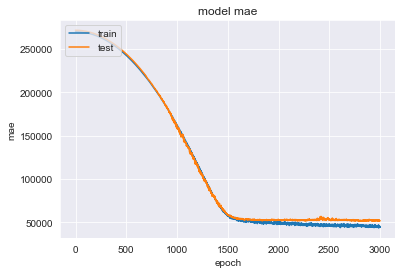

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


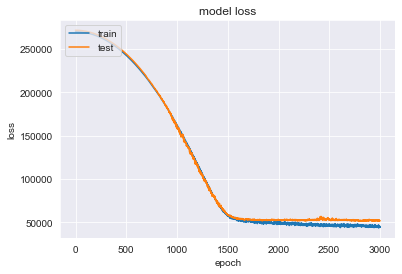

In [133]:
print_history_mae(history)
print_history_loss(history)

In [134]:
y_pred_mlp = model.predict(X_test_scaled)

In [135]:
y_pred_mlp

array([[294709.06 ],
       [356741.75 ],
       [340473.   ],
       [226991.39 ],
       [270346.12 ],
       [259686.34 ],
       [210253.98 ],
       [363341.7  ],
       [286896.44 ],
       [281934.2  ],
       [292986.12 ],
       [302994.44 ],
       [339184.3  ],
       [250224.92 ],
       [315292.06 ],
       [297499.66 ],
       [338525.56 ],
       [300272.28 ],
       [256945.08 ],
       [350481.28 ],
       [259692.47 ],
       [283438.25 ],
       [154689.19 ],
       [269794.34 ],
       [199169.22 ],
       [274693.3  ],
       [300311.7  ],
       [249991.75 ],
       [231661.38 ],
       [284855.94 ],
       [293046.1  ],
       [269239.75 ],
       [212811.53 ],
       [261760.9  ],
       [344653.16 ],
       [226224.2  ],
       [256289.94 ],
       [274693.3  ],
       [297741.25 ],
       [247046.17 ],
       [261760.9  ],
       [217531.84 ],
       [222541.17 ],
       [315679.   ],
       [245316.12 ],
       [289546.2  ],
       [356682.78 ],
       [27901

In [136]:
y_preds = []

for item in y_pred_mlp:
    y_preds.append(item[0])

In [137]:
# Metrics
printMetrics(y_test, y_preds)

MAE: 51729.27952906468
MSE: 4911025013.2180605
RMSE: 70078.70584719769


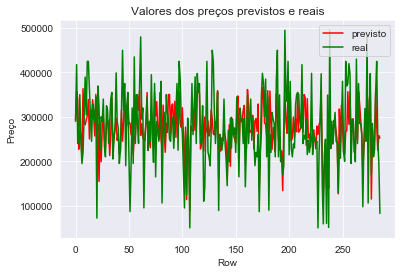

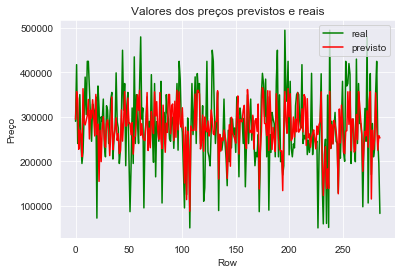

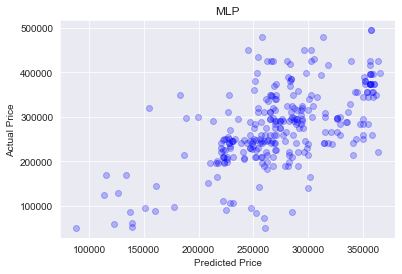

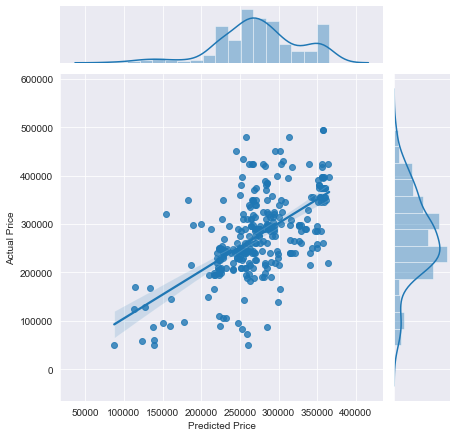

In [138]:
drawPlots(y_test, y_preds, 'MLP')